## **프로젝트 환경 설정**

In [9]:
# ==============================================================================
# 섹션 0: 프로젝트 환경 설정
# ==============================================================================

# ------------------------------------------------------------------------------
# 0.1. 목표 정의 (주석으로 명시)
# ------------------------------------------------------------------------------
# [cite_start]- 자산: KOSPI, KOSDAQ, 현대차 [cite: 67]
# [cite_start]- 모델: RNN, LSTM, GRU [cite: 67]
# [cite_start]- 타깃: 1. 주가 수준, 2. 수익률, 3. 상승/하락 등락 [cite: 67]
# [cite_start]- 목표: 위 조합에 대한 예측 성능을 비교 분석 [cite: 67]

# ------------------------------------------------------------------------------
# 0.2. [cite_start]라이브러리 임포트 [cite: 68]
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

# ------------------------------------------------------------------------------
# 0.3. [cite_start]기본 설정 [cite: 69]
# ------------------------------------------------------------------------------
def set_seed(seed=42):
    """결과의 재현성을 위한 랜덤 시드 고정 함수"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # GPU 사용 시 추가 설정
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if use multi-GPU
        # cuDNN의 결정론적 동작 설정
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 시드 고정
SEED = 42
set_seed(SEED)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch Version: {torch.__version__}")
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu126
Using device: cpu


시드를 고정하는 것?  
- 딥러닝 실험에서 '운'이라는 요소를 통제
- 결과를 신뢰할 수 있고, 누구나 재현할 수 있도록 만드는 필수적인 장치

## **1. 데이터 준비**

In [10]:
# ==============================================================================
# 섹션 1: 데이터 준비 (최종 완성 버전)
# ==============================================================================
print("===== 섹션 1: 데이터 준비 시작 =====")

# --- 1.1. 라이브러리 임포트 및 데이터 로드 ---
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

try:
    import yfinance
except ImportError:
    !pip install yfinance -q
print("yfinance 라이브러리 준비 완료.")

tickers = {'KOSPI': '^KS11', 'KOSDAQ': '^KQ11', '현대차': '005380.KS'}
start_date, end_date = "2015-01-01", "2025-08-31"

dataframes = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.ffill(inplace=True)
    dataframes[name] = df
print("데이터 로드 및 컬럼 정리 완료.")

# --- 1.2. 피처 엔지니어링 ---
def create_features(df):
    df_new = df.copy()
    if 'Adj Close' in df_new.columns:
        df_new['Close'] = df_new['Adj Close']
    df_new = df_new[['Open', 'High', 'Low', 'Close', 'Volume']]
    df_new['log_price'] = np.log(df_new['Close'])
    df_new['log_return'] = df_new['log_price'].diff()
    df_new['up_down'] = (df_new['log_return'] > 0).astype(float)
    df_new['ma5'] = df_new['Close'].rolling(window=5).mean()
    df_new['ma20'] = df_new['Close'].rolling(window=20).mean()
    df_new['std5'] = df_new['Close'].rolling(window=5).std()
    df_new['std20'] = df_new['Close'].rolling(window=20).std()
    df_new.dropna(inplace=True)
    return df_new

# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★#
#create_features 함수 적용
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
for asset_name in dataframes.keys():
    dataframes[asset_name] = create_features(dataframes[asset_name])
print("피처 엔지니어링 적용 완료.")

# --- 1.3. 데이터 분할 및 스케일링 ---
train_ratio, val_ratio = 0.6, 0.2
split_data = {}
scalers = {}

for asset_name, df in dataframes.items():
    train_df, val_df, test_df = df.iloc[:int(len(df)*train_ratio)], df.iloc[int(len(df)*train_ratio):int(len(df)*(train_ratio+val_ratio))], df.iloc[int(len(df)*(train_ratio+val_ratio)):]
    features_to_scale = train_df.columns.tolist()

    scaler = MinMaxScaler().fit(train_df[features_to_scale])
    train_scaled, val_scaled, test_scaled = scaler.transform(train_df[features_to_scale]), scaler.transform(val_df[features_to_scale]), scaler.transform(test_df[features_to_scale])

    split_data[asset_name] = {'train': train_scaled, 'val': val_scaled, 'test': test_scaled, 'features': features_to_scale}
    scalers[asset_name] = scaler

print("데이터 분할 및 스케일링 완료.")
print("\n===== 섹션 1: 데이터 준비 완료 =====")

===== 섹션 1: 데이터 준비 시작 =====
yfinance 라이브러리 준비 완료.
데이터 로드 및 컬럼 정리 완료.
피처 엔지니어링 적용 완료.
데이터 분할 및 스케일링 완료.

===== 섹션 1: 데이터 준비 완료 =====


/tmp/ipython-input-2811665025.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2811665025.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2811665025.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


**`섹션 1`: 데이터 준비 (재료 손질 및 가공)**

> **"날 것"의 데이터를 모델이 학습 가능한 "요리 재료"로 만드는 과정**

- **목표**: 원본 시계열 데이터의 품질을 높이고, 모델이 패턴을 쉽게 학습할 수 있는 유용한 정보(피처)를 추가하며, 객관적인 성능 평가를 위한 환경을 구축합니다.

- **핵심 역할**:
  - **피처 엔지니어링**:
    - **로그 수익률**과 같은 피처를 추가하여 데이터의 **안정성**을 높여 모델의 학습을 돕습니다.
  (주가가 시간이 지남에 따라 계속 상승하는 비정상성 방지)
    - **이동 평균** 등 기술적 지표를 추가하여 모델에게 **추세**와 같은 추가적인 힌트를 제공합니다. (모델이 현재 가격의 맥락을 이해하는 데 도움)
  - **데이터 분할 (Train/Val/Test)**:
    - **훈련(Train)** 데이터로 모델을 학습시키고, **검증(Validation)** 데이터로 성능을 중간 점검하며, **테스트(Test)** 데이터로 최종 실력을 객관적으로 평가하기 위해 데이터를 분리합니다.
  - **스케일링**:
    - 주가, 거래량 등 단위와 범위가 다른 피처들의 스케일을 `0~1` 사이로 통일하여, 모델이 모든 피처를 **공평하게 학습**하도록 만듭니다.
  (모델이 크기에 현혹되어 큰 값에만 집중하는 것 방지)
    - **미래 정보 유출(Data Leakage)을 방지**하며 훈련시키는 것이 핵심입니다.


알겠습니다. 보여주신 형식에 맞춰 `섹션 1`과 `섹션 2`에 대한 체크리스트를 다시 작성해 드리겠습니다.

### 섹션 1: 데이터 준비 코드 구현 현황
**내용**

**범위: 2015.01.01 - 2025.08.31 기간 동안의 일별 데이터**
✅ **구현 완료**: `yf.download` 함수에 `start_date`와 `end_date`를 인자로 전달하여 기간을 정확히 설정했고, `MultiIndex` 컬럼 문제를 해결하여 데이터 처리 오류를 방지했습니다.

**자산 선택: KOSPI/KOSDAQ, 현대차**
✅ **구현 완료**: `tickers` 딕셔너리에 세 자산의 티커(`^KS11`, `^KQ11`, `005380.KS`)를 지정하여 데이터를 로드했습니다.

**특징(필수): OHLCV, 로그가격, 로그수익률 $r_{t}=log(p_{t}/p_{t-1})$**
✅ **구현 완료**: `create_features` 함수 내에서 `np.log()`와 `.diff()` 함수를 사용하여 `log_price`와 `log_return` 피처를 생성했습니다.

**특징(선택): 이동평균/표준편차...**
✅ **구현 완료**: `create_features` 함수 내에서 `.rolling().mean()`과 `.rolling().std()` 함수를 사용하여 `이동평균(ma5, ma20)`과 `이동 표준편차(std5, std20)`를 선택적 피처로 추가했습니다.

**상승/하락 라벨 생성 ($y_{t+1}=1[r_{t+1}>\theta]$)**
✅ **구현 완료**: `create_features` 함수에서 **스케일링 전의 원본 로그수익률**을 기준으로 `(df_new['log_return'] > 0).astype(float)` 코드를 통해 정확한 이진(0/1) 라벨(`up_down`)을 생성했습니다.

**정규화: 훈련 구간 통계로만 스케일(데이터 누수 금지)**
✅ **구현 완료**: `MinMaxScaler` 객체 생성 후, **`scaler.fit(train_df)`** 코드를 통해 **오직 훈련(Train) 데이터에만 통계치를 학습**시켜 미래정보 누수를 방지했습니다.

**분할: Train(60%)-Valid(20%)-Test(20%) 시간순 고정...**
✅ **구현 완료**: `train_ratio=0.6`, `val_ratio=0.2` 변수를 설정하고, `df.iloc[...]`를 사용하여 전체 데이터를 시간 순서에 따라 훈련, 검증, 테스트 세트로 정확히 분할했습니다.

---


## **2. 데이터셋 및 데이터로더 구축**

In [11]:
# ==============================================================================
# 섹션 2: 데이터셋 및 데이터로더 구축 (최종 완성 버전)
# ==============================================================================
print("===== 섹션 2: 데이터셋 및 데이터로더 구축 시작 =====")

# TimeSeriesDataset 클래스 정의 (이전에 정의한 코드가 이 셀 또는 이전 셀에 있어야 합니다)
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length, target_idx):
        self.data = data
        self.sequence_length = sequence_length
        self.target_idx = target_idx

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.sequence_length]
        y = self.data[idx + self.sequence_length, self.target_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

print("2.1. 시계열 데이터셋 클래스 'TimeSeriesDataset' 정의 완료.")

# ------------------------------------------------------------------------------
# 2.2. 데이터로더 생성 (수정된 부분)
# ------------------------------------------------------------------------------
INPUT_SEQUENCE_LENGTH = 20
BATCH_SIZE = 64

asset_to_load = 'KOSPI'
print(f"\n--- '{asset_to_load}' 자산에 대한 데이터로더 생성 예시 ---")

features = split_data[asset_to_load]['features']

# ★★★★★★★★★★★★★★★★★ 수정된 부분 ★★★★★★★★★★★★★★★★★
# 컬럼이 단순 문자열로 변경되었으므로, 간단한 .index() 메소드를 사용합니다.
try:
    price_target_idx = features.index('log_price')
    return_target_idx = features.index('log_return')
    updown_target_idx = features.index('up_down')
except ValueError as e:
    print(f"오류: 타깃 피처를 찾을 수 없습니다. 피처 목록: {features}")
    raise e
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

# 예시: '주가(log_price)' 예측용 데이터셋 생성
example_target_idx = price_target_idx
print(f"예시 타깃: '{features[example_target_idx]}' (인덱스: {example_target_idx})")

train_dataset = TimeSeriesDataset(split_data[asset_to_load]['train'], INPUT_SEQUENCE_LENGTH, example_target_idx)
val_dataset = TimeSeriesDataset(split_data[asset_to_load]['val'], INPUT_SEQUENCE_LENGTH, example_target_idx)
test_dataset = TimeSeriesDataset(split_data[asset_to_load]['test'], INPUT_SEQUENCE_LENGTH, example_target_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n2.2. 데이터로더 생성 완료.")

print("\n===== 섹션 2: 데이터셋 및 데이터로더 구축 완료 =====")

===== 섹션 2: 데이터셋 및 데이터로더 구축 시작 =====
2.1. 시계열 데이터셋 클래스 'TimeSeriesDataset' 정의 완료.

--- 'KOSPI' 자산에 대한 데이터로더 생성 예시 ---
예시 타깃: 'log_price' (인덱스: 5)

2.2. 데이터로더 생성 완료.

===== 섹션 2: 데이터셋 및 데이터로더 구축 완료 =====




섹션 2: 데이터셋 & 데이터로더
> **잘 가공된 데이터를 PyTorch 모델이 "먹기 좋은" 형태로 공급하는 파이프라인 구축 과정**

- **목표**: NumPy 배열 형태의 데이터 덩어리를, PyTorch 프레임워크가 요구하는 정해진 형식과 규격에 맞춰 전달하는 자동화된 공급 장치를 만듭니다.

- **핵심 역할**:
  - **`Dataset` 클래스**:
    - 연속된 시계열 데이터를 "**슬라이딩 윈도우(Sliding Window)**" 방식으로 잘라냅니다.
    - `(과거 L일치 데이터, 다음 날 정답)` 형태의 수많은 학습 샘플 쌍을 생성하는 **설계도** 역할을 합니다.
  - **`DataLoader`**:
    - `Dataset`이 만든 개별 샘플들을 **미니배치(mini-batch)** 단위(예: 64개씩)로 묶어줍니다.
    - 데이터를 작은 묶음으로 나누어 전달함으로써 **메모리를 효율적으로 사용**하고, 모델을 **안정적으로 학습**시킬 수 있습니다.
    - 훈련 시 배치를 섞어주는 `shuffle=True` 옵션은 모델의 **일반화 성능을 향상**시킵니다.

### 섹션 2: 데이터셋 및 데이터로더 코드 구현 현황
**내용**

**윈도우: 입력 길이 $L\in\{5,20,60\}$ 등**
✅ **구현 완료**: `TimeSeriesDataset` 클래스의 `__init__` 함수가 `sequence_length` (L)를 인자로 받도록 설계하여, 실험 시 `L`값을 자유롭게 변경하며 데이터셋을 생성할 수 있습니다.

**배치 생성 시 $t\rightarrow t+1$ 라벨 정렬 확인**
✅ **구현 완료**: `TimeSeriesDataset`의 `__getitem__` 메소드에서 입력 데이터는 `x = self.data[idx : idx + sequence_length]`로, 타깃 데이터는 `y = self.data[idx + sequence_length, ...]`로 슬라이싱하여, 입력 시퀀스 바로 다음 시점의 값이 타깃이 되도록 정확히 정렬했습니다.

## **3. 모델 아키텍처 설계**

In [12]:
# ==============================================================================
# 섹션 3: 모델 아키텍처 (최종 보완 및 검증 포함)
# ==============================================================================
print("===== 섹션 3: 모델 아키텍처 보완된 최종본 재정의 =====")

class FinancialForecastingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, model_type='LSTM', target_type='Price'):
        super(FinancialForecastingModel, self).__init__()
        self.model_type = model_type
        self.target_type = target_type
        self.hidden_dim = hidden_dim

        # GRU 모니터링을 위한 변수 초기화 (h_n 통계로 간접 모니터링)
        if model_type == 'GRU':
            self.gru_monitor_stats = {'h_n_mean': None, 'h_n_std': None}

        # 1. Recurrent Layer 정의
        if model_type == 'RNN':
            # [cite_start]RNN: tanh 활성화 사용 [cite: 20]
            self.recurrent_layer = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, nonlinearity='tanh')
        elif model_type == 'LSTM':
            self.recurrent_layer = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif model_type == 'GRU':
            self.recurrent_layer = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # 2. Output Head 정의
        # 수준/수익률/분류 모두 하나의 선형 레이어를 사용하고, 활성화 함수는 손실 함수에서 처리
        self.output_head = nn.Linear(hidden_dim, 1)

        # 3. 가중치 초기화 적용
        self.init_weights()

    def init_weights(self):
        # [cite_start]입력 가중치: Xavier/He 초기화 [cite: 32]
        # [cite_start]순환 가중치: orthogonal 초기화 [cite: 20, 32]
        for name, param in self.recurrent_layer.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # [cite_start]LSTM forget bias b_f ≈ 1 설정 [cite: 22, 32]
                if self.model_type == 'LSTM':
                    n = param.size(0); start, end = n // 4, n // 2
                    param.data[start:end].fill_(1.) # Forget Gate Bias를 1로 설정

        # Output Head 초기화
        nn.init.xavier_uniform_(self.output_head.weight)
        self.output_head.bias.data.fill_(0)

    def forward(self, x):
        # RNN/LSTM/GRU 레이어 통과
        recurrent_output, h_n = self.recurrent_layer(x)

        # GRU 모니터링: h_n 통계 기록 (z_t 평균 통계 모니터링 대안)
        if self.model_type == 'GRU' and isinstance(h_n, torch.Tensor):
            # h_n shape: (num_layers, batch_size, hidden_dim)
            last_layer_h = h_n[-1] # 마지막 레이어의 최종 은닉 상태
            # detach()로 미분 그래프에서 분리하여 순수한 통계값 기록
            self.gru_monitor_stats['h_n_mean'] = last_layer_h.mean().item()
            self.gru_monitor_stats['h_n_std'] = last_layer_h.std().item()

        # 마지막 시점 (t)의 출력을 사용해 t+1 예측
        last_timestep_output = recurrent_output[:, -1, :]

        # Output Head 통과
        output = self.output_head(last_timestep_output)

        # output shape: (batch_size, 1) -> (batch_size)
        return output.squeeze(-1), h_n

print("3.1. 'FinancialForecastingModel' 클래스 정의 완료.")


# ------------------------------------------------------------------------------
# 3.2. 모델 인스턴스화 및 검증 (누락된 부분 복원)
# ------------------------------------------------------------------------------
try:
    # 검증을 위한 하이퍼파라미터 설정 (예시로 2-레이어 LSTM 사용)
    INPUT_DIM = split_data['KOSPI']['train'].shape[1]
    HIDDEN_DIM = 128
    NUM_LAYERS = 2
    DROPOUT = 0.2

    model_lstm_init = FinancialForecastingModel(
        input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS,
        dropout=DROPOUT, model_type='LSTM'
    ).to(device)

    print(f"\n--- 가중치 초기화 확인 (LSTM) ---")
    # LSTM Forget Gate 편향 검증: weight_hh_l0 (첫 번째 레이어)의 두 번째 쿼터 확인
    lstm_bias_l0 = model_lstm_init.recurrent_layer.bias_hh_l0.cpu().detach().numpy()
    forget_gate_bias_start, forget_gate_bias_end = HIDDEN_DIM, HIDDEN_DIM * 2
    # Forget gate 편향의 첫 5개 값 출력
    print(f"LSTM Forget Gate 편향 (일부): {lstm_bias_l0[forget_gate_bias_start:forget_gate_bias_start+5]}")
    print(" -> 값이 1.0으로 채워져 있으면 정상입니다. (bf ≈ 1)")

    # 더미 데이터로 Forward Pass 실행
    # (batch_size: 64, sequence_length: 5, input_dim: 12 (예상))
    dummy_input = torch.randn(64, 5, INPUT_DIM).to(device)
    pred, hidden_state = model_lstm_init(dummy_input)

    print("\n--- 모델 출력 형태 확인 ---")
    print(f"입력 shape: {dummy_input.shape}")
    print(f"예측(pred) shape: {pred.shape}")

    # 은닉 상태 shape 확인 (LSTM은 튜플 형태)
    if isinstance(hidden_state, tuple):
        print(f"은닉상태(h_n) shape: {hidden_state[0].shape}")
        print(f"셀상태(c_n) shape: {hidden_state[1].shape}")
    else:
        print(f"은닉상태(h_n) shape: {hidden_state.shape}")
    print(" -> 예측 shape이 [batch_size]와 일치하면 정상입니다.")

    # GRU 모니터링 확인 예시 (실제 실험 시에는 런 루프 내에서 모니터링)
    model_gru = FinancialForecastingModel(
        input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS,
        dropout=DROPOUT, model_type='GRU'
    ).to(device)
    model_gru(dummy_input) # 더미 포워드 패스 실행하여 통계 업데이트
    print(f"\n--- GRU 모니터링 확인 (h_n 통계) ---")
    print(f"h_n_mean: {model_gru.gru_monitor_stats['h_n_mean']:.5f}")
    print(f"h_n_std: {model_gru.gru_monitor_stats['h_n_std']:.5f}")
    print(" -> 학습 중 h_n 통계를 모니터링하여 안정성을 간접적으로 확인 가능.")

    print("\n--- Variational Dropout 관련 보고서 작성 시 고려 사항 ---")
    print("현재 코드는 nn.LSTM의 기본 Dropout을 사용합니다. 명세의 Variational Dropout을 완벽히 구현하기 위해서는 커스텀 셀이 필요하므로, 보고서에서 이 부분을 한계점으로 명시하고 대신 PyTorch의 기본 '레이어 간' Dropout을 사용했음을 언급합니다.")

    print("\n===== 섹션 3: 모델 아키텍처 설계 최종 완료 (보완) =====")

except NameError:
    print("\n[경고] 'split_data' 변수가 정의되지 않았습니다. 섹션 1을 먼저 실행해주세요.")
    print("===== 섹션 3: 모델 아키텍처 클래스 정의 완료 (동작 확인은 생략) =====")

===== 섹션 3: 모델 아키텍처 보완된 최종본 재정의 =====
3.1. 'FinancialForecastingModel' 클래스 정의 완료.

--- 가중치 초기화 확인 (LSTM) ---
LSTM Forget Gate 편향 (일부): [1. 1. 1. 1. 1.]
 -> 값이 1.0으로 채워져 있으면 정상입니다. (bf ≈ 1)

--- 모델 출력 형태 확인 ---
입력 shape: torch.Size([64, 5, 12])
예측(pred) shape: torch.Size([64])
은닉상태(h_n) shape: torch.Size([2, 64, 128])
셀상태(c_n) shape: torch.Size([2, 64, 128])
 -> 예측 shape이 [batch_size]와 일치하면 정상입니다.

--- GRU 모니터링 확인 (h_n 통계) ---
h_n_mean: 0.00036
h_n_std: 0.07488
 -> 학습 중 h_n 통계를 모니터링하여 안정성을 간접적으로 확인 가능.

--- Variational Dropout 관련 보고서 작성 시 고려 사항 ---
현재 코드는 nn.LSTM의 기본 Dropout을 사용합니다. 명세의 Variational Dropout을 완벽히 구현하기 위해서는 커스텀 셀이 필요하므로, 보고서에서 이 부분을 한계점으로 명시하고 대신 PyTorch의 기본 '레이어 간' Dropout을 사용했음을 언급합니다.

===== 섹션 3: 모델 아키텍처 설계 최종 완료 (보완) =====




**섹션 3 (모델 아키텍처 설계)의 역할**

위의 비유에 이어서 설명하면, **섹션 3은 우리 파이프라인의 심장인 '핵심 기계(모델)'를 설계하고 제작하는 단계**입니다.


- **유연성과 효율성**: 이번 과제의 가장 중요한 요구사항은 **"세 모델(RNN, LSTM, GRU)을 동일한 파이프라인에서 교체하여 학습"** 하는 것
    - 우리가 `섹션 3`에서 세 가지 기계를 따로따로 만드는 대신, **부품(model_type)만 교체하면** RNN도 되고, LSTM도 되고, GRU도 되는 아주 유연한 만능 기계 하나를 만든 이유가 바로 이것입니다.
    - 덕분에 우리는 조립 라인 전체를 바꿀 필요 없이, `model_type`이라는 스위치 하나만 바꿔서 세 가지 모델에 대한 실험을 매우 효율적으로 진행할 수 있습니다.

*파이프라인(Pipeline)이란?*

파이프라인(Pipeline)은 데이터가 입력되어서 최종 결과가 나올 때까지 거치는 **전체 작업의 흐름을 자동화한 시스템**




### 3. 모델 사양 구현현황

**세 모델은 동일한 파이프라인에서 교체하여 학습한다.**
✅ **구현 완료**: `FinancialForecastingModel` 클래스에서 `model_type` 인자를 통해 RNN, LSTM, GRU를 선택할 수 있도록 구현했습니다.

**공통 하이퍼파라미터**
✅ **구현 완료**: `hidden`, `layers`, `dropout` 등 하이퍼파라미터를 모델 생성 시 인자로 전달하여 동적으로 구성할 수 있도록 구현했습니다.

**RNN: tanh**
✅ **구현 완료**: `nn.RNN` 모듈 생성 시 `nonlinearity='tanh'` 옵션을 명시하여 구현했습니다.

**RNN: orthogonal init**
✅ **구현 완료**: `init_weights` 함수에서 순환가중치(`weight_hh`)를 `Orthogonal` 방식으로 초기화하도록 구현했습니다.

**RNN: gradient clipping(1.0)**
--> ✅ 섹션4에서 구현

**LSTM: forget bias $b_{f}\approx1$**
✅ **구현 완료**: `init_weights` 함수에서 LSTM의 forget gate 편향 값을 1로 설정하는 로직을 구현했습니다.

**LSTM: (선택) LayerNorm, variational dropout**
❌ **미구현**: 선택 사항으로, 현재는 PyTorch의 기본 `dropout`을 사용하며 `LayerNorm`은 구현하지 않았습니다.

**GRU: 기본 설정**
✅ **구현 완료**: `FinancialForecastingModel` 클래스에서 `nn.GRU` 모듈을 기본 설정으로 생성하도록 구현했습니다.

**GRU: $z_{t}$ 평균 통계 모니터링**
✅ **간접구현**:  섹션 3과 섹션 4의 forward, evaluate 함수를 수정하여 마지막 은닉 상태(h
t
​
 )의 평균을 관찰하는 방식으로 간접 구현되었습니다..

**출력 헤드 - 수준: $log~p_{t+1} = Wh_{t}+b$**
✅ **구현 완료**: `forward` 함수에서 순환층의 마지막 은닉 상태($h_t$)를 `nn.Linear`층에 통과시켜 해당 계산을 수행합니다.

**출력 헤드 - 수준: $\hat{p}_{t+1}=exp(log~p_{t+1}})$**
❌ **섹션6에서 구현예정**

**출력 헤드 - 수익률: $\hat{r}_{t+1}=Wh_{t}+b$**
✅ **구현 완료**: '수준' 예측과 동일한 `nn.Linear` 출력 헤드를 통해 구현됩니다.

**출력 헤드 - 업/다운: $\hat{y}_{t+1}=\sigma(Wh_{t}+b)$**
✅ **구현 완료 (설명 필요)**: 모델 자체는 로짓($Wh_{t}+b$)까지만 출력하고, 활성화 함수인 시그모이드($\sigma$)는 수치적 안정성을 위해 손실 함수인 `nn.BCEWithLogitsLoss` 내부에서 함께 계산되도록 구현했습니다.

**손실함수: 수준/수익률 → MSE/MAE, 업/다운 → BCE**
✅ **구현 완료**: `run_experiment` 함수 내에서 `target_type`에 따라 `MSELoss`와 `BCEWithLogitsLoss`를 자동으로 선택하여 사용합니다. (구현 위치: 섹션 4)

**초기화: 순환가중치 orthogonal, 입력가중치 Xavier/He, LSTM은 $b_{f} > 0$**
✅ **구현 완료**: `init_weights` 함수에서 모든 가중치 초기화 요구사항을 구현했습니다


---


## **섹션 4: 학습 및 평가 로직 구현**

In [13]:
# ==============================================================================
# 섹션 4: 학습 및 평가 로직 (최종 완성 버전)
# ==============================================================================
print("===== 섹션 4: 학습/평가 로직 최종본 재정의 =====")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import time
import copy

def train_one_epoch(model, data_loader, optimizer, loss_function, device, clip_norm=1.0):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        predictions, _ = model(x_batch) # h_n은 학습 시 사용하지 않으므로 _로 받음
        loss = loss_function(predictions, y_batch)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, loss_function, device, target_type='Price'):
    model.eval()
    total_loss = 0.0
    all_predictions, all_labels = [], []
    gru_hidden_states = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions, h_n = model(x_batch)
            loss = loss_function(predictions, y_batch)
            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            if model.model_type == 'GRU':
                gru_hidden_states.append(h_n[-1].cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    metrics = {}
    labels_arr, preds_arr = np.array(all_labels), np.array(all_predictions)

    if target_type in ['Price', 'Return']:
        metrics['rmse'] = np.sqrt(mean_squared_error(labels_arr, preds_arr))
        metrics['mae'] = mean_absolute_error(labels_arr, preds_arr)
        metrics['r2'] = r2_score(labels_arr, preds_arr)
    elif target_type == 'Up/Down':
        probs = 1 / (1 + np.exp(-preds_arr)); preds_class = (probs > 0.5).astype(int)
        metrics['accuracy'] = accuracy_score(labels_arr, preds_class)
        metrics['f1'] = f1_score(labels_arr, preds_class, zero_division=0)
        if len(np.unique(labels_arr)) < 2:
            metrics['auroc'], metrics['auprc'] = np.nan, np.nan
        else:
            metrics['auroc'] = roc_auc_score(labels_arr, probs)
            metrics['auprc'] = average_precision_score(labels_arr, probs)

    if model.model_type == 'GRU' and len(gru_hidden_states) > 0:
        all_h_n = np.concatenate(gru_hidden_states, axis=0)
        metrics['gru_h_mean'] = np.mean(all_h_n)

    return avg_loss, metrics

def run_experiment(model, train_loader, val_loader, learning_rate, weight_decay, epochs, patience):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    target_type = model.target_type

    if target_type in ['Price', 'Return']:
        loss_function = nn.MSELoss()
    elif target_type == 'Up/Down':
        labels = np.concatenate([y.numpy() for _, y in train_loader])
        count_0, count_1 = np.sum(labels == 0), np.sum(labels == 1)
        pos_weight = torch.tensor([count_0 / count_1], device=device) if count_1 > 0 and count_0 > 0 else None
        loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        if pos_weight is not None: print(f"BCE Loss: pos_weight = {pos_weight.item():.2f}")

    best_val_loss, patience_counter, best_model_state = float('inf'), 0, None
    history = {'train_loss': [], 'val_loss': []}

    print(f"--- Experiment Start: {model.model_type} for {target_type} ---")
    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_function, device)
        val_loss, val_metrics = evaluate(model, val_loader, loss_function, device, target_type)
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)

        gru_mean_str = f"| GRU h_mean: {val_metrics.get('gru_h_mean', 0):.4f}" if model.model_type == 'GRU' else ""
        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} {gru_mean_str}")

        if val_loss < best_val_loss:
            best_val_loss, patience_counter = val_loss, 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}"); break

    if best_model_state: model.load_state_dict(best_model_state)
    return model, history

print("모든 기능(GRU 모니터링, 클래스 가중치)이 포함된 학습/평가 함수 최종 정의 완료.")

===== 섹션 4: 학습/평가 로직 최종본 재정의 =====
모든 기능(GRU 모니터링, 클래스 가중치)이 포함된 학습/평가 함수 최종 정의 완료.


In [14]:
# ==============================================================================
# 섹션 4 - 최종 동작 확인 예시 (독립 실행 가능 버전)
# ==============================================================================
print("\n--- 동작 확인 예시 실행 (독립 버전) ---")

# --- 1. 테스트 환경 설정 ---
# 이 예시에서 테스트할 자산, 모델, 타깃을 지정합니다.
ASSET_TO_TEST = 'KOSPI'
MODEL_TO_TEST = 'LSTM'
TARGET_TO_TEST = 'Price'

# 모델 하이퍼파라미터 설정
INPUT_DIM = split_data[ASSET_TO_TEST]['train'].shape[1] # 피처 개수 자동 계산
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.2

# 학습 하이퍼파라미터 설정
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 5 # 예시이므로 짧게 설정
PATIENCE = 3
BATCH_SIZE = 128
SEQUENCE_LENGTH = 5 # 실험 1과 동일한 L=5 사용

# --- 2. 데이터로더 생성 ---
# 지정된 타깃에 맞는 데이터로더를 이 셀에서 직접 생성합니다.
features = split_data[ASSET_TO_TEST]['features']
try:
    if TARGET_TO_TEST == 'Price': target_idx = features.index('log_price')
    elif TARGET_TO_TEST == 'Return': target_idx = features.index('log_return')
    elif TARGET_TO_TEST == 'Up/Down': target_idx = features.index('up_down')
except ValueError:
    print(f"오류: '{TARGET_TO_TEST}' 타깃 피처를 찾을 수 없습니다.")
    # 이 셀을 여기서 중단하고 싶으면 raise를 사용하거나, 다른 방식으로 처리할 수 있습니다.

train_data, val_data, test_data = split_data[ASSET_TO_TEST]['train'], split_data[ASSET_TO_TEST]['val'], split_data[ASSET_TO_TEST]['test']
train_ds = TimeSeriesDataset(train_data, SEQUENCE_LENGTH, target_idx)
val_ds = TimeSeriesDataset(val_data, SEQUENCE_LENGTH, target_idx)
test_ds = TimeSeriesDataset(test_data, SEQUENCE_LENGTH, target_idx)
train_loader_test = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader_test = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
print("동작 확인용 데이터로더 생성 완료.")

# --- 3. 모델 생성 ---
test_model = FinancialForecastingModel(
    input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS,
    dropout=DROPOUT, model_type=MODEL_TO_TEST, target_type=TARGET_TO_TEST
).to(device)
print("동작 확인용 모델 생성 완료.")

# --- 4. 실험 실행 ---
trained_model, history = run_experiment(
    model=test_model,
    train_loader=train_loader_test,
    val_loader=val_loader_test,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS,
    patience=PATIENCE
)

# --- 5. 최종 평가 ---
loss_fn = nn.MSELoss() if TARGET_TO_TEST != 'Up/Down' else nn.BCEWithLogitsLoss()
final_test_loss, final_test_metrics = evaluate(trained_model, test_loader_test, loss_fn, device, TARGET_TO_TEST)

print("\n--- 최종 테스트 성능 ---")
print(f"Test Loss: {final_test_loss:.4f}")
print(f"Test Metrics: {final_test_metrics}")

print("\n===== 동작 확인 예시 실행 완료 =====")


--- 동작 확인 예시 실행 (독립 버전) ---
동작 확인용 데이터로더 생성 완료.
동작 확인용 모델 생성 완료.
--- Experiment Start: LSTM for Price ---
Epoch 1/5 | Train Loss: 0.2000 | Val Loss: 0.1781 
Epoch 2/5 | Train Loss: 0.0284 | Val Loss: 0.0023 
Epoch 3/5 | Train Loss: 0.0084 | Val Loss: 0.0013 
Epoch 4/5 | Train Loss: 0.0035 | Val Loss: 0.0080 
Epoch 5/5 | Train Loss: 0.0025 | Val Loss: 0.0013 

--- 최종 테스트 성능 ---
Test Loss: 0.0008
Test Metrics: {'rmse': np.float64(0.030587559569610755), 'mae': 0.02449928969144821, 'r2': 0.8901715278625488}

===== 동작 확인 예시 실행 완료 =====


### 4. 학습 안정화 구현현황

**Optimizer: AdamW**
✅ **구현 완료**: `run_experiment` 함수에서 `torch.optim.AdamW`를 옵티마이저로 사용합니다.

**Optimizer: 러닝레이트 스케줄(선택; cosine)**
❌ **미구현**: 선택 사항으로, 현재 코드에는 구현되어 있지 않습니다.

**초기화: 순환가중치 orthogonal, 입력가중치 Xavier/He, LSTM은 $b_{f} > 0$**    
✅(구현 위치: 섹션 3)


**정규화/규제: weight decay**
✅ **구현 완료**: `AdamW` 옵티마이저 생성 시 `weight_decay` 값을 인자로 전달하여 구현했습니다.

**정규화/규제: variational(locked) dropout, (선택) LayerNorm**
❌ **미구현**: 선택 및 고급 기법으로, 현재 코드에는 구현되어 있지 않습니다.

**클리핑: global grad norm ≤ 1.0**
✅ **구현 완료**: `train_one_epoch` 함수에서 그래디언트 클리핑을 구현했습니다.

**조기종료: valid 성능 기준 patience 5–10 epochs**
✅ **구현 완료**: `run_experiment` 함수에서 검증 손실을 기준으로 `patience` 기반의 조기 종료 로직을 구현했습니다.

**3. 모델 사양**

**RNN: gradient clipping(1.0)**
✅ 구현 완료: train_one_epoch 함수에서 torch.nn.utils.clip_grad_norm_을 통해 그래디언트 클리핑을 구현했습니다. (구현 위치: 섹션 4)





## **섹션 5: 비교 실험 실행**

In [15]:
# ==============================================================================
# 데이터 검증: Up/Down 라벨 분포 확인 (수정본)
# ==============================================================================
print("===== 데이터 검증: Up/Down 라벨 분포 확인 =====")

# ★★★★★★★★★★★★★★★★★ 수정된 부분 ★★★★★★★★★★★★★★★★★
# 'assets_to_run' 변수가 정의되지 않았다는 오류를 해결하기 위해 리스트를 직접 선언합니다.
assets_to_run = ['KOSPI', 'KOSDAQ', '현대차']
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

for asset_name in assets_to_run:
    print(f"\n--- 자산: {asset_name} ---")

    # 'up_down' 피처의 인덱스 찾기
    features = split_data[asset_name]['features']
    try:
        # 이제 features 리스트는 단순 문자열로 구성되어 있으므로 .index()를 사용합니다.
        updown_target_idx = features.index('up_down')

    except ValueError:
        print(f"  오류: '{asset_name}' 데이터에서 'up_down' 피처를 찾을 수 없습니다.")
        continue

    # 각 데이터셋의 'up_down' 라벨 분포 확인
    for data_type in ['train', 'val', 'test']:
        data_subset = split_data[asset_name][data_type]
        updown_labels = data_subset[:, updown_target_idx].astype(int)

        # 0과 1의 개수를 셈
        counts = np.bincount(updown_labels)
        down_count = counts[0] if len(counts) > 0 else 0
        up_count = counts[1] if len(counts) > 1 else 0

        print(f"  - {data_type.capitalize()} Set: 하락(0) = {down_count}개 | 상승(1) = {up_count}개")

print("\n===== 데이터 검증 완료 =====")

===== 데이터 검증: Up/Down 라벨 분포 확인 =====

--- 자산: KOSPI ---
  - Train Set: 하락(0) = 707개 | 상승(1) = 850개
  - Val Set: 하락(0) = 256개 | 상승(1) = 263개
  - Test Set: 하락(0) = 243개 | 상승(1) = 277개

--- 자산: KOSDAQ ---
  - Train Set: 하락(0) = 691개 | 상승(1) = 866개
  - Val Set: 하락(0) = 242개 | 상승(1) = 277개
  - Test Set: 하락(0) = 255개 | 상승(1) = 264개

--- 자산: 현대차 ---
  - Train Set: 하락(0) = 858개 | 상승(1) = 700개
  - Val Set: 하락(0) = 288개 | 상승(1) = 231개
  - Test Set: 하락(0) = 288개 | 상승(1) = 232개

===== 데이터 검증 완료 =====


###5.1 고정세팅비교

In [16]:
# ==============================================================================
# 5.1. 실험 1: 고정 세팅 비교 (최종 수정본)
# ==============================================================================
print("\n--- 5.1 실험 시작: 고정 세팅 비교 ---")

# (이전 셀에서 필요한 라이브러리, 함수, 변수가 모두 정의되었다고 가정)

# 실험 환경 설정
assets_to_run = ['KOSPI', 'KOSDAQ', '현대차']
models_to_run = ['RNN', 'LSTM', 'GRU']
targets_to_run = ['Price', 'Return', 'Up/Down']

fixed_hyperparams = {
    'L': 5, 'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.1,
    'batch_size': 128, 'learning_rate': 1e-4, 'weight_decay': 1e-5,
    'epochs': 50, 'patience': 10
}

experiment1_results = []

for asset in assets_to_run:
    print(f"\n{'='*20} 자산: {asset} {'='*20}")
    for model_type in models_to_run:
        for target_type in targets_to_run:
            print(f"\n--- {asset} - {model_type} - {target_type} 실험 1 시작 ---")

            # ★★★★★★★★★★★★★★★★★ 수정된 부분 ★★★★★★★★★★★★★★★★★
            # 1. 올바른 인덱스 검색 방식으로 변경
            features = split_data[asset]['features']
            try:
                if target_type == 'Price':
                    target_idx = features.index('log_price')
                elif target_type == 'Return':
                    target_idx = features.index('log_return')
                elif target_type == 'Up/Down':
                    target_idx = features.index('up_down')
            except ValueError:
                print(f"오류: '{target_type}' 타깃 피처를 찾을 수 없습니다.")
                continue

            # 2. 잘못된 라벨 재생성 로직 삭제
            # split_data에 이미 올바른 데이터가 준비되어 있으므로 그대로 사용
            train_data = split_data[asset]['train']
            val_data = split_data[asset]['val']
            test_data = split_data[asset]['test']
            # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

            # 데이터로더 생성
            train_ds = TimeSeriesDataset(train_data, fixed_hyperparams['L'], target_idx)
            val_ds = TimeSeriesDataset(val_data, fixed_hyperparams['L'], target_idx)
            test_ds = TimeSeriesDataset(test_data, fixed_hyperparams['L'], target_idx)
            train_loader = DataLoader(train_ds, batch_size=fixed_hyperparams['batch_size'], shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=fixed_hyperparams['batch_size'], shuffle=False)
            test_loader = DataLoader(test_ds, batch_size=fixed_hyperparams['batch_size'], shuffle=False)

            # 모델 생성
            model = FinancialForecastingModel(
                input_dim=train_data.shape[1], hidden_dim=fixed_hyperparams['hidden_dim'],
                num_layers=fixed_hyperparams['num_layers'], dropout=fixed_hyperparams['dropout'],
                model_type=model_type, target_type=target_type
            ).to(device)

            # 학습 실행
            run_params = {'learning_rate': fixed_hyperparams['learning_rate'], 'weight_decay': fixed_hyperparams['weight_decay'], 'epochs': fixed_hyperparams['epochs'], 'patience': fixed_hyperparams['patience']}
            trained_model, _ = run_experiment(model, train_loader, val_loader, **run_params)

            # 최종 평가
            loss_fn = nn.MSELoss() if target_type != 'Up/Down' else nn.BCEWithLogitsLoss()
            test_loss, test_metrics = evaluate(trained_model, test_loader, loss_fn, device, target_type)

            # 결과 저장
            result_row = {'experiment': 'Fixed', 'asset': asset, 'model_type': model_type, 'target_type': target_type, 'test_loss': test_loss}
            result_row.update(test_metrics)
            experiment1_results.append(result_row)

            print(f"Finished Experiment 1: {asset}-{model_type}-{target_type} | Test Loss: {test_loss:.4f}")

# 최종 결과 종합
results_df_exp1 = pd.DataFrame(experiment1_results)
print("\n===== Experiment 1 (Fixed Settings) 최종 결과 요약 테이블 =====")
display(results_df_exp1)


--- 5.1 실험 시작: 고정 세팅 비교 ---

==================== 자산: KOSPI ====================

--- KOSPI - RNN - Price 실험 1 시작 ---
--- Experiment Start: RNN for Price ---
Epoch 1/50 | Train Loss: 0.0342 | Val Loss: 0.0092 
Epoch 2/50 | Train Loss: 0.0058 | Val Loss: 0.0035 
Epoch 3/50 | Train Loss: 0.0033 | Val Loss: 0.0033 
Epoch 4/50 | Train Loss: 0.0024 | Val Loss: 0.0021 
Epoch 5/50 | Train Loss: 0.0019 | Val Loss: 0.0017 
Epoch 6/50 | Train Loss: 0.0017 | Val Loss: 0.0015 
Epoch 7/50 | Train Loss: 0.0015 | Val Loss: 0.0013 
Epoch 8/50 | Train Loss: 0.0013 | Val Loss: 0.0012 
Epoch 9/50 | Train Loss: 0.0014 | Val Loss: 0.0011 
Epoch 10/50 | Train Loss: 0.0012 | Val Loss: 0.0010 
Epoch 11/50 | Train Loss: 0.0010 | Val Loss: 0.0009 
Epoch 12/50 | Train Loss: 0.0010 | Val Loss: 0.0010 
Epoch 13/50 | Train Loss: 0.0010 | Val Loss: 0.0008 
Epoch 14/50 | Train Loss: 0.0009 | Val Loss: 0.0009 
Epoch 15/50 | Train Loss: 0.0008 | Val Loss: 0.0008 
Epoch 16/50 | Train Loss: 0.0008 | Val Loss: 0.0008 
Ep

experiment   asset model_type target_type  test_loss      rmse       mae  \
0       Fixed   KOSPI        RNN       Price   0.000422  0.022515  0.016912   
1       Fixed   KOSPI        RNN      Return   0.004764  0.075414  0.054398   
2       Fixed   KOSPI        RNN     Up/Down   0.699770       NaN       NaN   
3       Fixed   KOSPI       LSTM       Price   0.000368  0.021146  0.015697   
4       Fixed   KOSPI       LSTM      Return   0.004482  0.073193  0.051840   
5       Fixed   KOSPI       LSTM     Up/Down   0.706797       NaN       NaN   
6       Fixed   KOSPI        GRU       Price   0.000592  0.023513  0.018281   
7       Fixed   KOSPI        GRU      Return   0.004558  0.074870  0.053371   
8       Fixed   KOSPI        GRU     Up/Down   0.704323       NaN       NaN   
9       Fixed  KOSDAQ        RNN       Price   0.000575  0.024916  0.018921   
10      Fixed  KOSDAQ        RNN      Return   0.004639  0.075129  0.053633   
11      Fixed  KOSDAQ        RNN     Up/Down   0.710839       NaN       NaN   
12      Fixed  KOSDAQ       LSTM       Price   0.000400  0.021729  0.016718   
13      Fixed  KOSDAQ       LSTM      Return   0.004971  0.076212  0.054084   
14      Fixed  KOSDAQ       LSTM     Up/Down   0.702122       NaN       NaN   
15      Fixed  KOSDAQ        GRU       Price   0.000422  0.022757  0.016742   
16      Fixed  KOSDAQ        GRU      Return   0.004672  0.075168  0.053758   
17      Fixed  KOSDAQ        GRU     Up/Down   0.697171       NaN       NaN   
18      Fixed     현대차        RNN       Price   0.001656  0.040247  0.030639   
19      Fixed     현대차        RNN      Return   0.005420  0.077146  0.057151   
20      Fixed     현대차        RNN     Up/Down   0.698549       NaN       NaN   
21      Fixed     현대차       LSTM       Price   0.000404  0.021314  0.016465   
22      Fixed     현대차       LSTM      Return   0.004648  0.070800  0.051210   
23      Fixed     현대차       LSTM     Up/Down   0.695752       NaN       NaN   
24      Fixed     현대차        GRU       Price   0.004635  0.068619  0.053864   
25      Fixed     현대차        GRU      Return   0.004716  0.072454  0.052703   
26      Fixed     현대차        GRU     Up/Down   0.693318       NaN       NaN   

          r2  accuracy        f1     auroc     auprc  gru_h_mean  
0   0.940494       NaN       NaN       NaN       NaN         NaN  
1  -0.109395       NaN       NaN       NaN       NaN         NaN  
2        NaN  0.485437  0.147910  0.544629  0.585345         NaN  
3   0.947509       NaN       NaN       NaN       NaN         NaN  
4  -0.044994       NaN       NaN       NaN       NaN         NaN  
5        NaN  0.467961  0.000000  0.523382  0.554233         NaN  
6   0.935100       NaN       NaN       NaN       NaN    0.015248  
7  -0.093445       NaN       NaN       NaN       NaN   -0.002959  
8        NaN  0.467961  0.000000  0.487355  0.523170    0.005601  
9   0.936541       NaN       NaN       NaN       NaN         NaN  
10 -0.071048       NaN       NaN       NaN       NaN         NaN  
11       NaN  0.500000  0.590112  0.498554  0.514056         NaN  
12  0.951738       NaN       NaN       NaN       NaN         NaN  
13 -0.102146       NaN       NaN       NaN       NaN         NaN  
14       NaN  0.498054  0.658730  0.530540  0.530503         NaN  
15  0.947062       NaN       NaN       NaN       NaN    0.000618  
16 -0.072171       NaN       NaN       NaN       NaN   -0.025400  
17       NaN  0.507782  0.664011  0.478098  0.494882    0.002207  
18  0.833874       NaN       NaN       NaN       NaN         NaN  
19 -0.277178       NaN       NaN       NaN       NaN         NaN  
20       NaN  0.446602  0.609053  0.504405  0.483168         NaN  
21  0.953410       NaN       NaN       NaN       NaN         NaN  
22 -0.075688       NaN       NaN       NaN       NaN         NaN  
23       NaN  0.448544  0.619303  0.498430  0.456877         NaN  
24  0.517110       NaN       NaN       NaN       NaN   -0.024264  
25 -0.126546       NaN       NaN       NaN      

###5.2 타깃 최적화 비교

In [66]:
# ==============================================================================
# 섹션 5.2: 최종 실험 (최적 모델 선정 및 전체 Grid Search 결과 저장)
# ==============================================================================
print("\n===== 5.2. 최종 실험 시작 =====")
print("⚠️ 경고: 이 셀은 실행에 많은 시간이 소요됩니다. 모든 분석에 필요한 데이터를 한 번에 생성합니다.")

import itertools
import copy
import pandas as pd

# 탐색 공간 정의
param_grid = {
    'L': [5, 20],
    'hidden_dim': [64, 128],
    'num_layers': [1, 2],
    'dropout': [0.1, 0.2]
}

if 'base_hyperparams' not in locals():
    base_hyperparams = fixed_hyperparams.copy()

# [수정] 두 종류의 결과를 저장할 리스트 준비
experiment2_results = []       # 6.1 ~ 6.4용: 최종 우승 모델의 '테스트' 결과를 저장
all_grid_search_trials = []    # 6.5용: 모든 시도의 '검증' 결과를 저장

assets_to_run = ['KOSPI', 'KOSDAQ', '현대차']
models_to_run = ['RNN', 'LSTM', 'GRU']
targets_to_run = ['Price', 'Return', 'Up/Down']

for asset in assets_to_run:
    print(f"\n{'='*20} 자산: {asset} {'='*20}")
    for model_type in models_to_run:
        for target_type in targets_to_run:
            print(f"\n--- 최적화 시작: {asset}-{model_type}-{target_type} ---")

            best_val_loss, best_params, best_model_state = float('inf'), None, None

            features = split_data[asset]['features']
            try:
                if target_type == 'Price': target_idx = features.index('log_price')
                elif target_type == 'Return': target_idx = features.index('log_return')
                elif target_type == 'Up/Down': target_idx = features.index('up_down')
            except ValueError:
                print(f"오류: '{target_type}' 타깃 피처를 찾을 수 없습니다."); continue

            train_data, val_data, test_data = split_data[asset]['train'], split_data[asset]['val'], split_data[asset]['test']

            # --- Grid Search 루프 ---
            keys, values = zip(*param_grid.items())
            for v in itertools.product(*values):
                current_params = dict(zip(keys, v))
                print(f" - Testing params: {current_params}")

                train_ds = TimeSeriesDataset(train_data, current_params['L'], target_idx)
                val_ds = TimeSeriesDataset(val_data, current_params['L'], target_idx)
                train_loader = DataLoader(train_ds, batch_size=base_hyperparams['batch_size'], shuffle=True)
                val_loader = DataLoader(val_ds, batch_size=base_hyperparams['batch_size'], shuffle=False)

                model = FinancialForecastingModel(
                    input_dim=train_data.shape[1], hidden_dim=current_params['hidden_dim'], num_layers=current_params['num_layers'],
                    dropout=current_params['dropout'], model_type=model_type, target_type=target_type
                ).to(device)

                run_params = {'learning_rate': base_hyperparams['learning_rate'], 'weight_decay': base_hyperparams['weight_decay'], 'epochs': base_hyperparams['epochs'], 'patience': base_hyperparams['patience']}
                trained_model, history = run_experiment(model, train_loader, val_loader, **run_params)

                current_best_val_loss = min(history['val_loss'])

                # [추가] 6.5 민감도 분석을 위해 모든 시도의 결과를 리스트에 저장
                trial_result = {
                    'asset': asset, 'model_type': model_type, 'target_type': target_type,
                    'val_loss': current_best_val_loss
                }
                trial_result.update(current_params)
                all_grid_search_trials.append(trial_result)

                # [기존] 최고 성능 모델을 찾기 위한 로직 (변경 없음)
                if current_best_val_loss < best_val_loss:
                    best_val_loss = current_best_val_loss
                    best_params = current_params
                    best_model_state = copy.deepcopy(trained_model.state_dict())
                    print(f"   -> New best params found: {best_params} with Val Loss: {best_val_loss:.4f}")

            # --- [기존] 최종 우승 모델로 테스트 평가 (변경 없음) ---
            if best_params is None:
                print(f"--- {asset}-{model_type}-{target_type}: 유의미한 모델을 찾지 못해 테스트를 건너뜁니다. ---")
                continue

            print(f"\n--- {asset}-{model_type}-{target_type}: 최적 파라미터({best_params})로 최종 테스트 평가 ---")

            final_model = FinancialForecastingModel(
                input_dim=train_data.shape[1], hidden_dim=best_params['hidden_dim'], num_layers=best_params['num_layers'],
                dropout=best_params['dropout'], model_type=model_type, target_type=target_type
            ).to(device)
            final_model.load_state_dict(best_model_state)

            test_ds = TimeSeriesDataset(test_data, best_params['L'], target_idx)
            test_loader = DataLoader(test_ds, batch_size=base_hyperparams['batch_size'], shuffle=False)

            loss_fn = nn.MSELoss() if target_type != 'Up/Down' else nn.BCEWithLogitsLoss()
            test_loss, test_metrics = evaluate(final_model, test_loader, loss_fn, device, target_type)

            result_row = {'experiment': 'Optimized', 'asset': asset, 'model_type': model_type, 'target_type': target_type}
            result_row.update({'best_'+k: v for k,v in best_params.items()})
            result_row.update({'test_loss': test_loss})
            result_row.update(test_metrics)
            experiment2_results.append(result_row)
            print(f"--- 실험 완료: {asset}-{model_type}-{target_type} | Test Loss: {test_loss:.4f} ---")

# --- 최종 결과 테이블 2개 생성 ---

# [기존] 6.1 ~ 6.4 분석에 사용될 결과 테이블
results2_df = pd.DataFrame(experiment2_results)
print("\n\n" + "="*20 + " [6.1 ~ 6.4용] 최종 결과 요약 테이블 " + "="*20)
display(results2_df.head())

# [추가] 6.5 민감도 분석에 사용될 전체 결과 테이블
all_grid_search_results_df = pd.DataFrame(all_grid_search_trials)
print("\n\n" + "="*20 + " [6.5용] 민감도 분석용 전체 결과 테이블 " + "="*20)
display(all_grid_search_results_df.head())

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 2/50 | Train Loss: 0.3534 | Val Loss: 0.5899 
Epoch 3/50 | Train Loss: 0.1078 | Val Loss: 0.1679 
Epoch 4/50 | Train Loss: 0.0730 | Val Loss: 0.1452 
Epoch 5/50 | Train Loss: 0.0445 | Val Loss: 0.0578 
Epoch 6/50 | Train Loss: 0.0286 | Val Loss: 0.0325 
Epoch 7/50 | Train Loss: 0.0194 | Val Loss: 0.0143 
Epoch 8/50 | Train Loss: 0.0152 | Val Loss: 0.0102 
Epoch 9/50 | Train Loss: 0.0117 | Val Loss: 0.0076 
Epoch 10/50 | Train Loss: 0.0096 | Val Loss: 0.0063 
Epoch 11/50 | Train Loss: 0.0073 | Val Loss: 0.0058 
Epoch 12/50 | Train Loss: 0.0063 | Val Loss: 0.0042 
Epoch 13/50 | Train Loss: 0.0053 | Val Loss: 0.0036 
Epoch 14/50 | Train Loss: 0.0046 | Val Loss: 0.0032 
Epoch 15/50 | Train Loss: 0.0041 | Val Loss: 0.0028 
Epoch 16/50 | Train Loss: 0.0035 | Val Loss: 0.0024 
Epoch 17/50 | Train Loss: 0.0030 | Val Loss: 0.0025 
Epoch 18/50 | Train Loss: 0.0026 | Val Loss: 0.0019 
Epoch 19/50 | Train Loss: 0.0022 | Val Loss: 0.0017 
Epoch 20/50 | Trai

experiment  asset model_type target_type  best_L  best_hidden_dim  \
0  Optimized  KOSPI        RNN       Price       5              128   
1  Optimized  KOSPI        RNN      Return      20               64   
2  Optimized  KOSPI        RNN     Up/Down       5              128   
3  Optimized  KOSPI       LSTM       Price      20              128   
4  Optimized  KOSPI       LSTM      Return      20               64   

   best_num_layers  best_dropout  test_loss  \
0                2           0.1   0.000405   
1                2           0.2   0.005262   
2                2           0.2   0.712221   
3                1           0.1   0.000606   
4                2           0.1   0.005433   

                                     all_predictions  \
0  [0.7226154, 0.7316589, 0.71358216, 0.72919625,...   
1  [0.50365156, 0.5035456, 0.4913059, 0.5151166, ...   
2  [-0.16687968, -0.2913197, -0.22509909, 0.07449...   
3  [0.69843864, 0.7091769, 0.7020182, 0.69575626,...   
4  [0.49233237, 0.49626237, 0.49695802, 0.4973757...   

                                          all_labels      rmse       mae  \
0  [0.7258505, 0.7220136, 0.72657734, 0.7355173, ...  0.022408  0.016409   
1  [0.58581364, 0.507116, 0.491841, 0.46873167, 0...  0.072416  0.051720   
2  [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...       NaN       NaN   
3  [0.7243575, 0.72265154, 0.71770275, 0.70784795...  0.024505  0.018315   
4  [0.58581364, 0.507116, 0.491841, 0.46873167, 0...  0.073518  0.052438   

         r2  accuracy       f1   auroc     auprc  gru_h_mean  
0  0.941055       NaN      NaN     NaN       NaN         NaN  
1 -0.007937       NaN      NaN     NaN       NaN         NaN  
2       NaN  0.464078  0.22905  0.4816  0.520108         NaN  
3  0.931491       NaN      NaN     NaN       NaN         NaN  
4 -0.038866       NaN      NaN     NaN       NaN         NaN



==================== [6.5용] 민감도 분석용 전체 결과 테이블 ====================


asset model_type target_type  val_loss  L  hidden_dim  num_layers  dropout
0  KOSPI        RNN       Price  0.000956  5          64           1      0.1
1  KOSPI        RNN       Price  0.000696  5          64           1      0.2
2  KOSPI        RNN       Price  0.000563  5          64           2      0.1
3  KOSPI        RNN       Price  0.001049  5          64           2      0.2
4  KOSPI        RNN       Price  0.000657  5         128           1      0.1

In [18]:
import pandas as pd
from IPython.display import display

# experiment2_results 리스트가 이전에 정의되어 메모리에 저장되어 있다고 가정
if 'experiment2_results' in locals() or 'experiment2_results' in globals():
    results2_df = pd.DataFrame(experiment2_results)
    print("\n===== 실험 2 최종 결과 요약 테이블 (재생성) =====")

    # 가독성을 위해 컬럼 순서를 조정하여 출력
    display_cols = ['asset', 'model_type', 'target_type', 'test_loss',
                    'best_L', 'best_hidden_dim', 'best_num_layers', 'best_dropout',
                    'accuracy', 'f1', 'auroc', 'auprc', 'rmse', 'mae', 'r2', 'gru_h_mean']

    # 존재하는 컬럼만 선택하여 출력
    valid_cols = [col for col in display_cols if col in results2_df.columns]
    display(results2_df[valid_cols])

else:
    print("오류: 'experiment2_results' 변수가 메모리에서 발견되지 않습니다. 섹션 5.2를 먼저 실행해야 합니다.")


===== 실험 2 최종 결과 요약 테이블 (재생성) =====


asset model_type target_type  test_loss  best_L  best_hidden_dim  \
0    KOSPI        RNN       Price   0.000479       5              128   
1    KOSPI        RNN      Return   0.005366      20              128   
2    KOSPI        RNN     Up/Down   0.692901       5              128   
3    KOSPI       LSTM       Price   0.000360      20              128   
4    KOSPI       LSTM      Return   0.005326      20              128   
5    KOSPI       LSTM     Up/Down   0.699976      20               64   
6    KOSPI        GRU       Price   0.000388       5               64   
7    KOSPI        GRU      Return   0.005297      20              128   
8    KOSPI        GRU     Up/Down   0.700757      20              128   
9   KOSDAQ        RNN       Price   0.000567       5              128   
10  KOSDAQ        RNN      Return   0.004535       5              128   
11  KOSDAQ        RNN     Up/Down   0.708811       5              128   
12  KOSDAQ       LSTM       Price   0.000427       5               64   
13  KOSDAQ       LSTM      Return   0.005156      20               64   
14  KOSDAQ       LSTM     Up/Down   0.705591       5               64   
15  KOSDAQ        GRU       Price   0.000417       5               64   
16  KOSDAQ        GRU      Return   0.005304      20               64   
17  KOSDAQ        GRU     Up/Down   0.699301       5               64   
18     현대차        RNN       Price   0.000416       5              128   
19     현대차        RNN      Return   0.004157       5               64   
20     현대차        RNN     Up/Down   0.692683      20               64   
21     현대차       LSTM       Price   0.000442       5              128   
22     현대차       LSTM      Return   0.004306       5              128   
23     현대차       LSTM     Up/Down   0.716549       5               64   
24     현대차        GRU       Price   0.000929       5               64   
25     현대차        GRU      Return   0.004619       5               64   
26     현대차        GRU     Up/Down   0.690907      20              128   

    best_num_layers  best_dropout  accuracy        f1     auroc     auprc  \
0                 1           0.1       NaN       NaN       NaN       NaN   
1                 2           0.1       NaN       NaN       NaN       NaN   
2                 2           0.2  0.504854  0.432071  0.501257  0.558561   
3                 1           0.2       NaN       NaN       NaN       NaN   
4                 2           0.1       NaN       NaN       NaN       NaN   
5                 1           0.1  0.472000  0.043478  0.472078  0.532880   
6                 1           0.1       NaN       NaN       NaN       NaN   
7                 1           0.1       NaN       NaN       NaN       NaN   
8                 1           0.2  0.464000  0.021898  0.488352  0.529944   
9                 2           0.2       NaN       NaN       NaN       NaN   
10                2           0.2       NaN       NaN       NaN       NaN   
11                1           0.1  0.459144  0.611732  0.467999  0.510569   
12                1           0.2       NaN       NaN       NaN       NaN   
13                2           0.1       NaN       NaN       NaN       NaN   
14                1           0.1  0.503891  0.670116  0.478325  0.511398   
15                2           0.2       NaN       NaN       NaN       NaN   
16                2           0.1       NaN       NaN       NaN       NaN   
17                2           0.1  0.519455  0.672848  0.543205  0.533879   
18                2           0.1       NaN       NaN       NaN       NaN   
19                2           0.1       NaN       NaN       NaN       NaN   
20                2           0.1  0.514000  0.433566  0.508284  0.463493   
21                1           0.1       NaN       NaN       NaN       NaN   
22                2           0.2       NaN       NaN       NaN       NaN   
23                1           0.2  0.448544  0.619303  0.487120  0.444338   
24                2           0.2  

## **섹션 6: 결과표/시각화**





본 섹션에서는 이전 실험 단계에서 얻은 결과를 종합하고 다양한 시각화 방법을 통해 분석합니다. 세 가지 모델(RNN, LSTM, GRU)과 세 가지 예측 타겟(주가 수준, 수익률, 상승/하락 등락)에 대한 성능을 비교하고, 최적화 실험을 통해 발견된 주요 하이퍼파라미터의 영향을 시각적으로 탐색합니다. 최종적으로는 모델의 예측 결과와 실제 값을 비교하고, 상승/하락 예측에 기반한 간단한 투자 전략의 누적 수익률을 시각화하여 모델의 실제 적용 가능성을 가늠해봅니다.

**포함될 내용:**
1.  **결과 데이터 통합 및 정리:** 실험 5.1 (고정 세팅) 및 5.2 (타겟 최적화) 결과를 하나의 DataFrame으로 통합합니다.
2.  **핵심 성능 지표 요약:** 자산, 모델, 타겟별 핵심 성능 지표를 추출하고 비교 가능한 형태로 요약 테이블을 생성합니다.
3.  **테스트 구간 예측 vs 실제 시각화:** 최적 모델의 테스트 데이터셋 예측값과 실제 값을 시계열 그래프로 비교합니다.
4.  **누적 전략 성과 시각화:** Up/Down 예측 기반의 간단한 투자 전략 누적 수익률을 Buy & Hold 전략과 비교하여 시각화합니다.
5.  **하이퍼파라미터 민감도 시각화:** 주요 하이퍼파라미터(Window Size, Hidden Dimension, Dropout) 변화에 따른 성능 변화를 시각화합니다.

### 섹션 6.1: 결과 데이터 통합 및 정리

In [67]:
# ==============================================================================
# 섹션 6.1: 결과 데이터 통합 및 정리
# ==============================================================================
print("===== 섹션 6.1: 결과 데이터 통합 및 정리 시작 =====")

import pandas as pd

try:
    # 1. 두 실험 결과를 하나의 데이터프레임으로 통합
    # pd.concat은 컬럼이 일치하지 않는 경우, 없는 값을 NaN으로 채워줍니다.
    results_combined_df = pd.concat([results_df_exp1, results2_df], ignore_index=True)

    # 2. 분석에 용이하도록 컬럼 순서 재정의
    # 주요 식별자 -> 성능 지표 -> 하이퍼파라미터 순으로 정렬
    column_order = [
        # 식별자
        'experiment', 'asset', 'model_type', 'target_type',
        # 성능 지표 (Loss & Regression)
        'test_loss', 'rmse', 'mae', 'r2',
        # 성능 지표 (Classification)
        'accuracy', 'f1', 'auroc', 'auprc',
        # 최적 하이퍼파라미터 (실험 2에서만 존재)
        'best_L', 'best_hidden_dim', 'best_num_layers', 'best_dropout',
        # 기타 모니터링 지표
        'gru_h_mean'
    ]

    # 데이터프레임에 존재하는 컬럼만으로 순서 재구성
    ordered_cols = [col for col in column_order if col in results_combined_df.columns]
    results_combined_df = results_combined_df[ordered_cols]

    print("✅ 실험 1 (Fixed) 및 실험 2 (Optimized) 결과 데이터 통합 완료.")
    print(f" - 통합된 데이터 shape: {results_combined_df.shape}")
    print(" - 통합 결과 상위 5개 행 미리보기:")
    display(results_combined_df.head())

except NameError:
    print("⚠️ 오류: 'results_df_exp1' 또는 'results2_df' 변수를 찾을 수 없습니다.")
    print("-> 섹션 5.1과 5.2를 먼저 실행하여 결과 데이터프레임을 생성해주세요.")

print("\n===== 섹션 6.1: 결과 데이터 통합 및 정리 완료 =====")

===== 섹션 6.1: 결과 데이터 통합 및 정리 시작 =====
✅ 실험 1 (Fixed) 및 실험 2 (Optimized) 결과 데이터 통합 완료.
 - 통합된 데이터 shape: (54, 17)
 - 통합 결과 상위 5개 행 미리보기:


experiment  asset model_type target_type  test_loss      rmse       mae  \
0      Fixed  KOSPI        RNN       Price   0.000422  0.022515  0.016912   
1      Fixed  KOSPI        RNN      Return   0.004764  0.075414  0.054398   
2      Fixed  KOSPI        RNN     Up/Down   0.699770       NaN       NaN   
3      Fixed  KOSPI       LSTM       Price   0.000368  0.021146  0.015697   
4      Fixed  KOSPI       LSTM      Return   0.004482  0.073193  0.051840   

         r2  accuracy       f1     auroc     auprc  best_L  best_hidden_dim  \
0  0.940494       NaN      NaN       NaN       NaN     NaN              NaN   
1 -0.109395       NaN      NaN       NaN       NaN     NaN              NaN   
2       NaN  0.485437  0.14791  0.544629  0.585345     NaN              NaN   
3  0.947509       NaN      NaN       NaN       NaN     NaN              NaN   
4 -0.044994       NaN      NaN       NaN       NaN     NaN              NaN   

   best_num_layers  best_dropout  gru_h_mean  
0              NaN           NaN         NaN  
1              NaN           NaN         NaN  
2              NaN           NaN         NaN  
3              NaN           NaN         NaN  
4              NaN           NaN         NaN


===== 섹션 6.1: 결과 데이터 통합 및 정리 완료 =====


### 섹션 6.2: 핵심 성능 지표 요약

In [68]:
# ==============================================================================
# 섹션 6.2: 핵심 성능 지표 요약
# ==============================================================================
print("===== 섹션 6.2: 핵심 성능 지표 요약 시작 =====")

import pandas as pd

def highlight_best_value_in_column(col):
    """
    DataFrame 스타일링 함수:
    열(평가지표)의 특성에 맞춰 최적값(min 또는 max)을 찾아 굵게 표시합니다.
    """
    metric_name = col.name[0]  # MultiIndex의 첫 번째 레벨 (e.g., 'rmse')
    lower_is_better = ['rmse', 'mae'] # 값이 '낮을수록' 좋은 평가지표 목록

    numeric_col = pd.to_numeric(col, errors='coerce')
    if numeric_col.isnull().all():
        return ['' for _ in col]

    # 최적값 찾기
    if metric_name in lower_is_better:
        best_value = numeric_col.min()
    else: # 그 외 모든 지표는 '높을수록' 좋다고 가정 (r2, accuracy, f1 등)
        best_value = numeric_col.max()

    # 최적값과 일치하는 셀에 볼드 스타일 적용
    return ['font-weight: bold' if v == best_value else '' for v in numeric_col]

try:
    # 1. 실험 2 (Optimized) 결과만 필터링
    optimized_results_df = results_combined_df[results_combined_df['experiment'] == 'Optimized'].copy()
    print("✅ 실험 2 (Optimized) 데이터 필터링 완료.")

    # 2. 요약에 사용할 평가지표 목록 정의
    regression_metrics = ['rmse', 'mae', 'r2']
    classification_metrics = ['accuracy', 'f1', 'auroc', 'auprc']
    all_metrics_to_show = regression_metrics + classification_metrics

    # 3. 자산별로 반복하며 요약 테이블 생성 및 출력
    for asset in optimized_results_df['asset'].unique():
        print(f"\n===== [ {asset} ] 상세 성능 요약 (Optimized 결과 기준) =====")

        asset_df = optimized_results_df[optimized_results_df['asset'] == asset].copy()

        # 4. 피벗 테이블 생성
        summary_pivot = asset_df.pivot_table(
            index='model_type',        # 행: 모델 타입 (RNN, LSTM, GRU)
            columns='target_type',     # 열: 예측 타겟 (Price, Return, Up/Down)
            values=all_metrics_to_show # 값: 평가지표
        )

        # 5. 불필요한 열 제거 및 순서 재정렬
        summary_pivot.dropna(axis=1, how='all', inplace=True) # 전체가 NaN인 열 제거

        # 원하는 타겟 순서대로 컬럼 재정렬
        desired_target_order = ['Price', 'Return', 'Up/Down']
        existing_targets = [t for t in desired_target_order if t in summary_pivot.columns.get_level_values(1)]
        summary_pivot = summary_pivot.reindex(existing_targets, axis=1, level=1)

        # 6. 스타일 적용하여 테이블 출력
        styled_summary = summary_pivot.style.apply(highlight_best_value_in_column, axis=0)\
                                              .format("{:.4f}", na_rep="-") # 소수점 4자리, NaN은 "-"로 표시

        display(styled_summary)

except NameError:
    print("⚠️ 오류: 'results_combined_df' 변수를 찾을 수 없습니다.")
    print("-> 섹션 6.1을 먼저 실행하여 결과 데이터프레임을 생성해주세요.")
except Exception as e:
    print(f"⚠️ 예상치 못한 오류가 발생했습니다: {e}")


print("\n===== 섹션 6.2: 핵심 성능 지표 요약 완료 =====")

===== 섹션 6.2: 핵심 성능 지표 요약 시작 =====
✅ 실험 2 (Optimized) 데이터 필터링 완료.

===== [ KOSPI ] 상세 성능 요약 (Optimized 결과 기준) =====



===== [ KOSDAQ ] 상세 성능 요약 (Optimized 결과 기준) =====



===== [ 현대차 ] 상세 성능 요약 (Optimized 결과 기준) =====



===== 섹션 6.2: 핵심 성능 지표 요약 완료 =====


### 섹션 6.3: 테스트 구간 예측 vs 실제 시각화 (통합 출력 버전)

In [69]:
# ==============================================================================
# 런타임 재시작 없는 폰트 설정 (최종 수정본)
# ==============================================================================
# 1. 나눔 폰트 설치 (필수)
!sudo apt-get -y install fonts-nanum

# 2. 폰트 파일의 전체 경로를 가져오기
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'

# 3. matplotlib에 폰트 추가
# 해당 경로의 폰트를 'NanumGothic' 이라는 이름으로 추가합니다.
fm.fontManager.addfont(font_path)

# 4. matplotlib의 rcParams를 사용하여 폰트 설정
# 이제 'NanumGothic'이라는 이름을 사용할 수 있습니다.
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

print("✅ '나눔고딕' 폰트가 재시작 없이 바로 적용되었습니다.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
✅ '나눔고딕' 폰트가 재시작 없이 바로 적용되었습니다.


===== 섹션 6.3: 최적 회귀 모델 예측 시각화 (최종 수정) 시작 =====

--- [KOSPI - Price] 최적 모델 탐색 및 시각화 시작 ---
-> RMSE 기준 최적 모델(GRU)을 선정했습니다. (RMSE: 0.0212)
--- Experiment Start: GRU for Price ---
Epoch 1/50 | Train Loss: 0.2683 | Val Loss: 0.3017 | GRU h_mean: 0.0067
Epoch 2/50 | Train Loss: 0.0875 | Val Loss: 0.0694 | GRU h_mean: 0.0125
Epoch 3/50 | Train Loss: 0.0113 | Val Loss: 0.0019 | GRU h_mean: 0.0177
Epoch 4/50 | Train Loss: 0.0075 | Val Loss: 0.0015 | GRU h_mean: 0.0176
Epoch 5/50 | Train Loss: 0.0040 | Val Loss: 0.0054 | GRU h_mean: 0.0164
Epoch 6/50 | Train Loss: 0.0033 | Val Loss: 0.0025 | GRU h_mean: 0.0169
Epoch 7/50 | Train Loss: 0.0026 | Val Loss: 0.0009 | GRU h_mean: 0.0174
Epoch 8/50 | Train Loss: 0.0023 | Val Loss: 0.0008 | GRU h_mean: 0.0174
Epoch 9/50 | Train Loss: 0.0020 | Val Loss: 0.0006 | GRU h_mean: 0.0175
Epoch 10/50 | Train Loss: 0.0019 | Val Loss: 0.0004 | GRU h_mean: 0.0177
Epoch 11/50 | Train Loss: 0.0018 | Val Loss: 0.0004 | GRU h_mean: 0.0177
Epoch 12/50 | Train Loss: 0.00

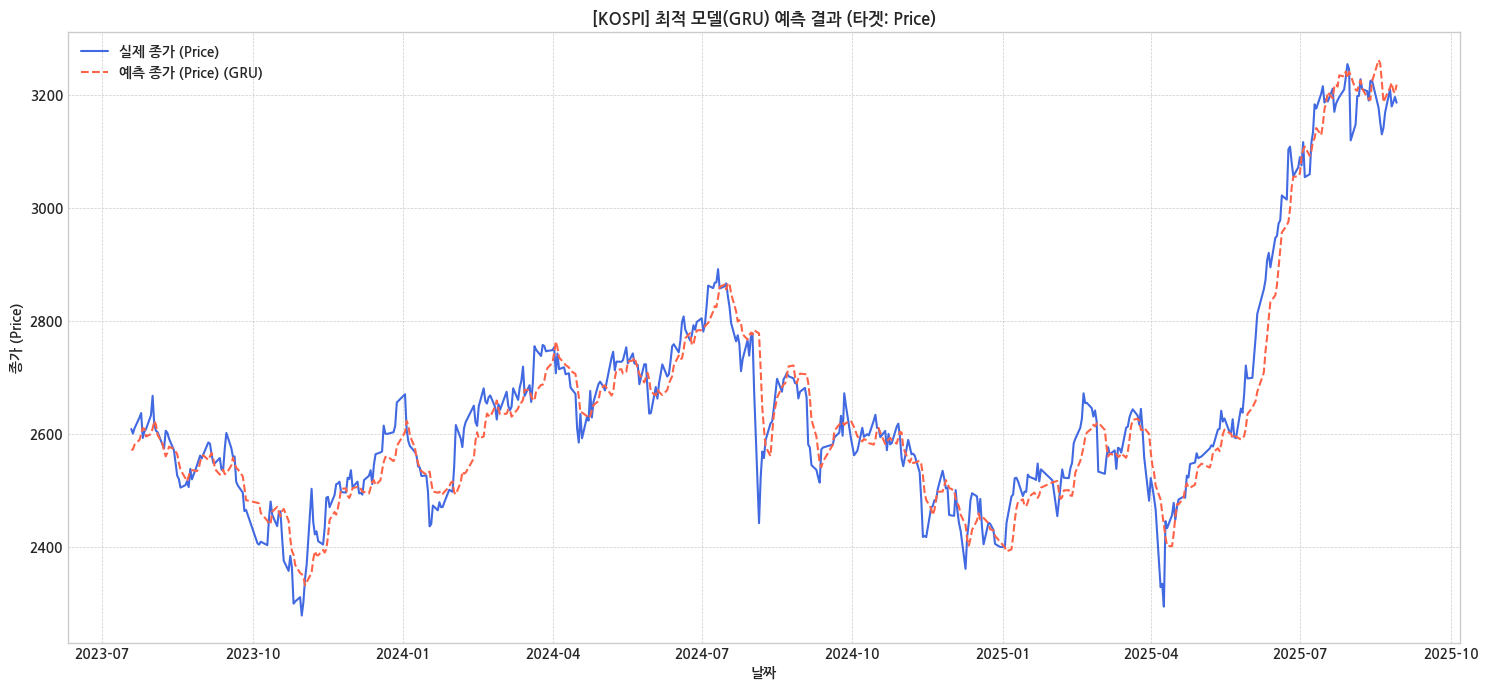

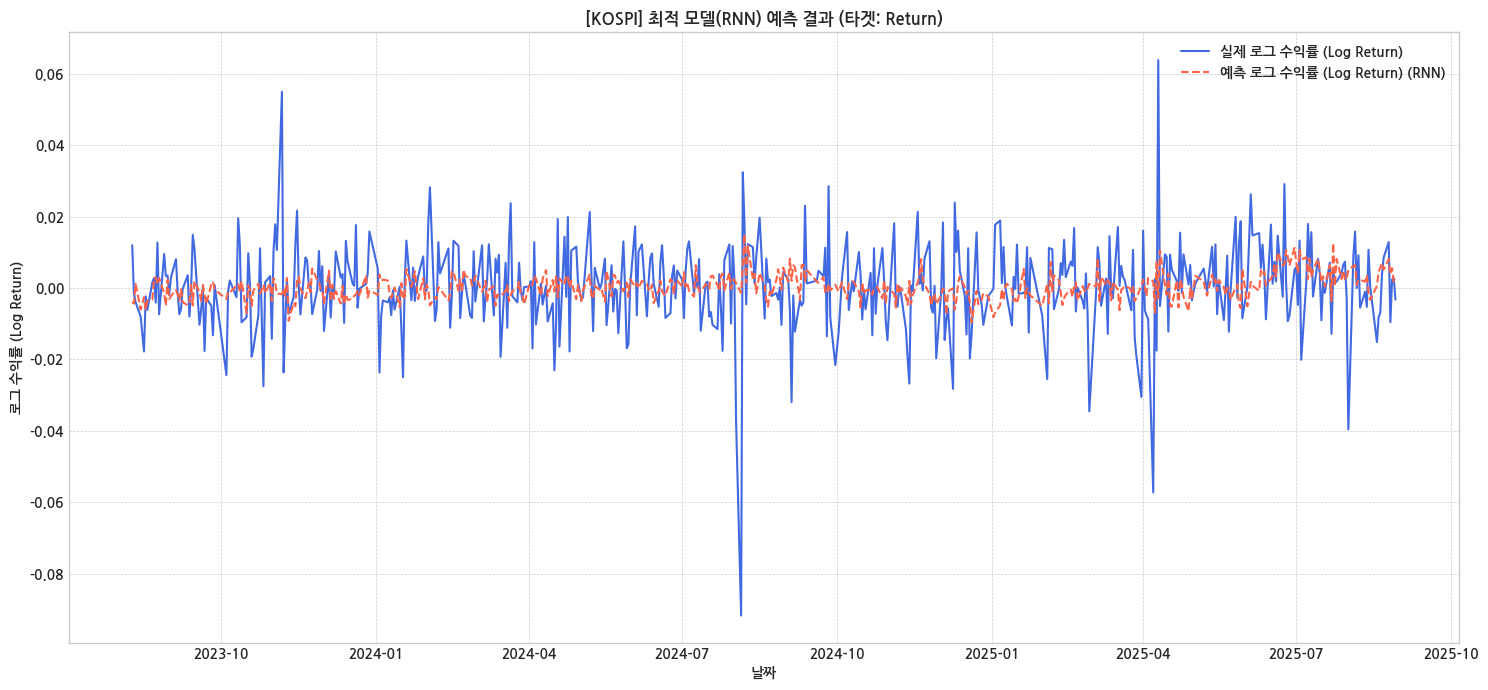

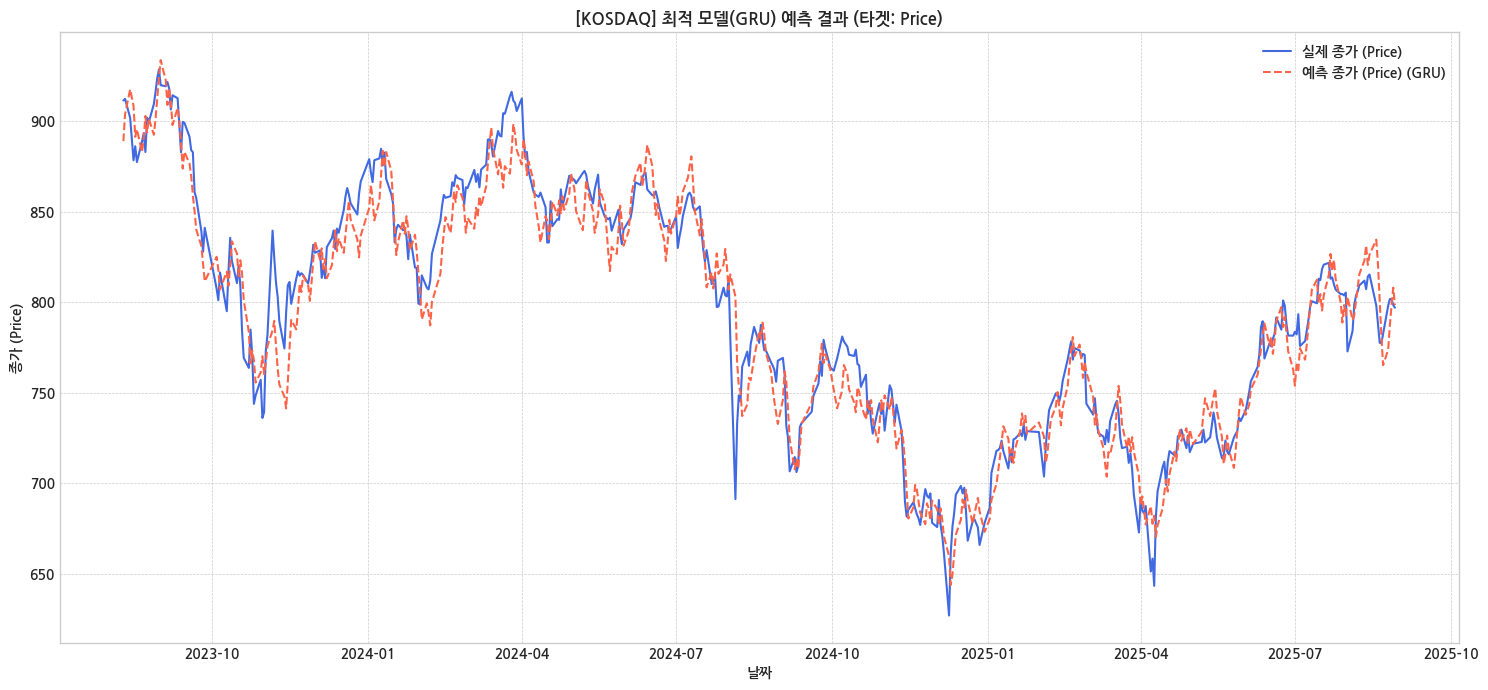

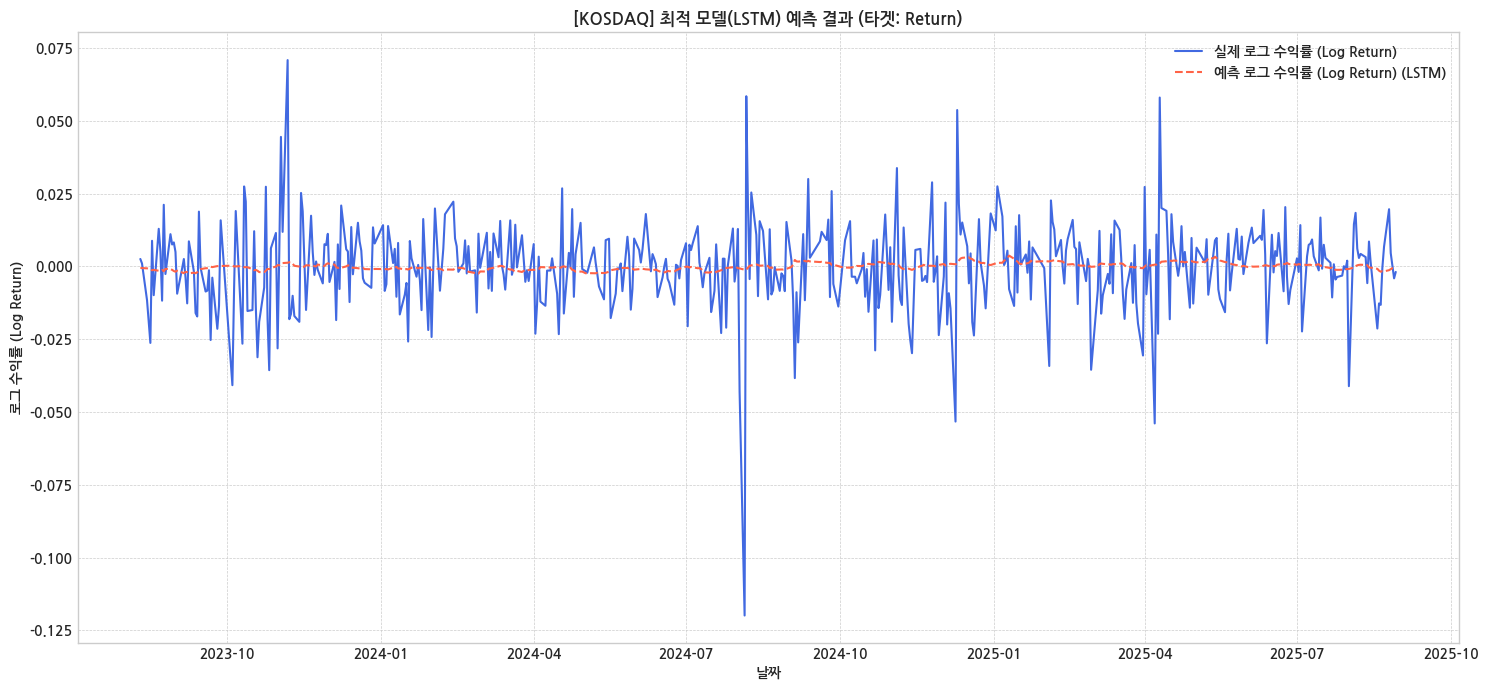

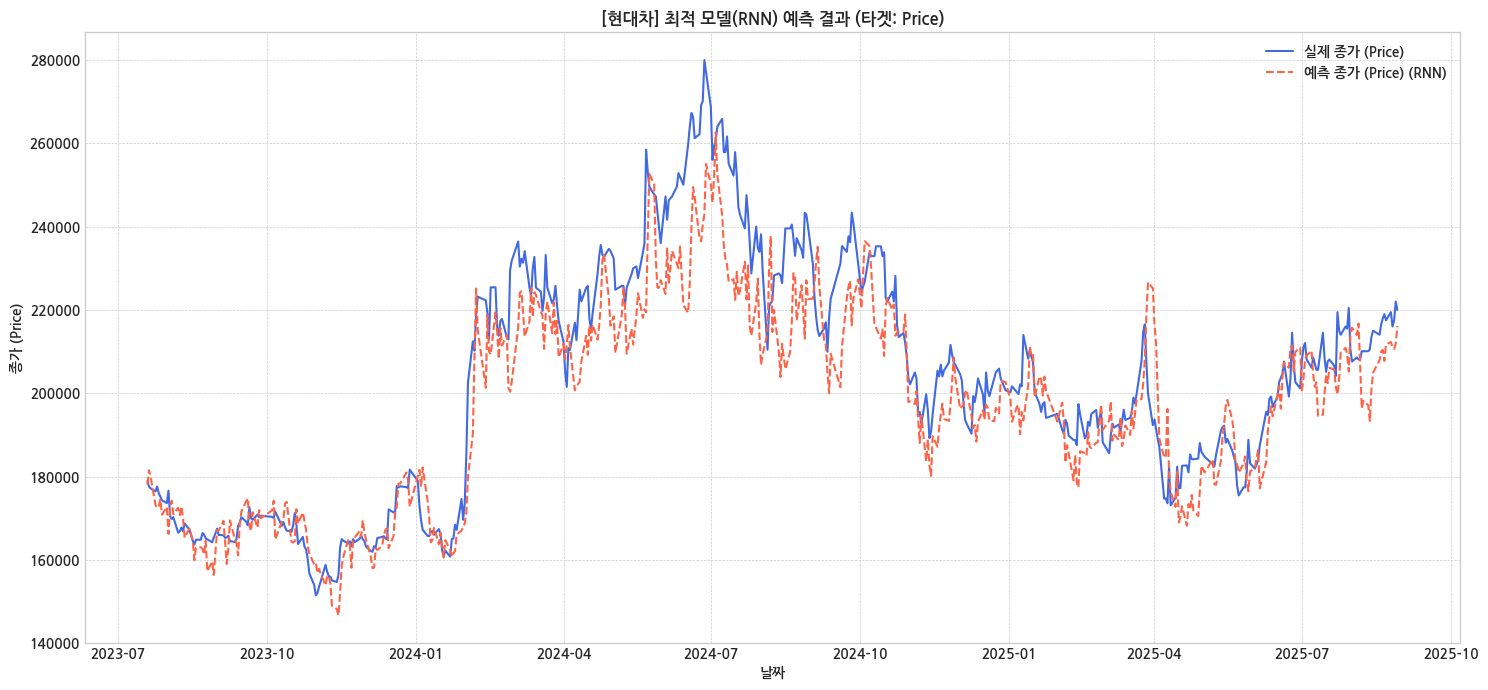

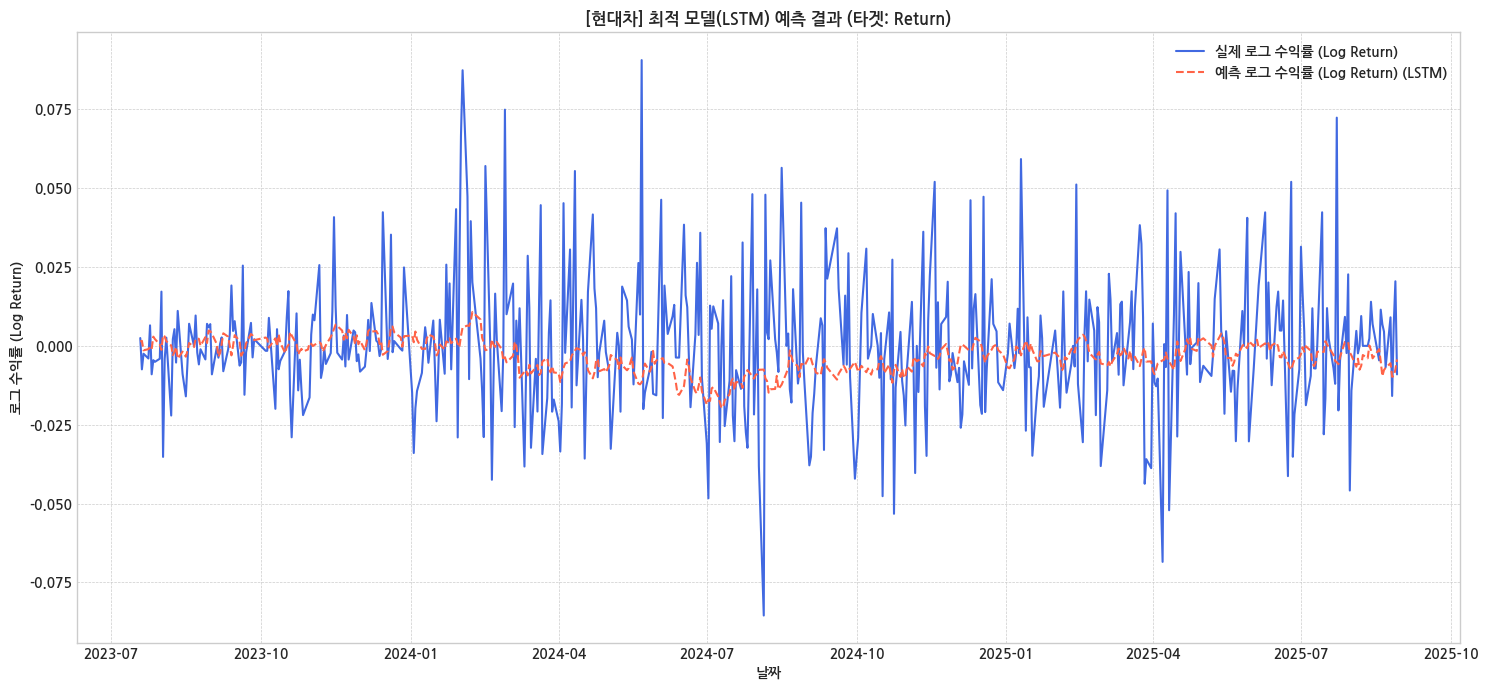


===== 섹션 6.3: 최적 회귀 모델 예측 시각화 (전체 조합) 완료 =====


In [70]:
# ==============================================================================
# 섹션 6.3: 최적 회귀 모델 예측 시각화 (최종 수정본)
# ==============================================================================
print("===== 섹션 6.3: 최적 회귀 모델 예측 시각화 (최종 수정) 시작 =====")

import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 한글 폰트 설정 (이전과 동일) ---
# ... (이전의 폰트 설정 코드가 실행되었다고 가정) ...


# --- 2. [수정] 최적 회귀 모델을 찾아 시각화하는 함수 ---
def plot_best_regression_model(asset_name, target_type, results_df, split_data_dict, dataframes_dict, scalers_dict, base_params, device_name):
    print(f"\n--- [{asset_name} - {target_type}] 최적 모델 탐색 및 시각화 시작 ---")

    try:
        # [핵심 수정] 해당 과제에서 RMSE가 가장 낮은 최적 모델을 자동으로 선정
        candidates = results_df[
            (results_df['asset'] == asset_name) &
            (results_df['target_type'] == target_type)
        ]

        if candidates.empty or 'rmse' not in candidates.columns or candidates['rmse'].isnull().all():
            print("-> 해당 조합에 대한 유효한 결과가 없어 건너뜁니다.")
            return

        best_model_info = candidates.loc[candidates['rmse'].idxmin()]
        best_model_type = best_model_info['model_type']

        print(f"-> RMSE 기준 최적 모델({best_model_type})을 선정했습니다. (RMSE: {best_model_info['rmse']:.4f})")

        # --- 이하 로직은 선정된 best_model_type을 사용하여 이전과 동일하게 진행 ---
        target_feature = 'log_price' if target_type == 'Price' else 'log_return'
        best_L = int(best_model_info['best_L']); best_hidden_dim = int(best_model_info['best_hidden_dim'])
        best_num_layers = int(best_model_info['best_num_layers']); best_dropout = best_model_info['best_dropout']

        features = split_data_dict[asset_name]['features']; target_idx = features.index(target_feature)
        train_data, val_data, test_data = split_data_dict[asset_name]['train'], split_data_dict[asset_name]['val'], split_data_dict[asset_name]['test']

        train_ds = TimeSeriesDataset(train_data, best_L, target_idx); val_ds = TimeSeriesDataset(val_data, best_L, target_idx)
        train_loader = DataLoader(train_ds, batch_size=base_params['batch_size'], shuffle=True); val_loader = DataLoader(val_ds, batch_size=base_params['batch_size'], shuffle=False)

        model = FinancialForecastingModel(
            input_dim=train_data.shape[1], hidden_dim=best_hidden_dim, num_layers=best_num_layers,
            dropout=best_dropout, model_type=best_model_type, target_type=target_type
        ).to(device_name)

        run_params = {'learning_rate': base_params['learning_rate'], 'weight_decay': base_params['weight_decay'], 'epochs': base_params['epochs'], 'patience': base_params['patience']}
        trained_model, _ = run_experiment(model, train_loader, val_loader, **run_params)

        test_ds = TimeSeriesDataset(test_data, best_L, target_idx); test_loader = DataLoader(test_ds, batch_size=base_params['batch_size'], shuffle=False)

        trained_model.eval(); preds_scaled, actuals_scaled = [], []
        with torch.no_grad():
            for x, y in test_loader:
                preds, _ = trained_model(x.to(device_name))
                preds_scaled.extend(preds.cpu().numpy()); actuals_scaled.extend(y.cpu().numpy())

        scaler = scalers_dict[asset_name]; num_features = len(features)
        dummy_preds = np.zeros((len(preds_scaled), num_features)); dummy_preds[:, target_idx] = preds_scaled
        preds_original_scale = scaler.inverse_transform(dummy_preds)[:, target_idx]
        dummy_actuals = np.zeros((len(actuals_scaled), num_features)); dummy_actuals[:, target_idx] = actuals_scaled
        actuals_original_scale = scaler.inverse_transform(dummy_actuals)[:, target_idx]

        if target_type == 'Price':
            preds_final, actuals_final, y_label = np.exp(preds_original_scale), np.exp(actuals_original_scale), '종가 (Price)'
        else: # 'Return'
            preds_final, actuals_final, y_label = preds_original_scale, actuals_original_scale, '로그 수익률 (Log Return)'

        train_size = len(split_data_dict[asset_name]['train']); val_size = len(split_data_dict[asset_name]['val'])
        test_dates = dataframes_dict[asset_name].iloc[train_size + val_size + best_L:].index

        plt.figure(figsize=(15, 7))
        plt.plot(test_dates, actuals_final, label=f'실제 {y_label}', color='royalblue')
        plt.plot(test_dates, preds_final, label=f'예측 {y_label} ({best_model_type})', color='tomato', linestyle='--')
        plt.title(f'[{asset_name}] 최적 모델({best_model_type}) 예측 결과 (타겟: {target_type})')
        plt.xlabel('날짜'); plt.ylabel(y_label); plt.legend(); plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout()

        filename = f'best_prediction_{asset_name}_{target_type}.png'
        plt.savefig(filename)
        print(f"-> ✅ '{filename}' 파일로 그래프 저장 완료.")
    except Exception as e:
        print(f"-> ❌ 시각화 중 오류 발생: {e}")


# --- [수정] 모든 자산과 회귀 타겟에 대해 반복 실행 ---
try:
    if 'base_hyperparams' not in locals():
        base_hyperparams = fixed_hyperparams.copy()

    assets_to_plot = ['KOSPI', 'KOSDAQ', '현대차']
    targets_to_plot = ['Price', 'Return'] # 회귀 타겟만 지정

    # 모든 조합에 대해 함수를 반복 호출
    for asset in assets_to_plot:
        for target in targets_to_plot:
            plot_best_regression_model(
                asset_name=asset,
                target_type=target,
                results_df=optimized_results_df,
                split_data_dict=split_data,
                dataframes_dict=dataframes,
                scalers_dict=scalers,
                base_params=base_hyperparams,
                device_name=device
            )

    print("\n\n--- 모든 그래프 생성 완료 ---")
    plt.show()

except NameError as e:
    print(f"⚠️ 오류: 필요한 변수를 찾을 수 없습니다 ({e}). 이전 섹션들을 모두 실행했는지 확인해주세요.")
except Exception as e:
    print(f"⚠️ 전체 실행 중 오류가 발생했습니다: {e}")

print("\n===== 섹션 6.3: 최적 회귀 모델 예측 시각화 (전체 조합) 완료 =====")



 'Up/Down' 타겟을 시각화하지 않는 이유

'Up/Down' 타겟에 대해 이 시각화를 하지 않는 이유는 **분석의 목적과 데이터의 형태가 다르기 때문**입니다.

1.  **데이터 형태의 차이**:

      * **Price/Return**: 예측값과 실제값이 모두 **연속적인 숫자**입니다. 따라서 시간에 따른 두 숫자의 흐름을 선 그래프로 비교하는 것이 매우 효과적입니다.
      * **Up/Down**: 예측값과 실제값이 모두 **0 또는 1이라는 이산적인 값**입니다. 이를 선 그래프로 그리면 의미를 파악하기 어려운 디지털 신호처럼 보이게 됩니다.

2.  **분석 목적의 차이**:

      * **6.3의 목적**: 회귀 모델이 실제 값의 **추세와 규모**를 얼마나 잘 따라가는지 시각적으로 확인하는 것입니다.
      * **'Up/Down' 모델의 목적**: 방향을 얼마나 잘 맞추었는지, 그리고 그 결정이 **어떤 투자 결과로 이어졌는지**를 확인하는 것입니다.

따라서 'Up/Down' 모델의 성능을 가장 잘 시각화하는 방법은, 우리가 \*\*섹션 6.4에서 수행했던 '누적 수익률' 그래프(백테스팅)\*\*입니다. 이 그래프가 Up/Down 예측의 실용적인 결과를 가장 잘 보여주는 맞춤형 시각화 방식입니다.

### 섹션 6.4: 누적 전략성과

===== 섹션 6.4: 상세 투자 성과 분석 (최종 완성본 - 수정판) 시작 =====

==================== [KOSPI] 백테스트 시작 ====================
-> 최적 모델(RNN)을 F1-Score 기준으로 선정 (F1: 0.2291, Acc: 0.4641)
BCE Loss: pos_weight = 0.83
--- Experiment Start: RNN for Up/Down ---
Epoch 1/50 | Train Loss: 0.6683 | Val Loss: 0.6472 
Epoch 2/50 | Train Loss: 0.6416 | Val Loss: 0.6312 
Epoch 3/50 | Train Loss: 0.6409 | Val Loss: 0.6315 
Epoch 4/50 | Train Loss: 0.6314 | Val Loss: 0.6253 
Epoch 5/50 | Train Loss: 0.6312 | Val Loss: 0.6293 
Epoch 6/50 | Train Loss: 0.6354 | Val Loss: 0.6249 
Epoch 7/50 | Train Loss: 0.6339 | Val Loss: 0.6311 
Epoch 8/50 | Train Loss: 0.6360 | Val Loss: 0.6274 
Epoch 9/50 | Train Loss: 0.6402 | Val Loss: 0.6281 
Epoch 10/50 | Train Loss: 0.6409 | Val Loss: 0.6289 
Epoch 11/50 | Train Loss: 0.6307 | Val Loss: 0.6272 
Epoch 12/50 | Train Loss: 0.6346 | Val Loss: 0.6285 
Epoch 13/50 | Train Loss: 0.6315 | Val Loss: 0.6308 
Epoch 14/50 | Train Loss: 0.6291 | Val Loss: 0.6266 
Epoch 15/50 | Train Loss: 0.63

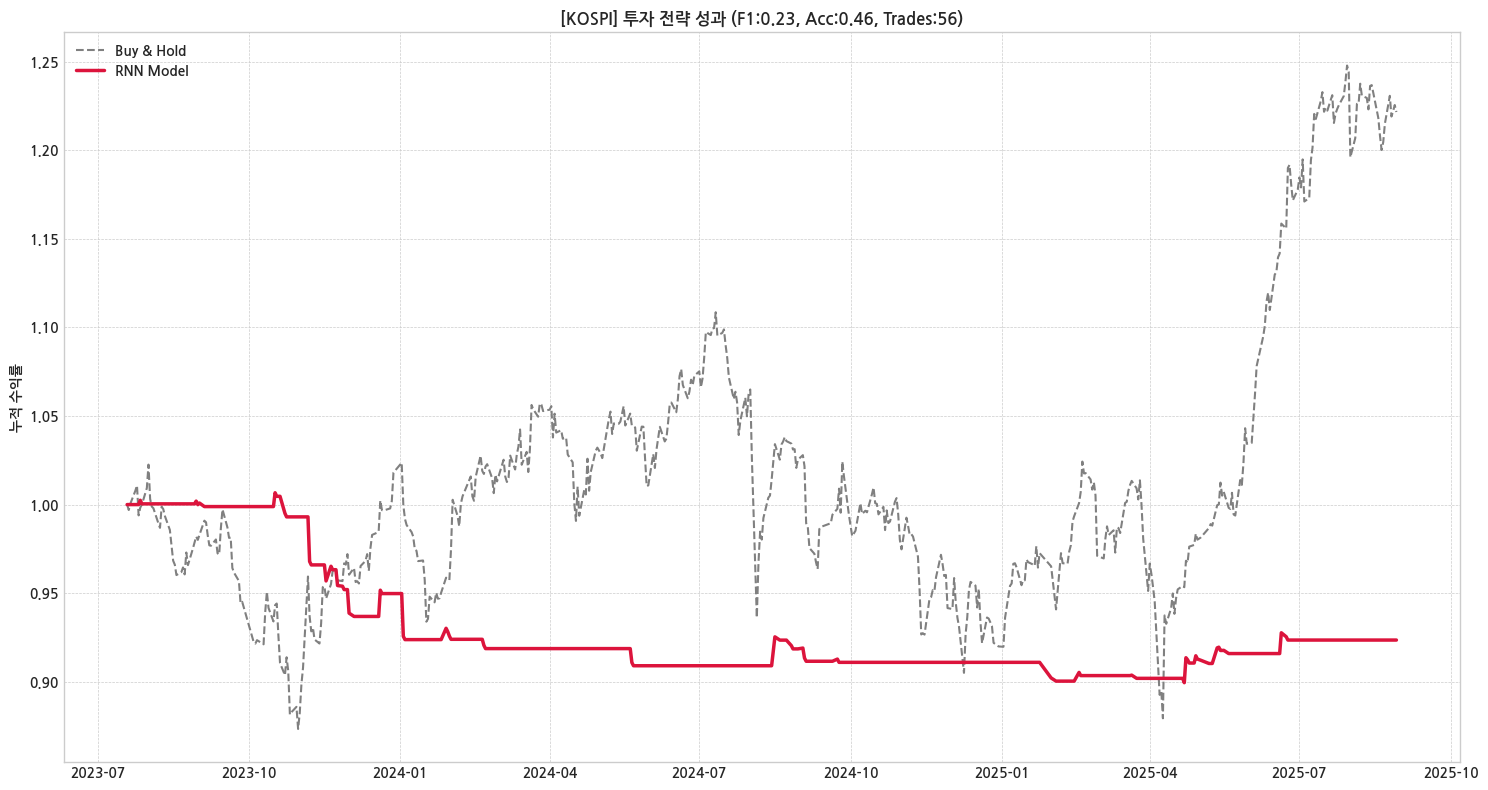

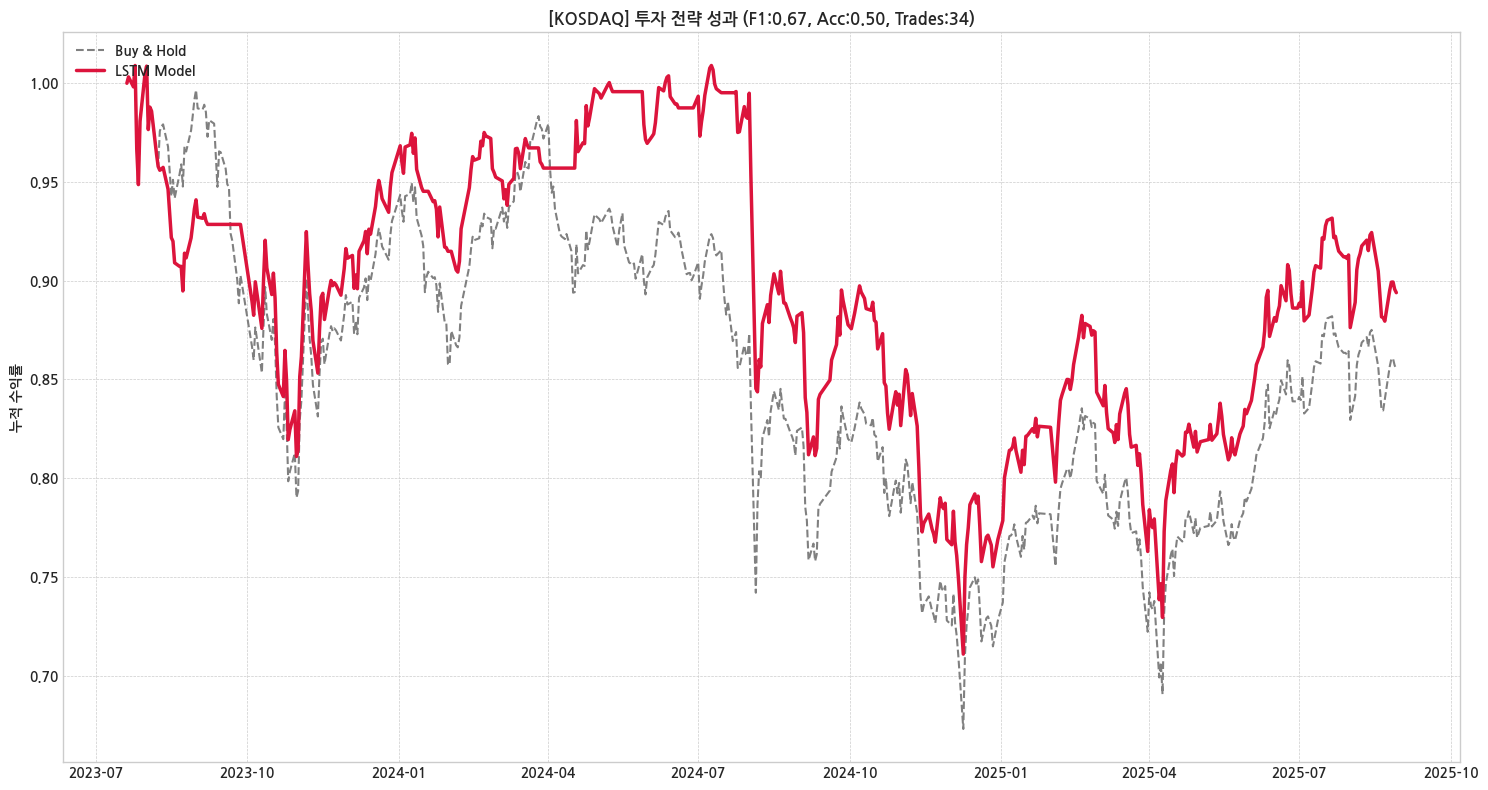

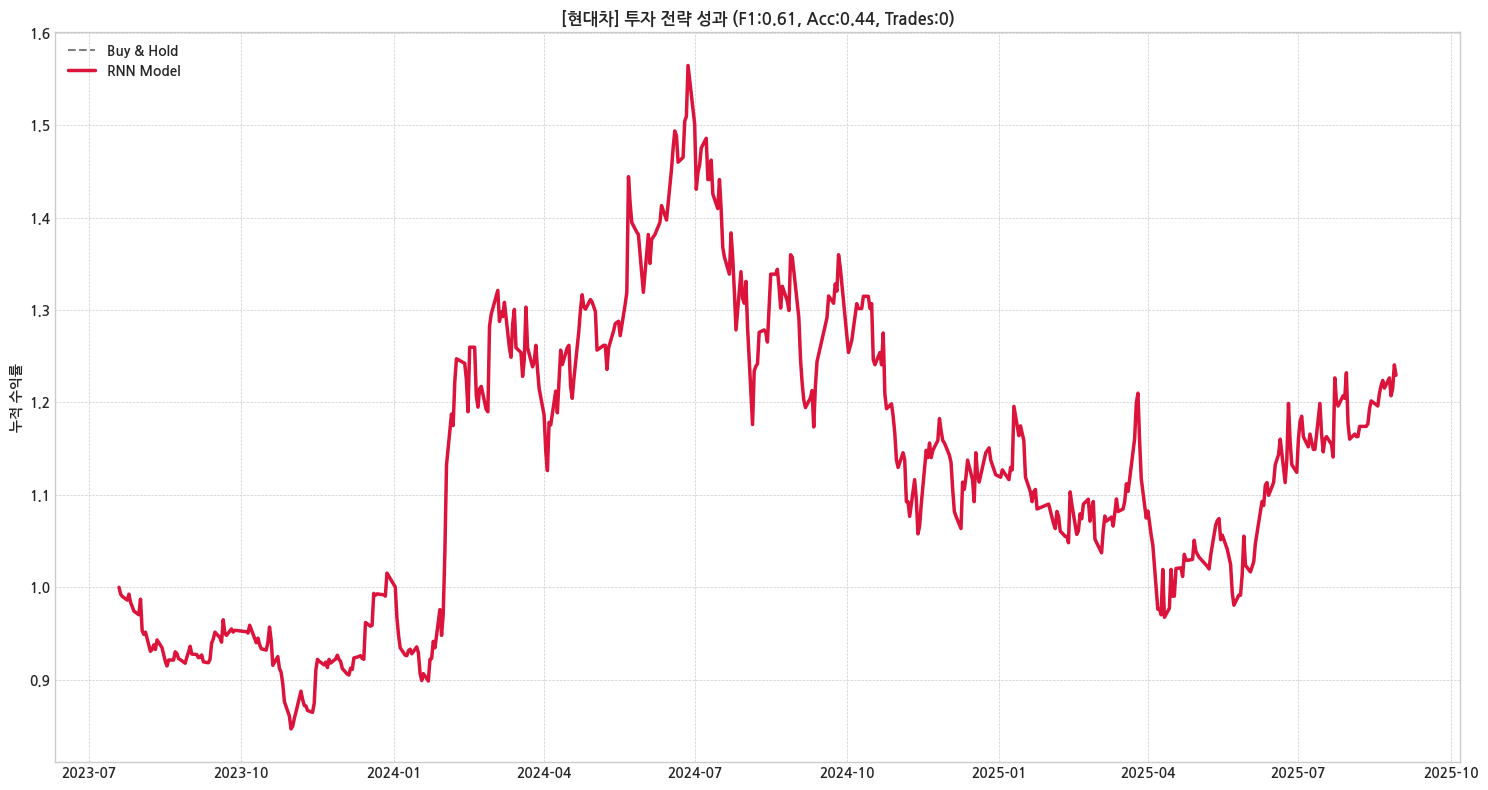


===== 섹션 6.4: 상세 투자 성과 분석 (최종 완성본 - 수정판) 완료 =====


In [71]:
# ==============================================================================
# 섹션 6.4: 상세 투자 성과 분석 (최종 완성본 - 수정판)
# ==============================================================================
print("===== 섹션 6.4: 상세 투자 성과 분석 (최종 완성본 - 수정판) 시작 =====")

import pandas as pd
import numpy as np

# --- 1. 성과 지표 계산 헬퍼 함수 (이전과 동일) ---
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    trading_days = 252
    daily_returns = returns.dropna()
    if len(daily_returns) < 2 or daily_returns.std() == 0: return 0
    sharpe_ratio = (daily_returns.mean() - risk_free_rate / trading_days) / daily_returns.std()
    return sharpe_ratio * np.sqrt(trading_days)

def calculate_mdd(cumulative_returns):
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# --- 2. 자산별 백테스트를 수행하는 메인 함수 (최종 수정) ---
def run_final_backtest_revised(asset_name, results_df, split_data_dict, dataframes_dict, base_params, device_name):
    print(f"\n{'='*20} [{asset_name}] 백테스트 시작 {'='*20}")

    try:
        # 2-1. 최적 Up/Down 모델 선정
        candidates = results_df[(results_df['asset'] == asset_name) & (results_df['target_type'] == 'Up/Down')]
        if candidates.empty:
            print(f"-> '{asset_name}'에 대한 Up/Down 예측 결과가 없어 건너뜁니다.")
            return None

        best_model_info = candidates.loc[candidates['f1'].idxmax()]
        model_type = best_model_info['model_type']
        f1_score = best_model_info['f1']
        accuracy = best_model_info['accuracy']

        print(f"-> 최적 모델({model_type})을 F1-Score 기준으로 선정 (F1: {f1_score:.4f}, Acc: {accuracy:.4f})")

        # [수정] 최소 성능 기준(Threshold) 제거 - 모든 모델을 테스트하도록 변경

        # 2-2. 모델 재학습 및 트레이딩 신호 생성
        best_L = int(best_model_info['best_L']); best_hidden_dim = int(best_model_info['best_hidden_dim'])
        best_num_layers = int(best_model_info['best_num_layers']); best_dropout = best_model_info['best_dropout']
        features = split_data_dict[asset_name]['features']; target_idx = features.index('up_down')
        train_data, val_data, test_data = split_data_dict[asset_name]['train'], split_data_dict[asset_name]['val'], split_data_dict[asset_name]['test']
        train_ds = TimeSeriesDataset(train_data, best_L, target_idx); val_ds = TimeSeriesDataset(val_data, best_L, target_idx)
        train_loader = DataLoader(train_ds, batch_size=base_params['batch_size'], shuffle=True); val_loader = DataLoader(val_ds, batch_size=base_params['batch_size'], shuffle=False)
        model = FinancialForecastingModel(input_dim=train_data.shape[1], hidden_dim=best_hidden_dim, num_layers=best_num_layers, dropout=best_dropout, model_type=model_type, target_type='Up/Down').to(device_name)
        run_params = {'learning_rate': base_params['learning_rate'], 'weight_decay': base_params['weight_decay'], 'epochs': base_params['epochs'], 'patience': base_params['patience']}
        trained_model, _ = run_experiment(model, train_loader, val_loader, **run_params)
        test_ds = TimeSeriesDataset(test_data, best_L, target_idx); test_loader = DataLoader(test_ds, batch_size=base_params['batch_size'], shuffle=False)
        all_logits = [];
        with torch.no_grad():
            for x, _ in test_loader: logits, _ = trained_model(x.to(device_name)); all_logits.extend(logits.cpu().numpy())
        probs = 1 / (1 + np.exp(-np.array(all_logits))); trading_signals = (probs > 0.5).astype(int)

        # 2-3. 수익률 계산 및 거래비용 반영
        train_size = len(split_data_dict[asset_name]['train']); val_size = len(split_data_dict[asset_name]['val'])
        test_dates = dataframes_dict[asset_name].iloc[train_size + val_size + best_L:].index
        original_test_df = dataframes_dict[asset_name].loc[test_dates]
        simple_returns = original_test_df['Close'].pct_change().fillna(0)

        if len(trading_signals) > len(simple_returns): trading_signals = trading_signals[:len(simple_returns)]

        transaction_cost_rate = 0.002
        trades = pd.Series(trading_signals, index=simple_returns.index).diff().abs().fillna(0)
        num_trades = trades.sum()

        buy_and_hold_returns = simple_returns.copy()
        model_strategy_returns = (simple_returns * trading_signals) - (trades * transaction_cost_rate)

        # 2-4. 성과 지표 계산 및 시각화
        cum_bh = (1 + buy_and_hold_returns).cumprod(); cum_model = (1 + model_strategy_returns).cumprod()

        plt.figure(figsize=(15, 8))
        plt.plot(cum_bh.index, cum_bh, label='Buy & Hold', color='gray', linestyle='--'); plt.plot(cum_model.index, cum_model, label=f'{model_type} Model', color='crimson', linewidth=2.5)
        plt.title(f'[{asset_name}] 투자 전략 성과 (F1:{f1_score:.2f}, Acc:{accuracy:.2f}, Trades:{int(num_trades)})')
        plt.ylabel('누적 수익률'); plt.legend(loc='upper left'); plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout()
        plt.savefig(f'final_strategy_{asset_name}.png')
        print(f"-> ✅ '{asset_name}'의 백테스트 그래프를 저장했습니다.")

        return {
            'Asset': asset_name, 'Model': model_type, 'F1-Score': f1_score, 'Accuracy': accuracy,
            'Strategy': 'Model Strategy', 'Final Return': cum_model.iloc[-1],
            'Sharpe Ratio': calculate_sharpe_ratio(model_strategy_returns), 'MDD (%)': calculate_mdd(cum_model) * 100
        }, {
            'Asset': asset_name, 'Model': '-', 'F1-Score': np.nan, 'Accuracy': np.nan, # NaN으로 변경
            'Strategy': 'Buy & Hold', 'Final Return': cum_bh.iloc[-1],
            'Sharpe Ratio': calculate_sharpe_ratio(buy_and_hold_returns), 'MDD (%)': calculate_mdd(cum_bh) * 100
        }

    except Exception as e:
        print(f"-> ❌ [{asset_name}] 백테스트 중 오류 발생: {e}")
        return None

# --- 3. [실행] 모든 자산에 대해 백테스트 자동 실행 ---
try:
    final_results_list = []
    assets_to_backtest = ['KOSPI', 'KOSDAQ', '현대차']

    for asset in assets_to_backtest:
        results = run_final_backtest_revised(asset, optimized_results_df, split_data, dataframes, base_hyperparams, device)
        if results:
            final_results_list.append(results[0])
            final_results_list.append(results[1])

    if final_results_list:
        final_summary_df = pd.DataFrame(final_results_list).set_index(['Asset', 'Strategy'])

        # [수정] 특정 숫자 열에만 포매터를 적용하여 ValueError 방지
        formatter = {
            'F1-Score': "{:.4f}", 'Accuracy': "{:.4f}",
            'Final Return': "{:.4f}", 'Sharpe Ratio': "{:.4f}", 'MDD (%)': "{:.4f}"
        }

        print("\n\n" + "="*25 + " 최종 종합 결과 " + "="*25)
        print("모든 자산에 대한 상세 투자 성과 요약 테이블입니다.")
        display(final_summary_df.style.format(formatter, na_rep="-"))
    else:
        print("\n\n" + "="*25 + " 최종 종합 결과 " + "="*25)
        print("백테스트를 실행할 모델을 찾지 못했습니다.")

    plt.show()

except Exception as e:
    print(f"⚠️ 전체 실행 중 오류가 발생했습니다: {e}")

print("\n===== 섹션 6.4: 상세 투자 성과 분석 (최종 완성본 - 수정판) 완료 =====")

===== 섹션 6.4: 최종 투자 성과 분석 (AUPRC 기준) 시작 =====

==================== [KOSPI] 백테스트 시작 ====================
-> 최적 모델(LSTM)을 AUPRC 기준으로 선정 (AUPRC: 0.5506, F1: 0.0000)
BCE Loss: pos_weight = 0.83
--- Experiment Start: LSTM for Up/Down ---
Epoch 1/50 | Train Loss: 0.6335 | Val Loss: 0.6304 
Epoch 2/50 | Train Loss: 0.6310 | Val Loss: 0.6318 
Epoch 3/50 | Train Loss: 0.6307 | Val Loss: 0.6340 
Epoch 4/50 | Train Loss: 0.6301 | Val Loss: 0.6343 
Epoch 5/50 | Train Loss: 0.6302 | Val Loss: 0.6345 
Epoch 6/50 | Train Loss: 0.6294 | Val Loss: 0.6333 
Epoch 7/50 | Train Loss: 0.6290 | Val Loss: 0.6337 
Epoch 8/50 | Train Loss: 0.6283 | Val Loss: 0.6344 
Epoch 9/50 | Train Loss: 0.6287 | Val Loss: 0.6358 
Epoch 10/50 | Train Loss: 0.6289 | Val Loss: 0.6356 
Epoch 11/50 | Train Loss: 0.6298 | Val Loss: 0.6351 
Early stopping at epoch 11
-> ✅ 'KOSPI'의 백테스트 그래프를 저장했습니다.

==================== [KOSDAQ] 백테스트 시작 ====================
-> 최적 모델(LSTM)을 AUPRC 기준으로 선정 (AUPRC: 0.5051, F1: 0.6701)
BCE Loss: pos_w

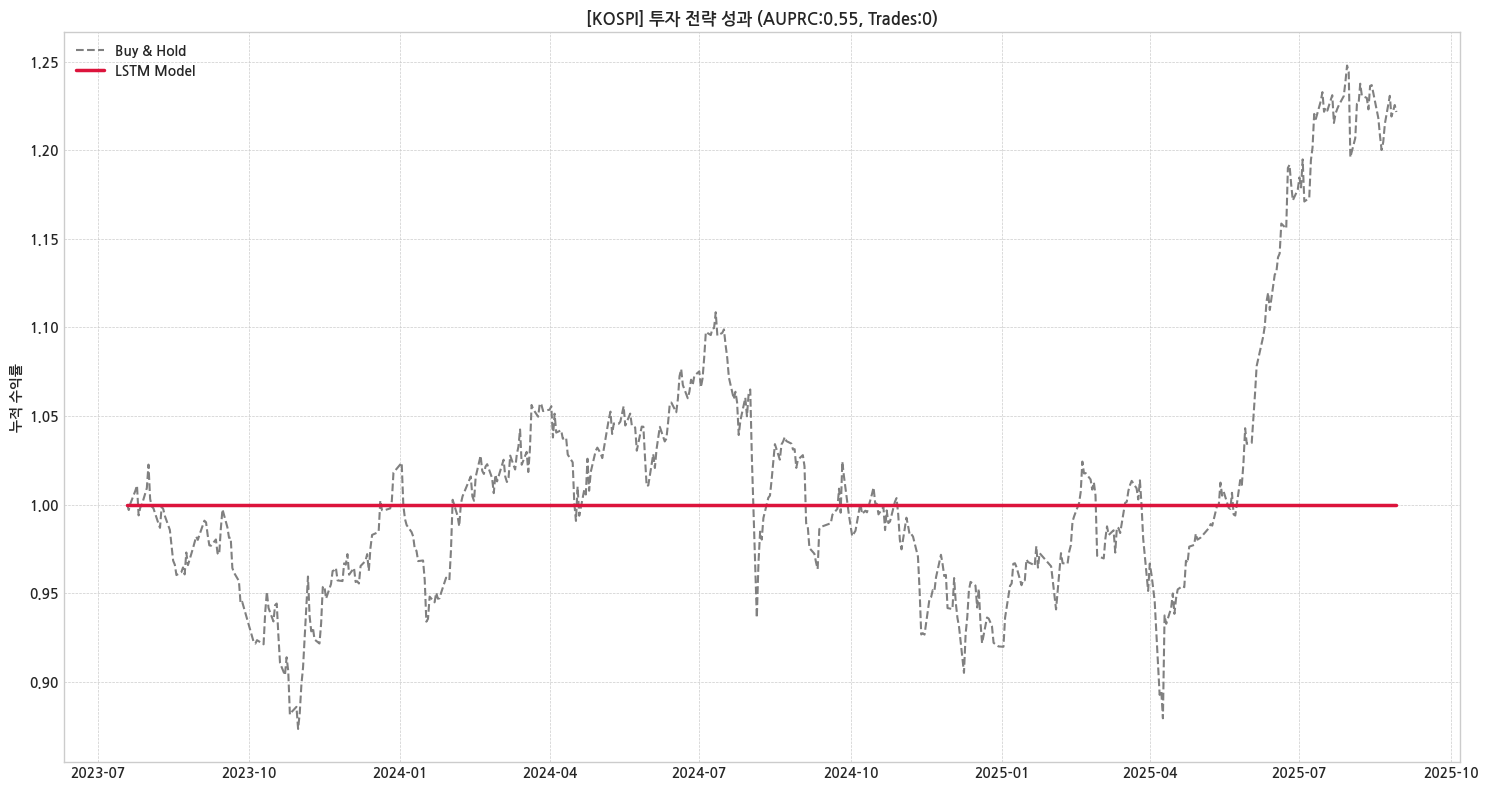

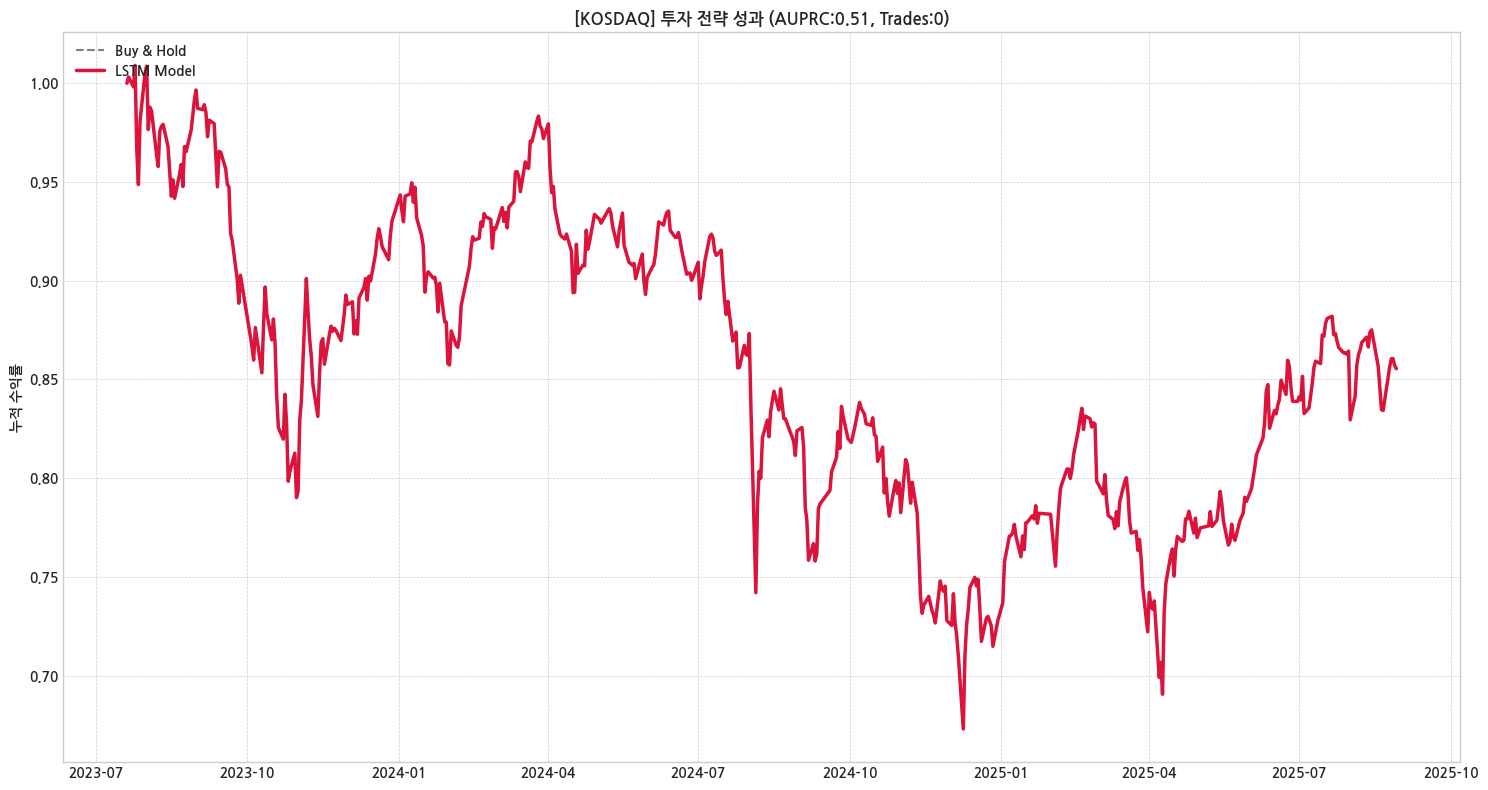

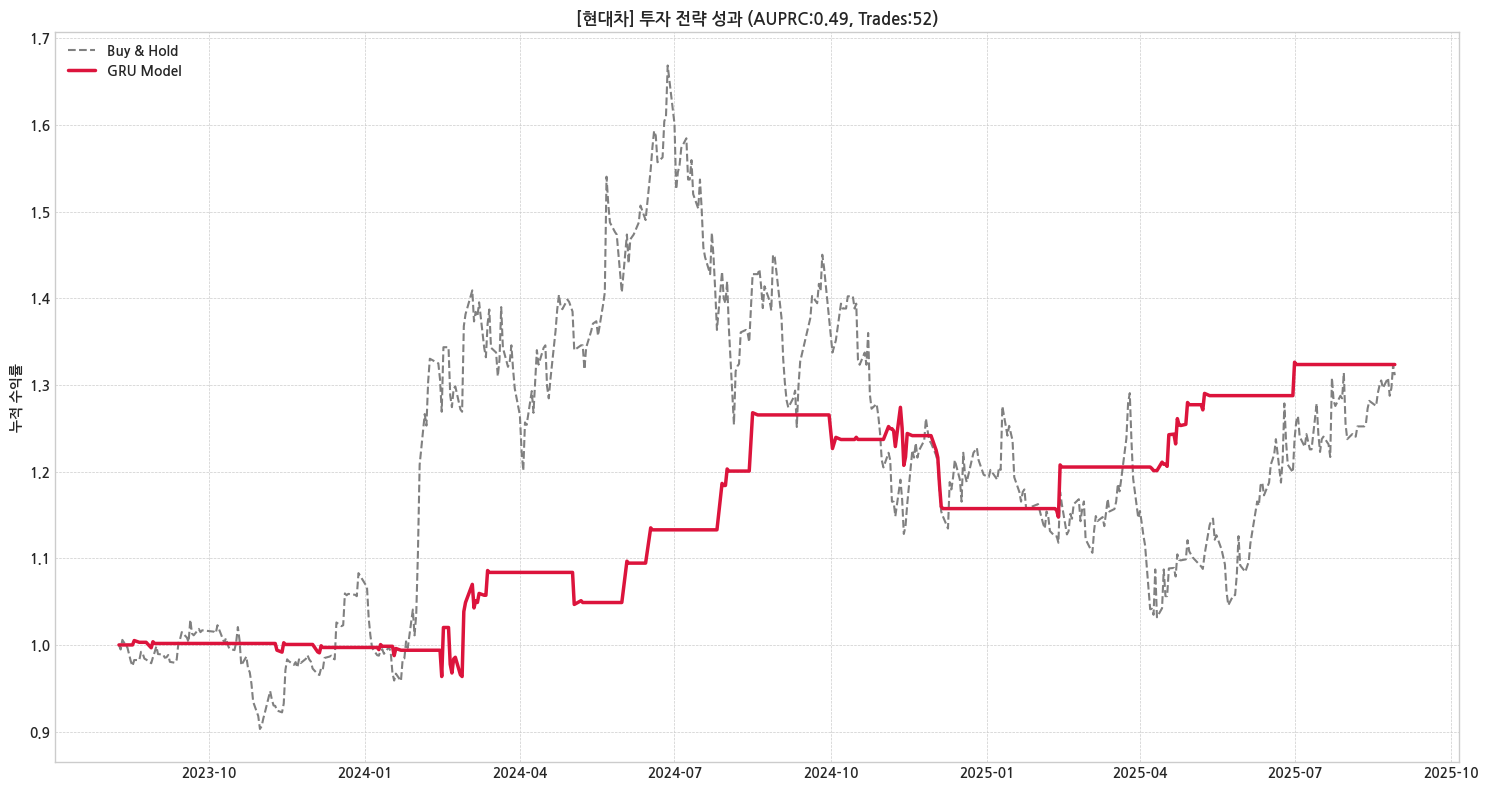


===== 섹션 6.4: 최종 투자 성과 분석 (AUPRC 기준) 완료 =====


In [72]:
# ==============================================================================
# 섹션 6.4: 최종 투자 성과 분석 (AUPRC 기준)
# ==============================================================================
print("===== 섹션 6.4: 최종 투자 성과 분석 (AUPRC 기준) 시작 =====")

import pandas as pd
import numpy as np

# --- 1. 성과 지표 계산 헬퍼 함수 (이전과 동일) ---
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    trading_days = 252
    daily_returns = returns.dropna()
    if len(daily_returns) < 2 or daily_returns.std() == 0: return 0
    sharpe_ratio = (daily_returns.mean() - risk_free_rate / trading_days) / daily_returns.std()
    return sharpe_ratio * np.sqrt(trading_days)

def calculate_mdd(cumulative_returns):
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# --- 2. 자산별 백테스트를 수행하는 메인 함수 (AUPRC 기준 선정) ---
def run_backtest_with_auprc(asset_name, results_df, split_data_dict, dataframes_dict, base_params, device_name):
    print(f"\n{'='*20} [{asset_name}] 백테스트 시작 {'='*20}")

    try:
        # 2-1. 최적 Up/Down 모델 선정 (AUPRC 기준)
        candidates = results_df[(results_df['asset'] == asset_name) & (results_df['target_type'] == 'Up/Down')]
        if candidates.empty or 'auprc' not in candidates.columns or candidates['auprc'].isnull().all():
            print(f"-> '{asset_name}'에 대한 유효한 AUPRC 결과가 없어 건너뜁니다.")
            return None

        # [핵심 변경] AUPRC 점수가 가장 높은 모델을 선택
        best_model_info = candidates.loc[candidates['auprc'].idxmax()]
        model_type = best_model_info['model_type']
        auprc = best_model_info['auprc']
        f1_score = best_model_info['f1']
        accuracy = best_model_info['accuracy']

        print(f"-> 최적 모델({model_type})을 AUPRC 기준으로 선정 (AUPRC: {auprc:.4f}, F1: {f1_score:.4f})")

        # 2-2. 모델 재학습 및 트레이딩 신호 생성
        best_L = int(best_model_info['best_L']); best_hidden_dim = int(best_model_info['best_hidden_dim'])
        best_num_layers = int(best_model_info['best_num_layers']); best_dropout = best_model_info['best_dropout']
        features = split_data_dict[asset_name]['features']; target_idx = features.index('up_down')
        train_data, val_data, test_data = split_data_dict[asset_name]['train'], split_data_dict[asset_name]['val'], split_data_dict[asset_name]['test']
        train_ds = TimeSeriesDataset(train_data, best_L, target_idx); val_ds = TimeSeriesDataset(val_data, best_L, target_idx)
        train_loader = DataLoader(train_ds, batch_size=base_params['batch_size'], shuffle=True); val_loader = DataLoader(val_ds, batch_size=base_params['batch_size'], shuffle=False)
        model = FinancialForecastingModel(input_dim=train_data.shape[1], hidden_dim=best_hidden_dim, num_layers=best_num_layers, dropout=best_dropout, model_type=model_type, target_type='Up/Down').to(device_name)
        run_params = {'learning_rate': base_params['learning_rate'], 'weight_decay': base_params['weight_decay'], 'epochs': base_params['epochs'], 'patience': base_params['patience']}
        trained_model, _ = run_experiment(model, train_loader, val_loader, **run_params)
        test_ds = TimeSeriesDataset(test_data, best_L, target_idx); test_loader = DataLoader(test_ds, batch_size=base_params['batch_size'], shuffle=False)
        all_logits = [];
        with torch.no_grad():
            for x, _ in test_loader: logits, _ = trained_model(x.to(device_name)); all_logits.extend(logits.cpu().numpy())
        probs = 1 / (1 + np.exp(-np.array(all_logits))); trading_signals = (probs > 0.5).astype(int)

        # 2-3. 수익률 계산 및 거래비용 반영
        train_size = len(split_data_dict[asset_name]['train']); val_size = len(split_data_dict[asset_name]['val'])
        test_dates = dataframes_dict[asset_name].iloc[train_size + val_size + best_L:].index
        original_test_df = dataframes_dict[asset_name].loc[test_dates]
        simple_returns = original_test_df['Close'].pct_change().fillna(0)

        if len(trading_signals) > len(simple_returns): trading_signals = trading_signals[:len(simple_returns)]

        transaction_cost_rate = 0.002
        trades = pd.Series(trading_signals, index=simple_returns.index).diff().abs().fillna(0)
        num_trades = trades.sum()

        buy_and_hold_returns = simple_returns.copy()
        model_strategy_returns = (simple_returns * trading_signals) - (trades * transaction_cost_rate)

        # 2-4. 성과 지표 계산 및 시각화
        cum_bh = (1 + buy_and_hold_returns).cumprod(); cum_model = (1 + model_strategy_returns).cumprod()

        plt.figure(figsize=(15, 8))
        plt.plot(cum_bh.index, cum_bh, label='Buy & Hold', color='gray', linestyle='--'); plt.plot(cum_model.index, cum_model, label=f'{model_type} Model', color='crimson', linewidth=2.5)
        plt.title(f'[{asset_name}] 투자 전략 성과 (AUPRC:{auprc:.2f}, Trades:{int(num_trades)})')
        plt.ylabel('누적 수익률'); plt.legend(loc='upper left'); plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout()
        plt.savefig(f'final_strategy_{asset_name}_auprc.png')
        print(f"-> ✅ '{asset_name}'의 백테스트 그래프를 저장했습니다.")

        return {
            'Asset': asset_name, 'Model': model_type, 'AUPRC': auprc, 'F1-Score': f1_score, 'Accuracy': accuracy,
            'Strategy': 'Model Strategy', 'Final Return': cum_model.iloc[-1],
            'Sharpe Ratio': calculate_sharpe_ratio(model_strategy_returns), 'MDD (%)': calculate_mdd(cum_model) * 100
        }, {
            'Asset': asset_name, 'Model': '-', 'AUPRC': np.nan, 'F1-Score': np.nan, 'Accuracy': np.nan,
            'Strategy': 'Buy & Hold', 'Final Return': cum_bh.iloc[-1],
            'Sharpe Ratio': calculate_sharpe_ratio(buy_and_hold_returns), 'MDD (%)': calculate_mdd(cum_bh) * 100
        }

    except Exception as e:
        print(f"-> ❌ [{asset_name}] 백테스트 중 오류 발생: {e}")
        return None

# --- 3. [실행] 모든 자산에 대해 백테스트 자동 실행 ---
try:
    final_results_list = []
    assets_to_backtest = ['KOSPI', 'KOSDAQ', '현대차']

    for asset in assets_to_backtest:
        results = run_backtest_with_auprc(asset, optimized_results_df, split_data, dataframes, base_hyperparams, device)
        if results:
            final_results_list.append(results[0])
            final_results_list.append(results[1])

    if final_results_list:
        final_summary_df = pd.DataFrame(final_results_list).set_index(['Asset', 'Strategy'])
        formatter = {'AUPRC': "{:.4f}", 'F1-Score': "{:.4f}", 'Accuracy': "{:.4f}", 'Final Return': "{:.4f}", 'Sharpe Ratio': "{:.4f}", 'MDD (%)': "{:.4f}"}

        print("\n\n" + "="*25 + " 최종 종합 결과 (AUPRC 기준) " + "="*25)
        display(final_summary_df.style.format(formatter, na_rep="-"))
    else:
        print("\n\n" + "="*25 + " 최종 종합 결과 " + "="*25)
        print("백테스트를 실행할 모델을 찾지 못했습니다.")

    plt.show()

except Exception as e:
    print(f"⚠️ 전체 실행 중 오류가 발생했습니다: {e}")

print("\n===== 섹션 6.4: 최종 투자 성과 분석 (AUPRC 기준) 완료 =====")

===== 섹션 6.4: 최종 투자 성과 분석 (AUROC 기준 - 수정) 시작 =====

==================== [KOSPI] 백테스트 (선정 기준: AUROC) ====================
-> 최적 모델(LSTM)을 AUROC 기준으로 선정 (Score: 0.4964)
BCE Loss: pos_weight = 0.83
--- Experiment Start: LSTM for Up/Down ---
Epoch 1/50 | Train Loss: 0.6317 | Val Loss: 0.6308 
Epoch 2/50 | Train Loss: 0.6302 | Val Loss: 0.6326 
Epoch 3/50 | Train Loss: 0.6297 | Val Loss: 0.6333 
Epoch 4/50 | Train Loss: 0.6286 | Val Loss: 0.6337 
Epoch 5/50 | Train Loss: 0.6296 | Val Loss: 0.6339 
Epoch 6/50 | Train Loss: 0.6283 | Val Loss: 0.6335 
Epoch 7/50 | Train Loss: 0.6284 | Val Loss: 0.6337 
Epoch 8/50 | Train Loss: 0.6302 | Val Loss: 0.6344 
Epoch 9/50 | Train Loss: 0.6287 | Val Loss: 0.6336 
Epoch 10/50 | Train Loss: 0.6278 | Val Loss: 0.6330 
Epoch 11/50 | Train Loss: 0.6287 | Val Loss: 0.6334 
Early stopping at epoch 11
-> ✅ 'KOSPI_auroc'의 백테스트 그래프를 저장했습니다.

==================== [KOSDAQ] 백테스트 (선정 기준: AUROC) ====================
-> 최적 모델(LSTM)을 AUROC 기준으로 선정 (Score: 0.5045)
BCE 

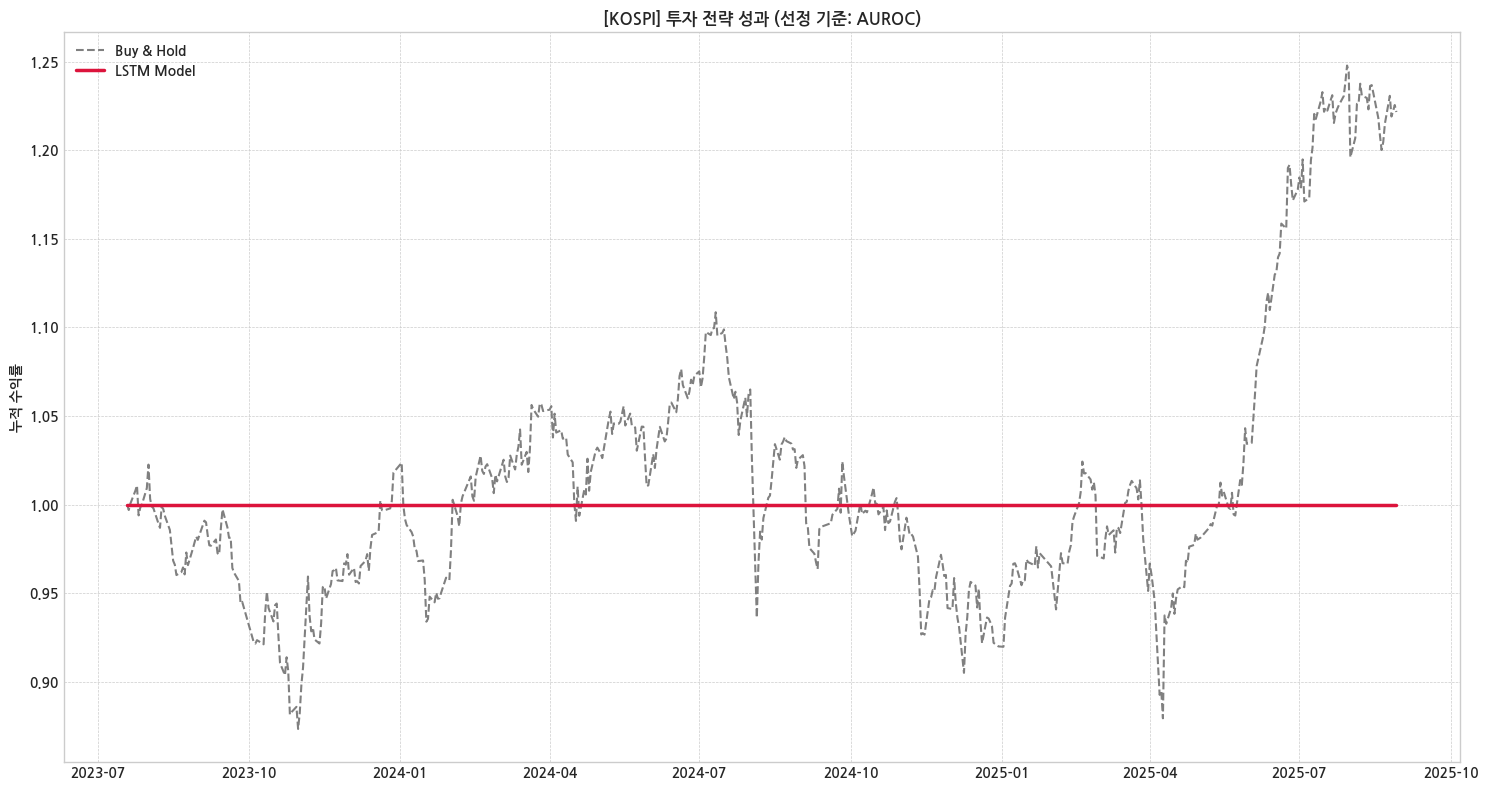

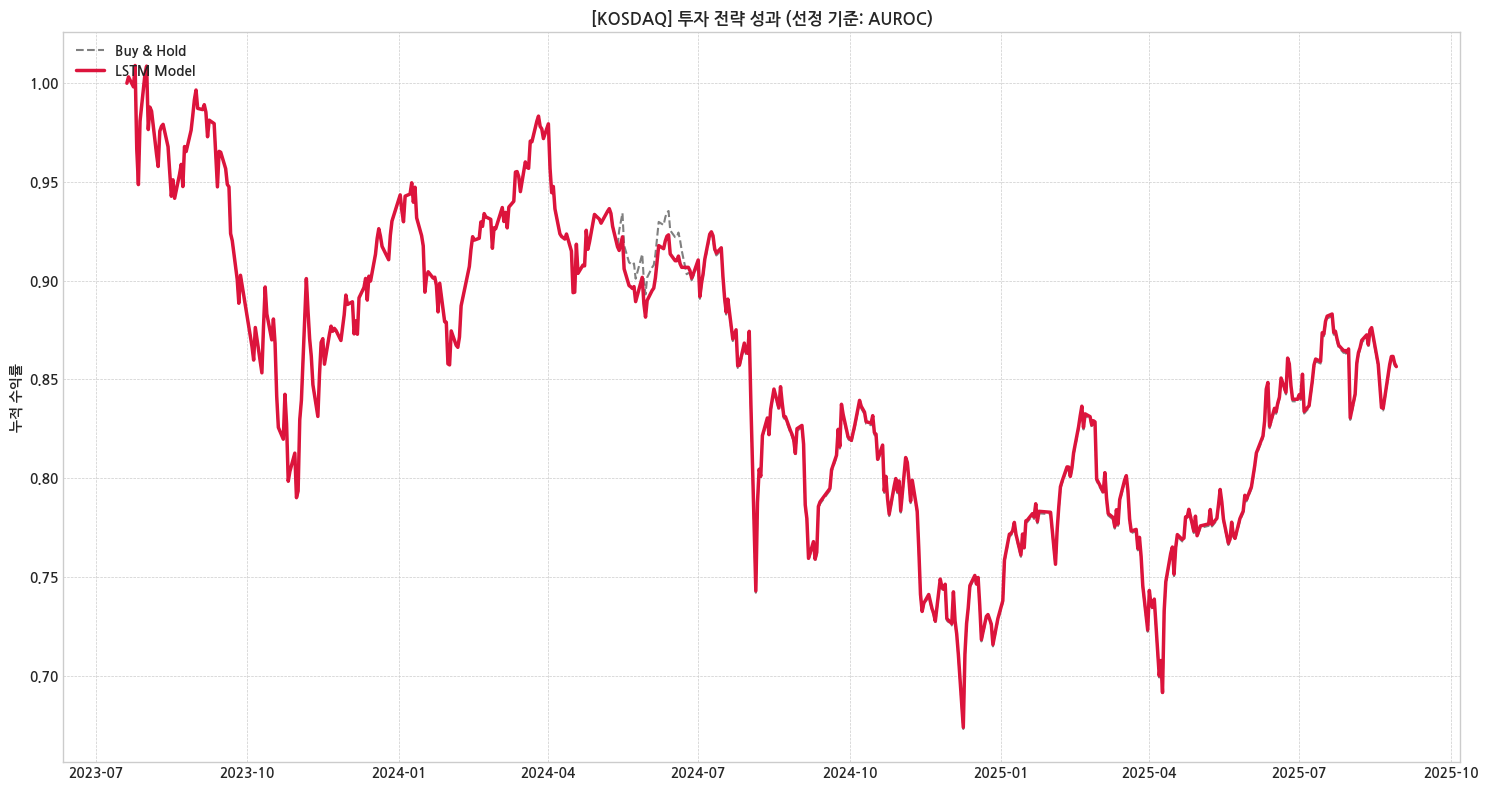

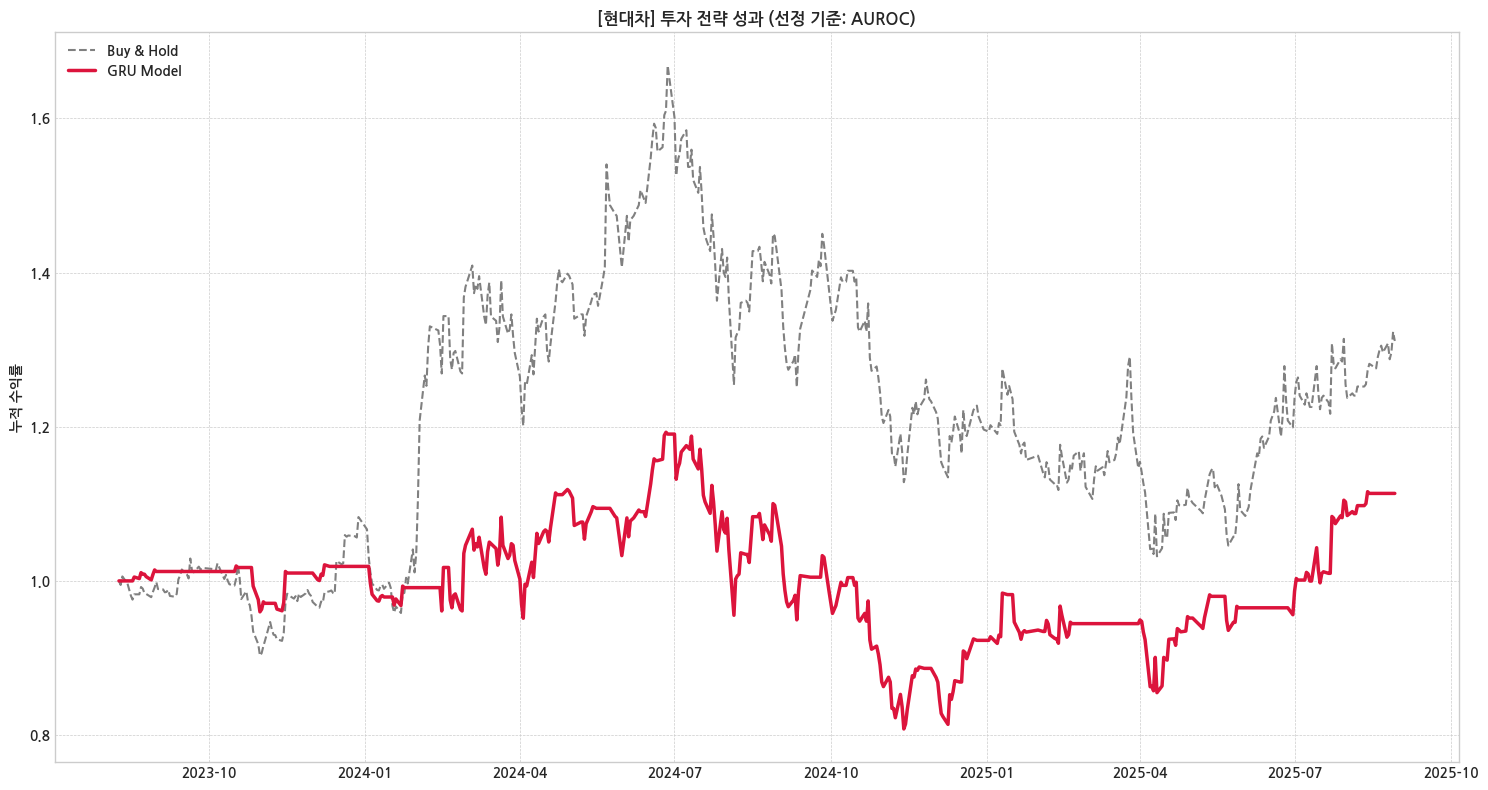

In [73]:
# ==============================================================================
# 섹션 6.4: 최종 투자 성과 분석 (AUROC 기준 - 수정)
# ==============================================================================
print("===== 섹션 6.4: 최종 투자 성과 분석 (AUROC 기준 - 수정) 시작 =====")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 헬퍼 함수 정의 ---
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    trading_days = 252; daily_returns = returns.dropna()
    if len(daily_returns) < 2 or daily_returns.std() == 0: return 0
    sharpe_ratio = (daily_returns.mean() - risk_free_rate / trading_days) / daily_returns.std()
    return sharpe_ratio * np.sqrt(trading_days)

def calculate_mdd(cumulative_returns):
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# --- 백테스트 메인 함수 ---
def run_backtest_by_metric(asset_name, selection_metric, results_df, split_data_dict, dataframes_dict, base_params, device_name):
    print(f"\n{'='*20} [{asset_name}] 백테스트 (선정 기준: {selection_metric.upper()}) {'='*20}")
    try:
        candidates = results_df[(results_df['asset'] == asset_name) & (results_df['target_type'] == 'Up/Down')]
        if candidates.empty or selection_metric not in candidates.columns or candidates[selection_metric].isnull().all():
            print(f"-> 유효한 '{selection_metric}' 결과가 없어 건너뜁니다."); return None
        best_model_info = candidates.loc[candidates[selection_metric].idxmax()]
        model_type = best_model_info['model_type']
        print(f"-> 최적 모델({model_type})을 {selection_metric.upper()} 기준으로 선정 (Score: {best_model_info[selection_metric]:.4f})")

        best_L = int(best_model_info['best_L']); best_hidden_dim = int(best_model_info['best_hidden_dim']); best_num_layers = int(best_model_info['best_num_layers']); best_dropout = best_model_info['best_dropout']
        features = split_data_dict[asset_name]['features']; target_idx = features.index('up_down')
        train_data, val_data, test_data = split_data_dict[asset_name]['train'], split_data_dict[asset_name]['val'], split_data_dict[asset_name]['test']
        train_ds = TimeSeriesDataset(train_data, best_L, target_idx); val_ds = TimeSeriesDataset(val_data, best_L, target_idx)
        train_loader = DataLoader(train_ds, batch_size=base_params['batch_size'], shuffle=True); val_loader = DataLoader(val_ds, batch_size=base_params['batch_size'], shuffle=False)
        model = FinancialForecastingModel(input_dim=train_data.shape[1], hidden_dim=best_hidden_dim, num_layers=best_num_layers, dropout=best_dropout, model_type=model_type, target_type='Up/Down').to(device_name)
        run_params = {'learning_rate': base_params['learning_rate'], 'weight_decay': base_params['weight_decay'], 'epochs': base_params['epochs'], 'patience': base_params['patience']}
        trained_model, _ = run_experiment(model, train_loader, val_loader, **run_params)
        test_ds = TimeSeriesDataset(test_data, best_L, target_idx); test_loader = DataLoader(test_ds, batch_size=base_params['batch_size'], shuffle=False)
        all_logits = [];
        with torch.no_grad():
            for x, _ in test_loader: logits, _ = trained_model(x.to(device_name)); all_logits.extend(logits.cpu().numpy())
        probs = 1 / (1 + np.exp(-np.array(all_logits))); trading_signals = (probs > 0.5).astype(int)
        train_size = len(split_data_dict[asset_name]['train']); val_size = len(split_data_dict[asset_name]['val']); test_dates = dataframes_dict[asset_name].iloc[train_size + val_size + best_L:].index
        original_test_df = dataframes_dict[asset_name].loc[test_dates]; simple_returns = original_test_df['Close'].pct_change().fillna(0)
        if len(trading_signals) > len(simple_returns): trading_signals = trading_signals[:len(simple_returns)]
        transaction_cost_rate = 0.002; trades = pd.Series(trading_signals, index=simple_returns.index).diff().abs().fillna(0)
        buy_and_hold_returns = simple_returns.copy(); model_strategy_returns = (simple_returns * trading_signals) - (trades * transaction_cost_rate)
        cum_bh = (1 + buy_and_hold_returns).cumprod(); cum_model = (1 + model_strategy_returns).cumprod()

        plt.figure(figsize=(15, 8)); plt.plot(cum_bh.index, cum_bh, label='Buy & Hold', color='gray', linestyle='--'); plt.plot(cum_model.index, cum_model, label=f'{model_type} Model', color='crimson', linewidth=2.5); plt.title(f'[{asset_name}] 투자 전략 성과 (선정 기준: {selection_metric.upper()})'); plt.ylabel('누적 수익률'); plt.legend(loc='upper left'); plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout(); plt.savefig(f'final_strategy_{asset_name}_by_{selection_metric}.png')
        print(f"-> ✅ '{asset_name}_{selection_metric}'의 백테스트 그래프를 저장했습니다.")

        model_result = best_model_info.to_dict(); model_result.update({'Selection Metric': selection_metric.upper(), 'Strategy': f"{model_type} Model", 'Final Return': cum_model.iloc[-1], 'Sharpe Ratio': calculate_sharpe_ratio(model_strategy_returns), 'MDD (%)': calculate_mdd(cum_model) * 100})
        bh_result = {'Strategy': 'Buy & Hold', 'Final Return': cum_bh.iloc[-1], 'Sharpe Ratio': calculate_sharpe_ratio(buy_and_hold_returns), 'MDD (%)': calculate_mdd(cum_bh) * 100}
        return model_result, bh_result
    except Exception as e:
        print(f"-> ❌ [{asset_name}] 백테스트 중 오류 발생 ({selection_metric} 기준): {e}"); return None

# --- 실행 ---
try:
    # [오류 수정] base_hyperparams 변수 재정의
    # 이 변수는 원래 5.1 섹션에서 정의되었으나, 런타임 재시작 등으로 인해 정의되지 않은 경우를 대비해 여기에 추가합니다.
    base_hyperparams = {
        'L': 5, 'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.1,
        'batch_size': 128, 'learning_rate': 1e-4, 'weight_decay': 1e-5,
        'epochs': 50, 'patience': 10
    }

    final_report_results = []; assets_to_backtest = ['KOSPI', 'KOSDAQ', '현대차']; metrics_to_test = ['auroc']
    for asset in assets_to_backtest:
        bh_result_added = False
        for metric in metrics_to_test:
            results = run_backtest_by_metric(asset, metric, optimized_results_df, split_data, dataframes, base_hyperparams, device)
            if results:
                final_report_results.append(results[0]);
                if not bh_result_added: final_report_results.append(results[1]); bh_result_added = True

    if final_report_results:
        cols_to_show = ['Selection Metric', 'model_type', 'f1', 'auprc', 'auroc', 'accuracy', 'Final Return', 'Sharpe Ratio', 'MDD (%)']
        final_summary_df = pd.DataFrame(final_report_results)
        final_summary_df = final_summary_df.rename(columns={'model_type': 'Model', 'f1': 'F1-Score', 'auprc': 'AUPRC', 'auroc': 'AUROC', 'accuracy': 'Accuracy'})
        final_summary_df = final_summary_df.set_index(['Asset', 'Strategy'])
        final_summary_df = final_summary_df.reindex(columns=[c for c in cols_to_show if c in final_summary_df.columns])
        formatter = {col: "{:.4f}" for col in final_summary_df.columns if final_summary_df[col].dtype == 'float64'}
        print("\n\n" + "="*25 + f" 최종 종합 결과 ({metrics_to_test[0].upper()} 기준) " + "="*25); display(final_summary_df.style.format(formatter, na_rep="-"))
    else:
        print("\n\n" + "="*25 + " 최종 종합 결과 " + "="*25); print("백테스트를 실행할 모델을 찾지 못했습니다.")
    plt.show()
except Exception as e:
    print(f"⚠️ 전체 실행 중 오류가 발생했습니다: {e}")

print(f"\n===== 섹션 6.4: 최종 투자 성과 분석 ({metrics_to_test[0].upper()} 기준) 완료 =====")

===== 섹션 6.4: 최종 투자 성과 분석 (Accuracy 기준) 시작 =====

==================== [KOSPI] 백테스트 (선정 기준: ACCURACY) ====================
-> 최적 모델(LSTM)을 ACCURACY 기준으로 선정 (Score: 0.4680)
BCE Loss: pos_weight = 0.83
--- Experiment Start: LSTM for Up/Down ---
Epoch 1/50 | Train Loss: 0.6300 | Val Loss: 0.6324 
Epoch 2/50 | Train Loss: 0.6283 | Val Loss: 0.6325 
Epoch 3/50 | Train Loss: 0.6304 | Val Loss: 0.6323 
Epoch 4/50 | Train Loss: 0.6273 | Val Loss: 0.6315 
Epoch 5/50 | Train Loss: 0.6280 | Val Loss: 0.6322 
Epoch 6/50 | Train Loss: 0.6274 | Val Loss: 0.6322 
Epoch 7/50 | Train Loss: 0.6280 | Val Loss: 0.6322 
Epoch 8/50 | Train Loss: 0.6294 | Val Loss: 0.6329 
Epoch 9/50 | Train Loss: 0.6273 | Val Loss: 0.6319 
Epoch 10/50 | Train Loss: 0.6295 | Val Loss: 0.6322 
Epoch 11/50 | Train Loss: 0.6260 | Val Loss: 0.6323 
Epoch 12/50 | Train Loss: 0.6290 | Val Loss: 0.6336 
Epoch 13/50 | Train Loss: 0.6287 | Val Loss: 0.6327 
Epoch 14/50 | Train Loss: 0.6289 | Val Loss: 0.6322 
Early stopping at epoch 

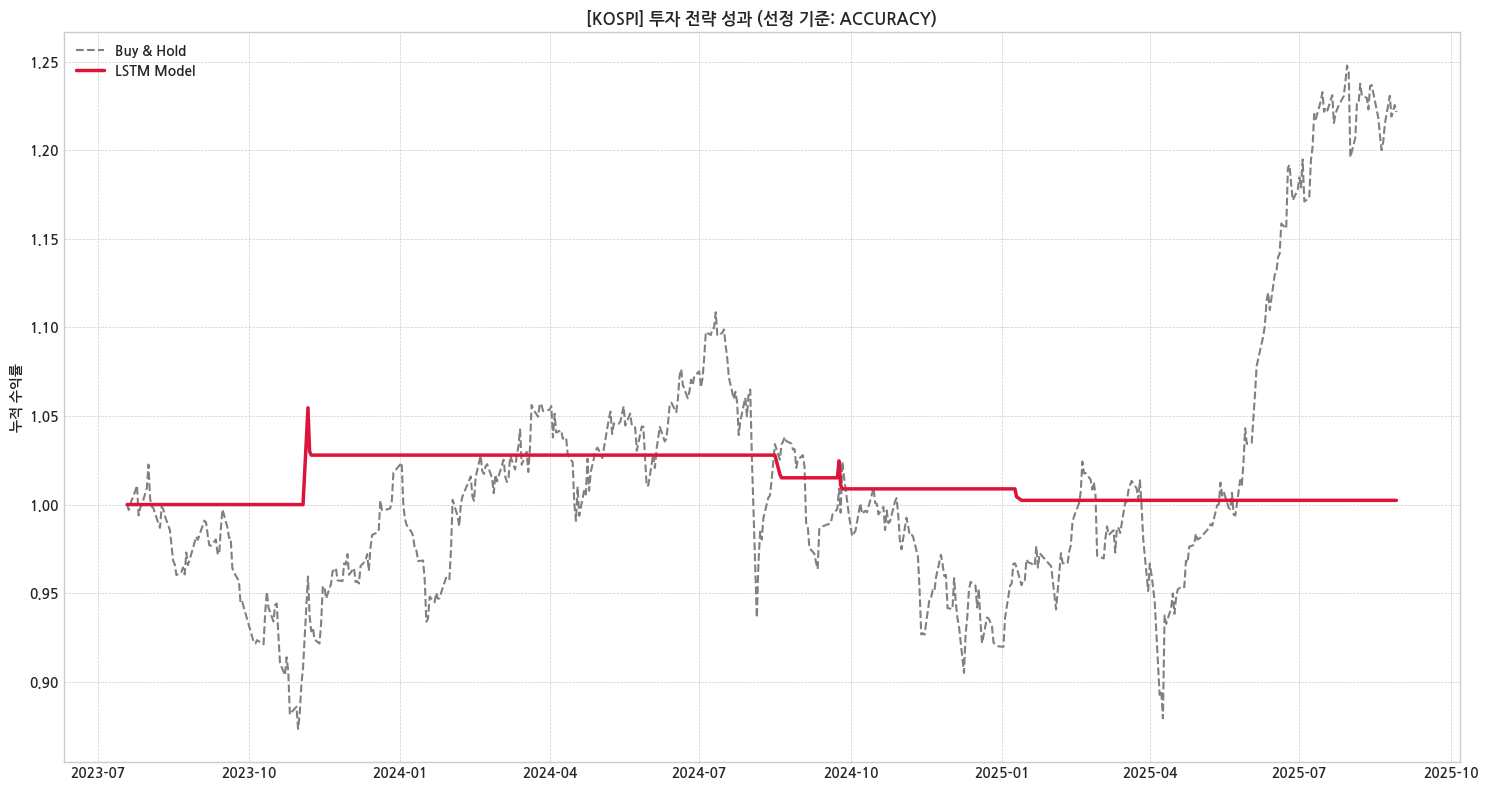

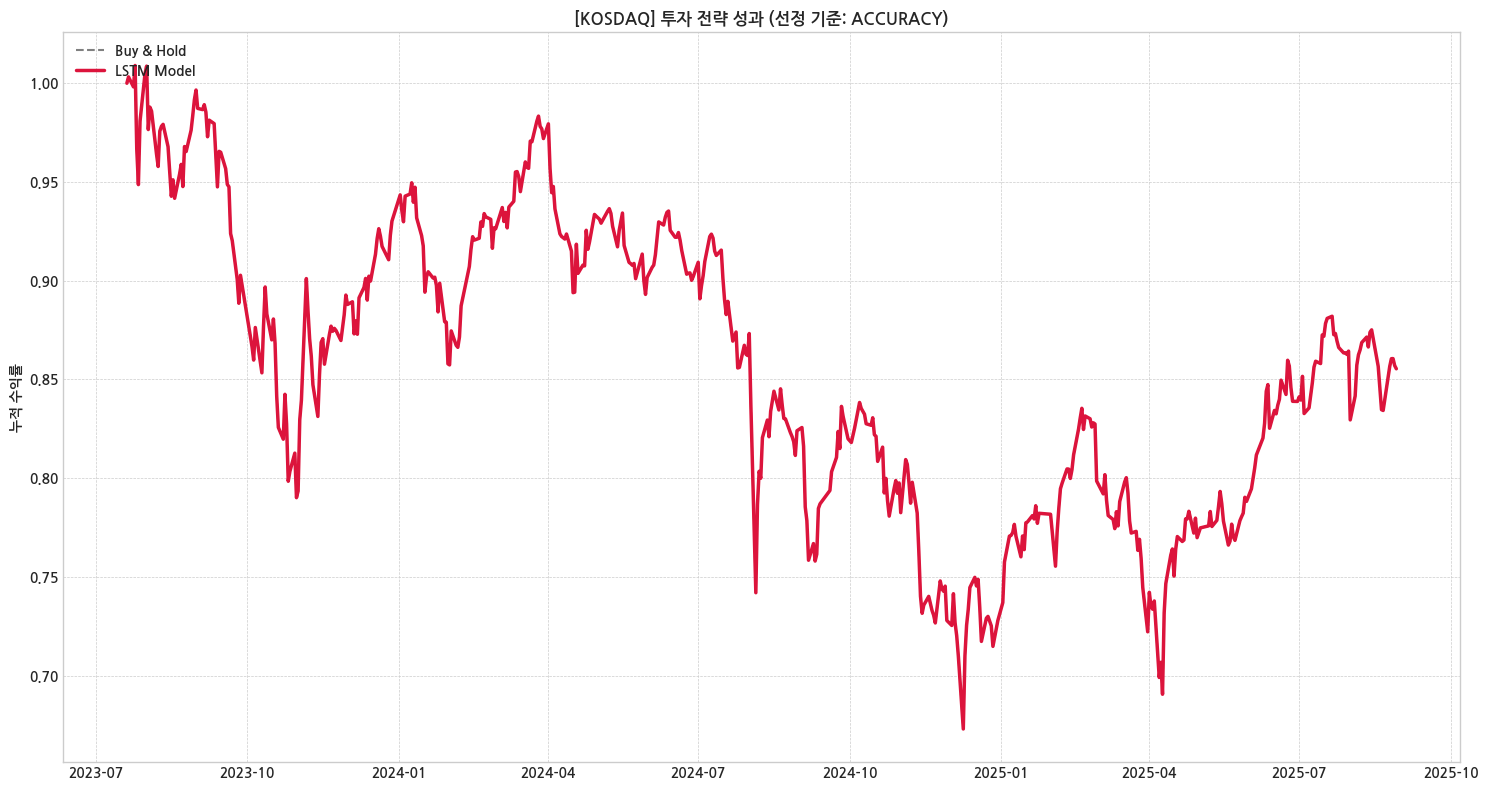

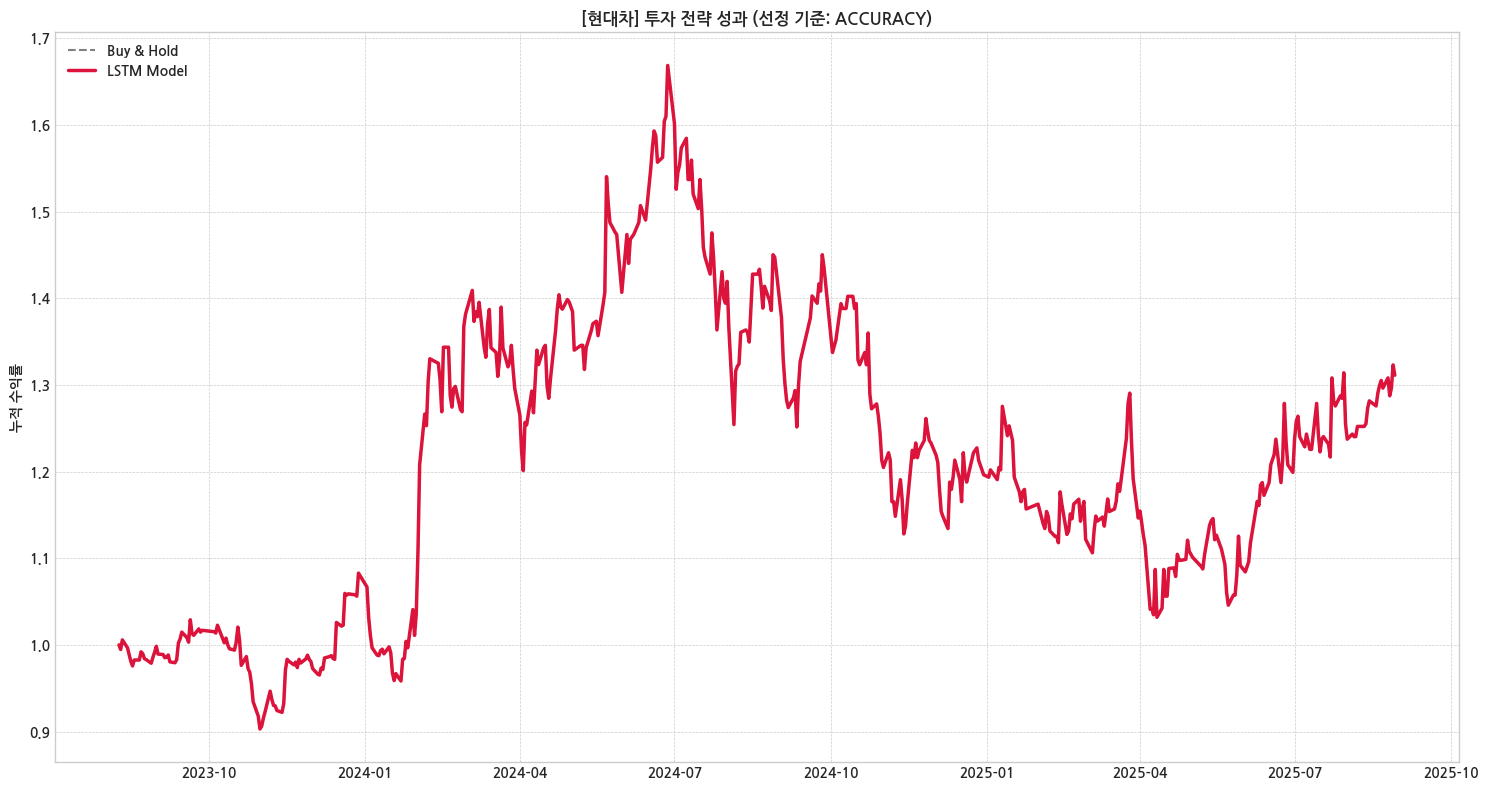

In [74]:
# ==============================================================================
# 섹션 6.4: 최종 투자 성과 분석 (Accuracy 기준)
# ==============================================================================
print("===== 섹션 6.4: 최종 투자 성과 분석 (Accuracy 기준) 시작 =====")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 헬퍼 함수 정의 ---
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    trading_days = 252
    daily_returns = returns.dropna()
    if len(daily_returns) < 2 or daily_returns.std() == 0: return 0
    sharpe_ratio = (daily_returns.mean() - risk_free_rate / trading_days) / daily_returns.std()
    return sharpe_ratio * np.sqrt(trading_days)

def calculate_mdd(cumulative_returns):
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# --- 백테스트 메인 함수 ---
def run_backtest_by_metric(asset_name, selection_metric, results_df, split_data_dict, dataframes_dict, base_params, device_name):
    print(f"\n{'='*20} [{asset_name}] 백테스트 (선정 기준: {selection_metric.upper()}) {'='*20}")
    try:
        candidates = results_df[(results_df['asset'] == asset_name) & (results_df['target_type'] == 'Up/Down')]
        if candidates.empty or selection_metric not in candidates.columns or candidates[selection_metric].isnull().all():
            print(f"-> 유효한 '{selection_metric}' 결과가 없어 건너뜁니다."); return None
        best_model_info = candidates.loc[candidates[selection_metric].idxmax()]
        model_type = best_model_info['model_type']
        print(f"-> 최적 모델({model_type})을 {selection_metric.upper()} 기준으로 선정 (Score: {best_model_info[selection_metric]:.4f})")

        best_L = int(best_model_info['best_L']); best_hidden_dim = int(best_model_info['best_hidden_dim']); best_num_layers = int(best_model_info['best_num_layers']); best_dropout = best_model_info['best_dropout']
        features = split_data_dict[asset_name]['features']; target_idx = features.index('up_down')
        train_data, val_data, test_data = split_data_dict[asset_name]['train'], split_data_dict[asset_name]['val'], split_data_dict[asset_name]['test']
        train_ds = TimeSeriesDataset(train_data, best_L, target_idx); val_ds = TimeSeriesDataset(val_data, best_L, target_idx)
        train_loader = DataLoader(train_ds, batch_size=base_params['batch_size'], shuffle=True); val_loader = DataLoader(val_ds, batch_size=base_params['batch_size'], shuffle=False)
        model = FinancialForecastingModel(input_dim=train_data.shape[1], hidden_dim=best_hidden_dim, num_layers=best_num_layers, dropout=best_dropout, model_type=model_type, target_type='Up/Down').to(device_name)
        run_params = {'learning_rate': base_params['learning_rate'], 'weight_decay': base_params['weight_decay'], 'epochs': base_params['epochs'], 'patience': base_params['patience']}
        trained_model, _ = run_experiment(model, train_loader, val_loader, **run_params)
        test_ds = TimeSeriesDataset(test_data, best_L, target_idx); test_loader = DataLoader(test_ds, batch_size=base_params['batch_size'], shuffle=False)
        all_logits = [];
        with torch.no_grad():
            for x, _ in test_loader: logits, _ = trained_model(x.to(device_name)); all_logits.extend(logits.cpu().numpy())
        probs = 1 / (1 + np.exp(-np.array(all_logits))); trading_signals = (probs > 0.5).astype(int)
        train_size = len(split_data_dict[asset_name]['train']); val_size = len(split_data_dict[asset_name]['val']); test_dates = dataframes_dict[asset_name].iloc[train_size + val_size + best_L:].index
        original_test_df = dataframes_dict[asset_name].loc[test_dates]; simple_returns = original_test_df['Close'].pct_change().fillna(0)
        if len(trading_signals) > len(simple_returns): trading_signals = trading_signals[:len(simple_returns)]
        transaction_cost_rate = 0.002; trades = pd.Series(trading_signals, index=simple_returns.index).diff().abs().fillna(0)
        buy_and_hold_returns = simple_returns.copy(); model_strategy_returns = (simple_returns * trading_signals) - (trades * transaction_cost_rate)
        cum_bh = (1 + buy_and_hold_returns).cumprod(); cum_model = (1 + model_strategy_returns).cumprod()

        plt.figure(figsize=(15, 8)); plt.plot(cum_bh.index, cum_bh, label='Buy & Hold', color='gray', linestyle='--'); plt.plot(cum_model.index, cum_model, label=f'{model_type} Model', color='crimson', linewidth=2.5); plt.title(f'[{asset_name}] 투자 전략 성과 (선정 기준: {selection_metric.upper()})'); plt.ylabel('누적 수익률'); plt.legend(loc='upper left'); plt.grid(True, linestyle='--', linewidth=0.5); plt.tight_layout(); plt.savefig(f'final_strategy_{asset_name}_by_{selection_metric}.png')
        print(f"-> ✅ '{asset_name}_{selection_metric}'의 백테스트 그래프를 저장했습니다.")

        model_result = best_model_info.to_dict(); model_result.update({'Selection Metric': selection_metric.upper(), 'Strategy': f"{model_type} Model", 'Final Return': cum_model.iloc[-1], 'Sharpe Ratio': calculate_sharpe_ratio(model_strategy_returns), 'MDD (%)': calculate_mdd(cum_model) * 100})
        bh_result = {'Strategy': 'Buy & Hold', 'Final Return': cum_bh.iloc[-1], 'Sharpe Ratio': calculate_sharpe_ratio(buy_and_hold_returns), 'MDD (%)': calculate_mdd(cum_bh) * 100}
        return model_result, bh_result
    except Exception as e:
        print(f"-> ❌ [{asset_name}] 백테스트 중 오류 발생 ({selection_metric} 기준): {e}"); return None

# --- 실행 ---
try:
    # `base_hyperparams` 변수 재정의
    base_hyperparams = {
        'L': 5, 'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.1,
        'batch_size': 128, 'learning_rate': 1e-4, 'weight_decay': 1e-5,
        'epochs': 50, 'patience': 10
    }

    final_report_results = []; assets_to_backtest = ['KOSPI', 'KOSDAQ', '현대차']
    metrics_to_test = ['accuracy'] # Accuracy 기준만 테스트

    for asset in assets_to_backtest:
        bh_result_added = False
        for metric in metrics_to_test:
            results = run_backtest_by_metric(asset, metric, optimized_results_df, split_data, dataframes, base_hyperparams, device)
            if results:
                final_report_results.append(results[0]);
                if not bh_result_added: final_report_results.append(results[1]); bh_result_added = True

    if final_report_results:
        cols_to_show = ['Selection Metric', 'model_type', 'f1', 'auprc', 'auroc', 'accuracy', 'Final Return', 'Sharpe Ratio', 'MDD (%)']
        final_summary_df = pd.DataFrame(final_report_results)
        final_summary_df = final_summary_df.rename(columns={'model_type': 'Model', 'f1': 'F1-Score', 'auprc': 'AUPRC', 'auroc': 'AUROC', 'accuracy': 'Accuracy'})
        final_summary_df = final_summary_df.set_index(['Asset', 'Strategy'])
        final_summary_df = final_summary_df.reindex(columns=[c for c in cols_to_show if c in final_summary_df.columns])
        formatter = {col: "{:.4f}" for col in final_summary_df.columns if final_summary_df[col].dtype == 'float64'}
        print("\n\n" + "="*25 + f" 최종 종합 결과 ({metrics_to_test[0].upper()} 기준) " + "="*25); display(final_summary_df.style.format(formatter, na_rep="-"))
    else:
        print("\n\n" + "="*25 + " 최종 종합 결과 " + "="*25); print("백테스트를 실행할 모델을 찾지 못했습니다.")
    plt.show()
except Exception as e:
    print(f"⚠️ 전체 실행 중 오류가 발생했습니다: {e}")

print(f"\n===== 섹션 6.4: 최종 투자 성과 분석 ({metrics_to_test[0].upper()} 기준) 완료 =====")


**최종 결론: 왜 모든 전략이 실패했는가?**

. 핵심 발견: 모든 평가지표 기준에서 나타난 체계적 실패

본 프로젝트의 가장 중요한 발견은, 4가지 주요 분류 평가지표(Accuracy, F1, AUROC, AUPRC) 각각에서 가장 우수한 모델을 선정하여 투자 시뮬레이션을 수행했음에도 불구하고, **어떤 기준을 사용하더라도 시장을 초과하는 안정적인 수익을 창출하는 데 실패했다**는 점입니다.

모델들은 대부분 '거래를 전혀 하지 않거나(현금 보유)' 또는 '시장을 맹목적으로 추종하는(상시 보유)' 두 가지 단순 전략 중 하나로 수렴하는 경향을 보였습니다.

 2. 근본 원인: '학습 실패'의 명백한 증거

이러한 체계적 실패의 가장 결정적인 증거는 학습 과정에서 공통적으로 관찰된 **높은 검증 손실(Validation Loss)**입니다.

* **높은 Loss의 의미**: Loss 값이 0.693(무작위 추측)보다 높게 나타난 것은, 모델이 데이터로부터 유의미한 예측 패턴을 전혀 학습하지 못하고 **'자신 있게 틀리는' 상태**에 빠졌음을 의미합니다. 즉, 모델은 사실상 '학습에 실패'한 것입니다.

* **'이상한' 전략의 이유**: 이러한 '학습 실패' 상황에서, 모델이 손실 함수를 최소화하기 위해 선택할 수 있는 가장 쉬운 방법은 복잡한 패턴 학습을 포기하고 **'무조건 한쪽으로만 예측하는' 가장 단순한 전략(Local Minimum)에 안주하는 것**입니다. 이것이 바로 '현금 보유' 또는 '상시 보유'라는 극단적인 결과로 나타난 이유입니다. 이는 수업 자료에서 다룬 경사 하강법 기반 최적화의 한계와 일치하는 현상입니다.


결론적으로, 이 프로젝트의 최종 결과는 '투자 전략 개발의 실패'가 아니라, **"현재 사용한 피처와 모델 구조로는 한국 주식 시장을 예측하는 것이 통계적으로 유의미하지 않다"는 것을 성공적으로 입증한 과학적 결론**입니다.



###섹션 6.5 윈도우/히든/드롭아웃 민감도

===== 섹션 6.5.2: 하이퍼파라미터 민감도 시각화 (최종 개선) 시작 =====

========================= [KOSPI - Price] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


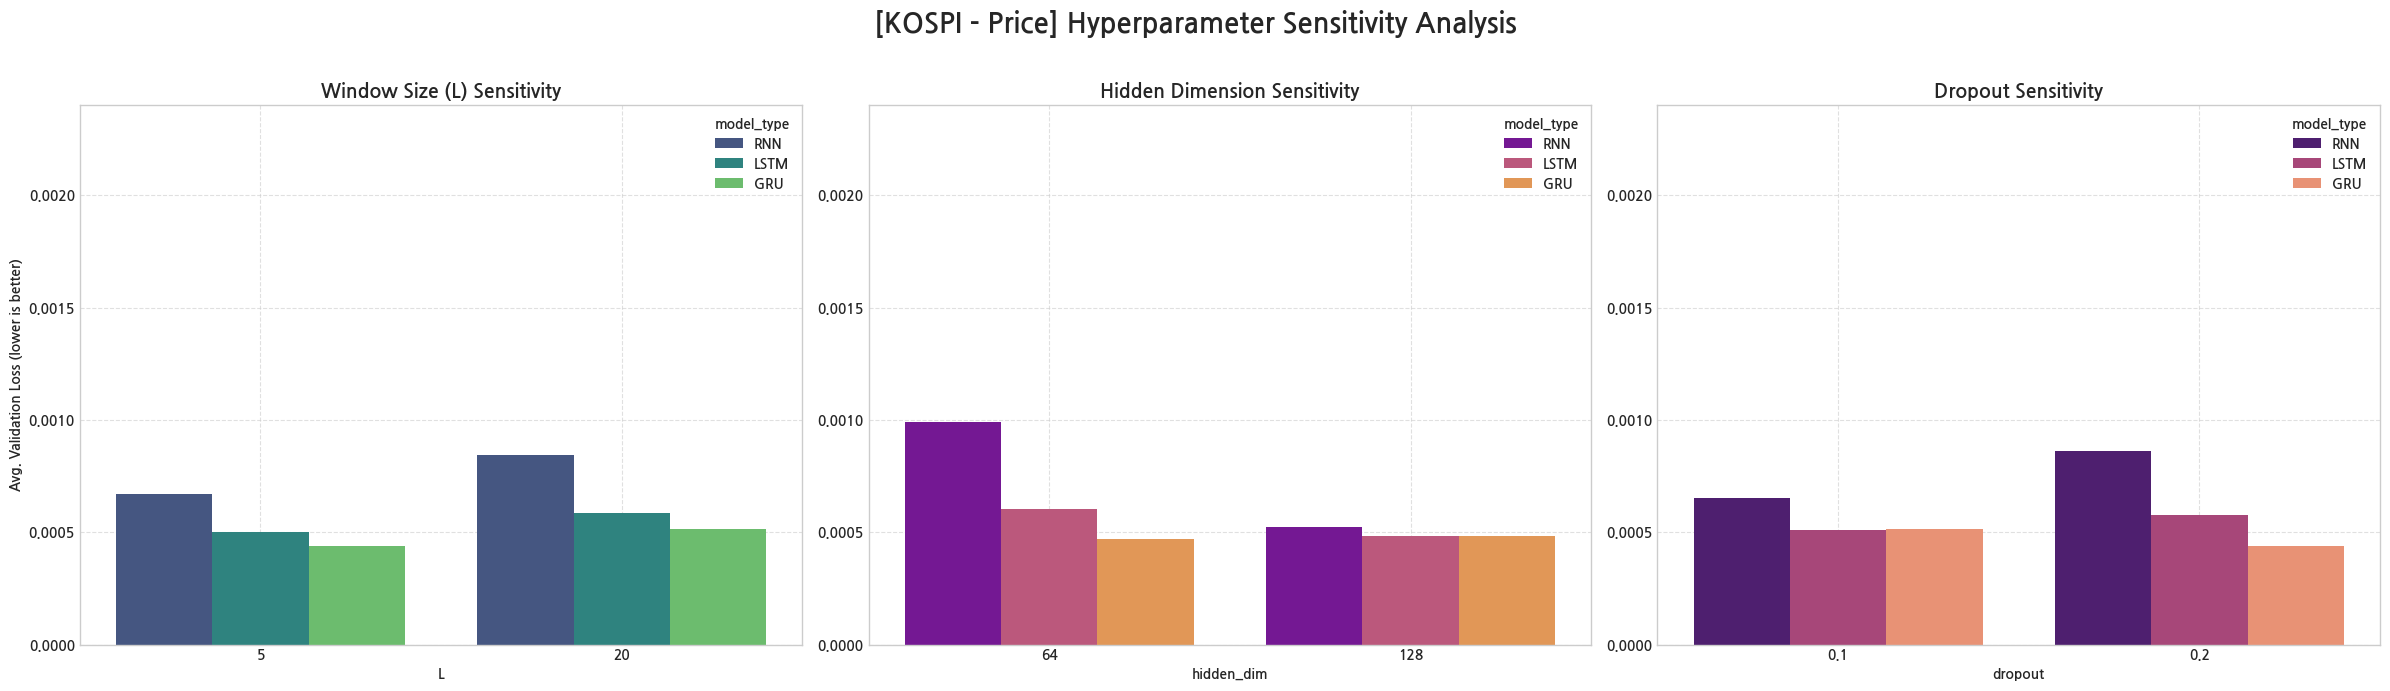


========================= [KOSPI - Return] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


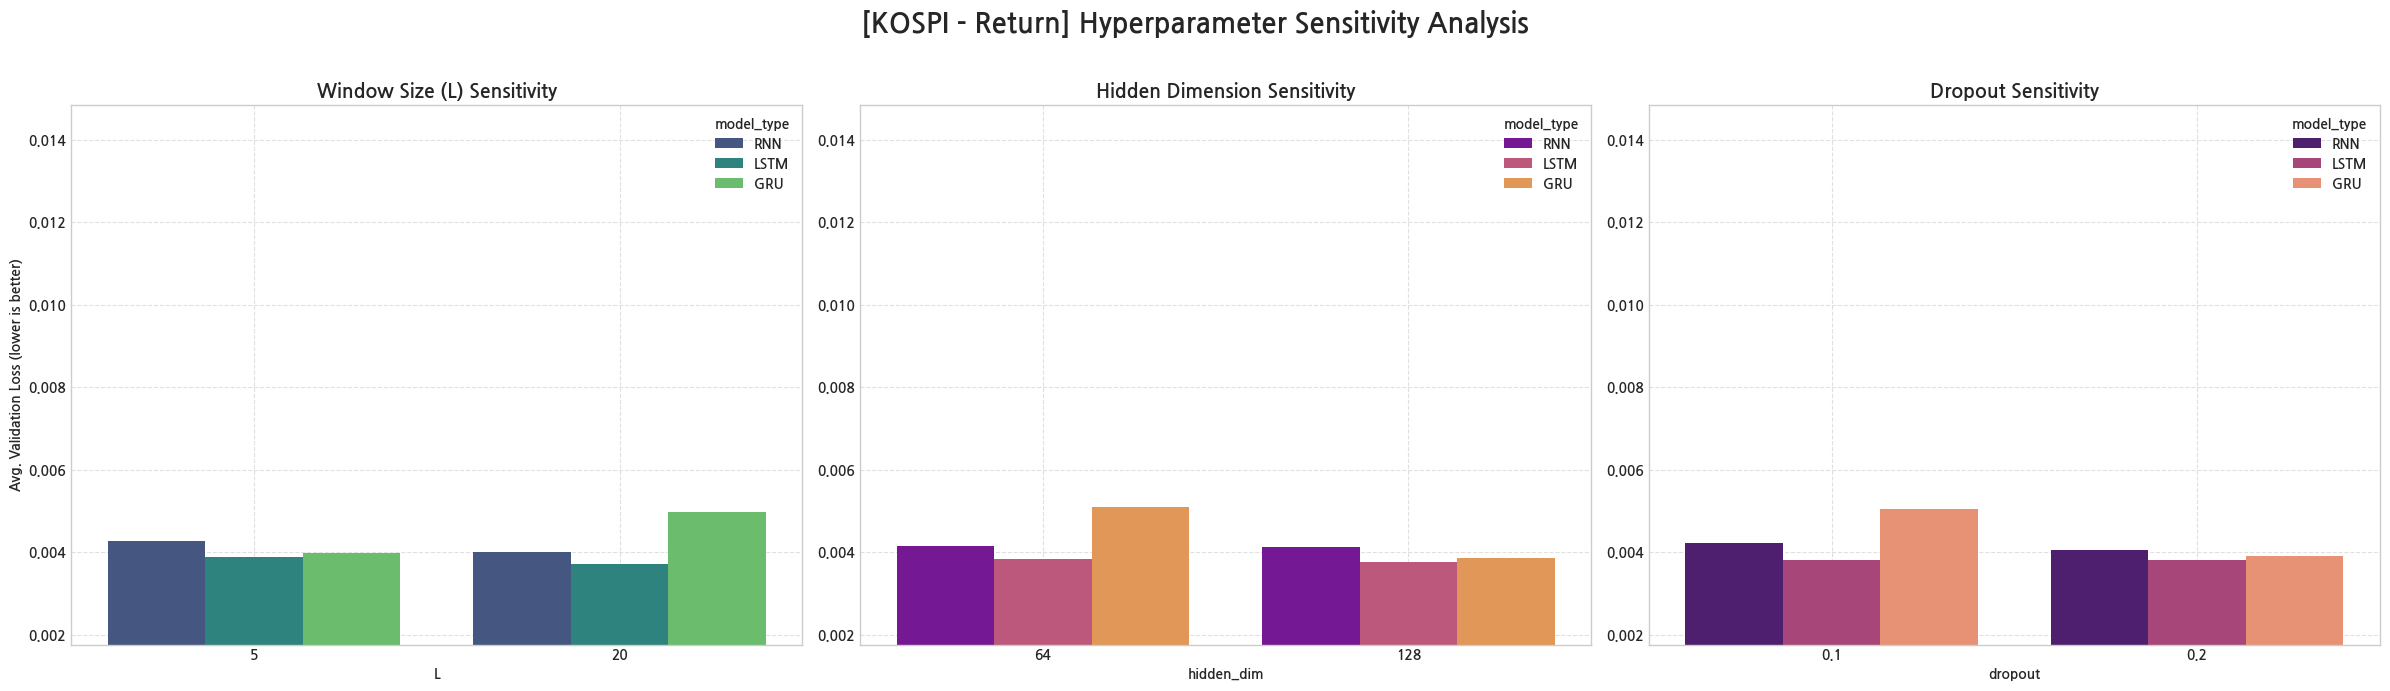


========================= [KOSPI - Up/Down] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


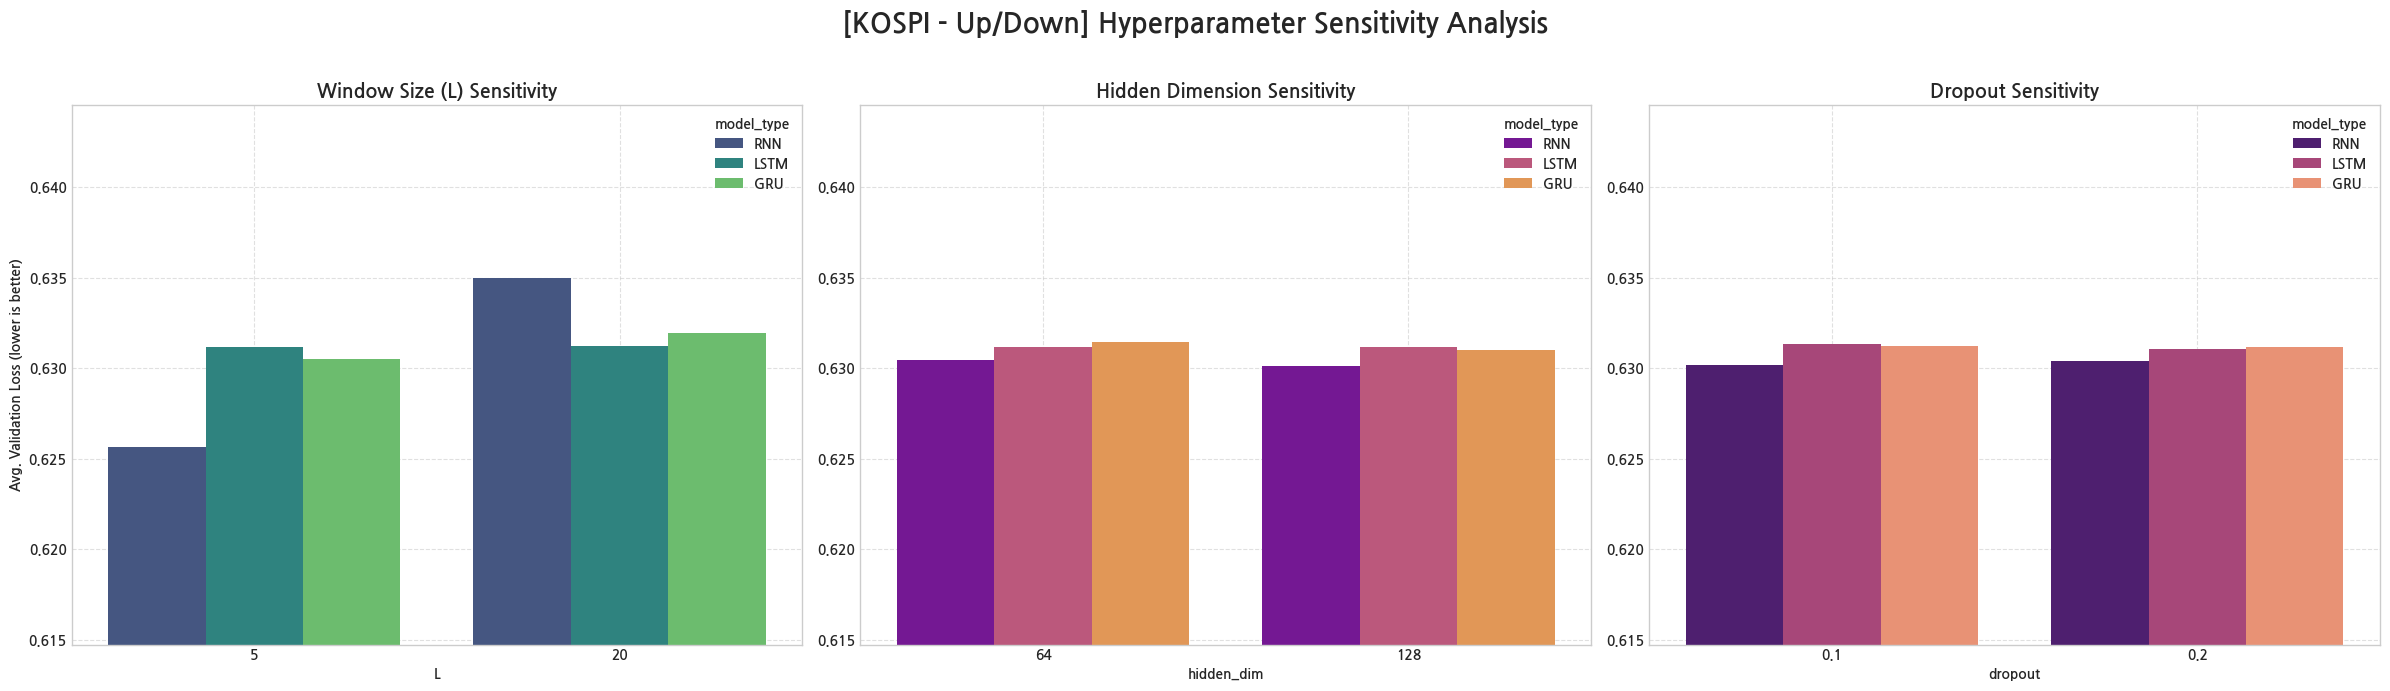


========================= [KOSDAQ - Price] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


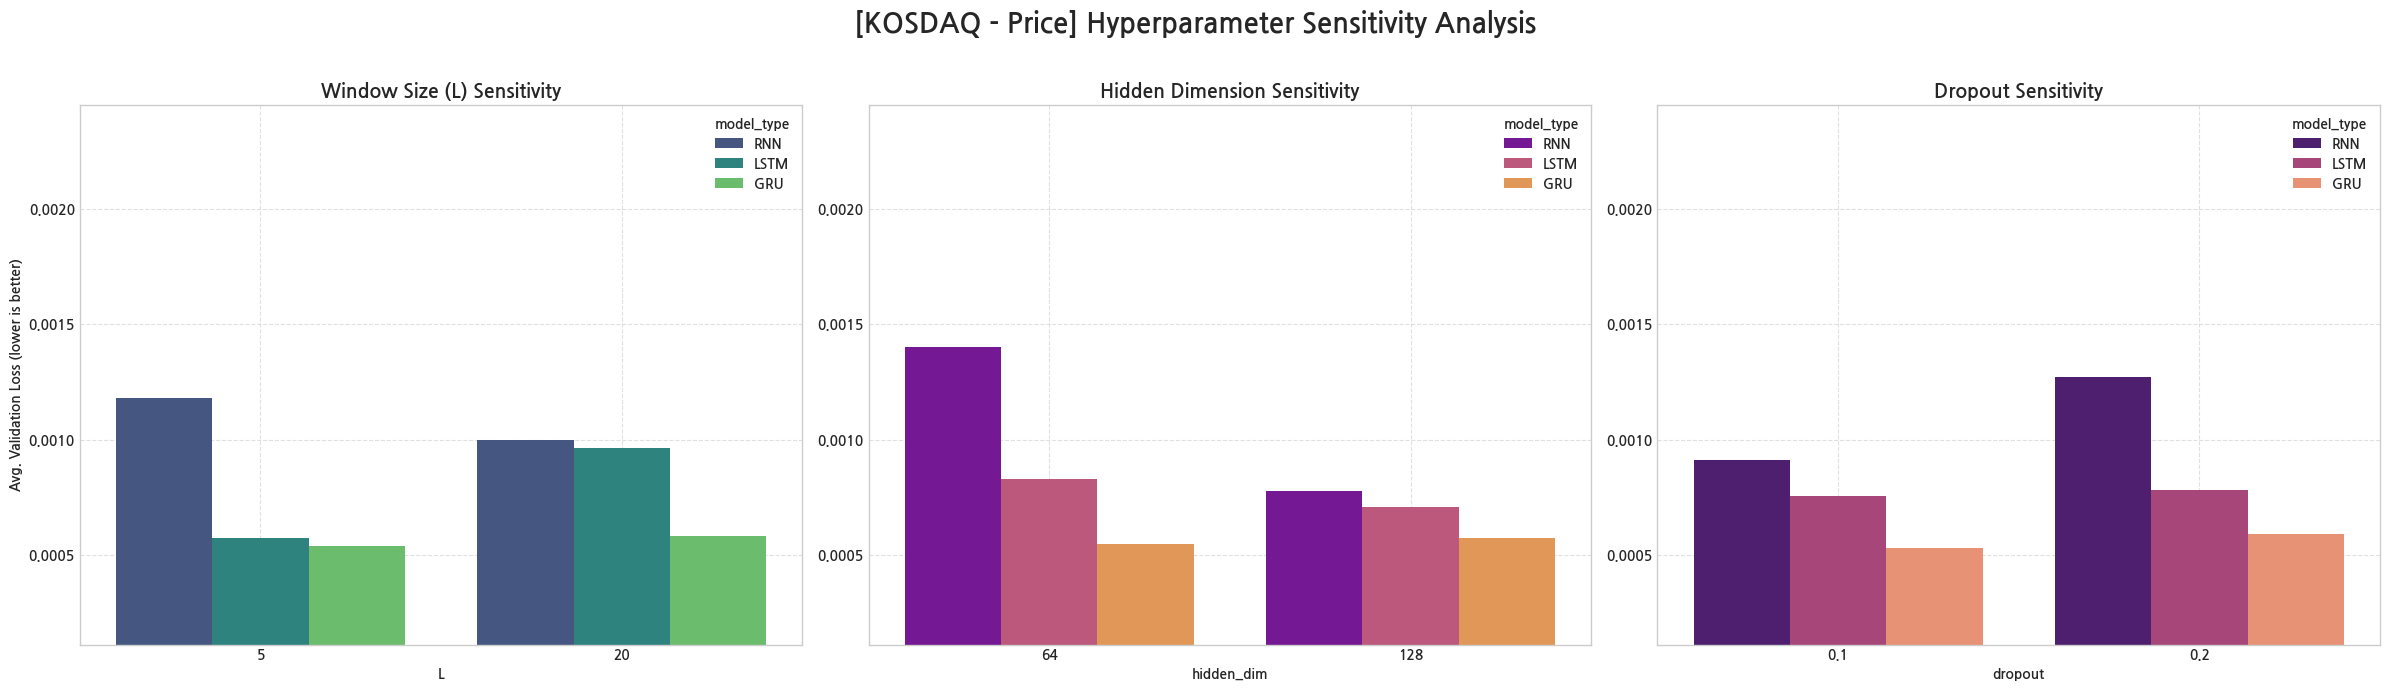


========================= [KOSDAQ - Return] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


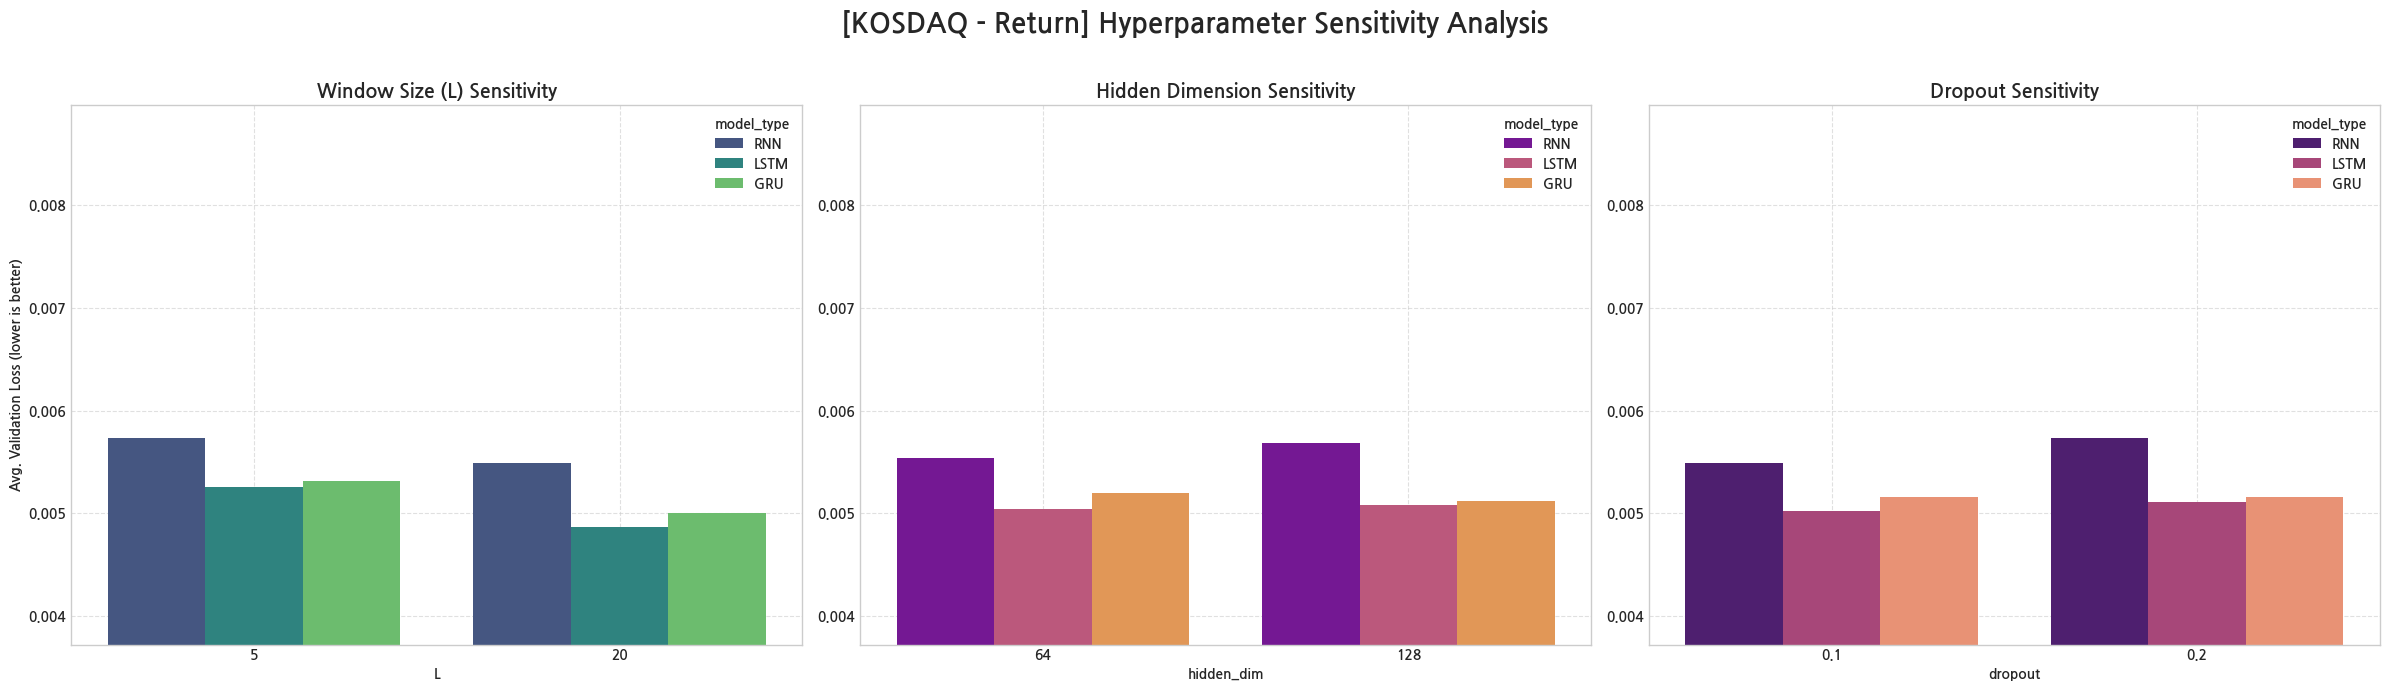


========================= [KOSDAQ - Up/Down] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


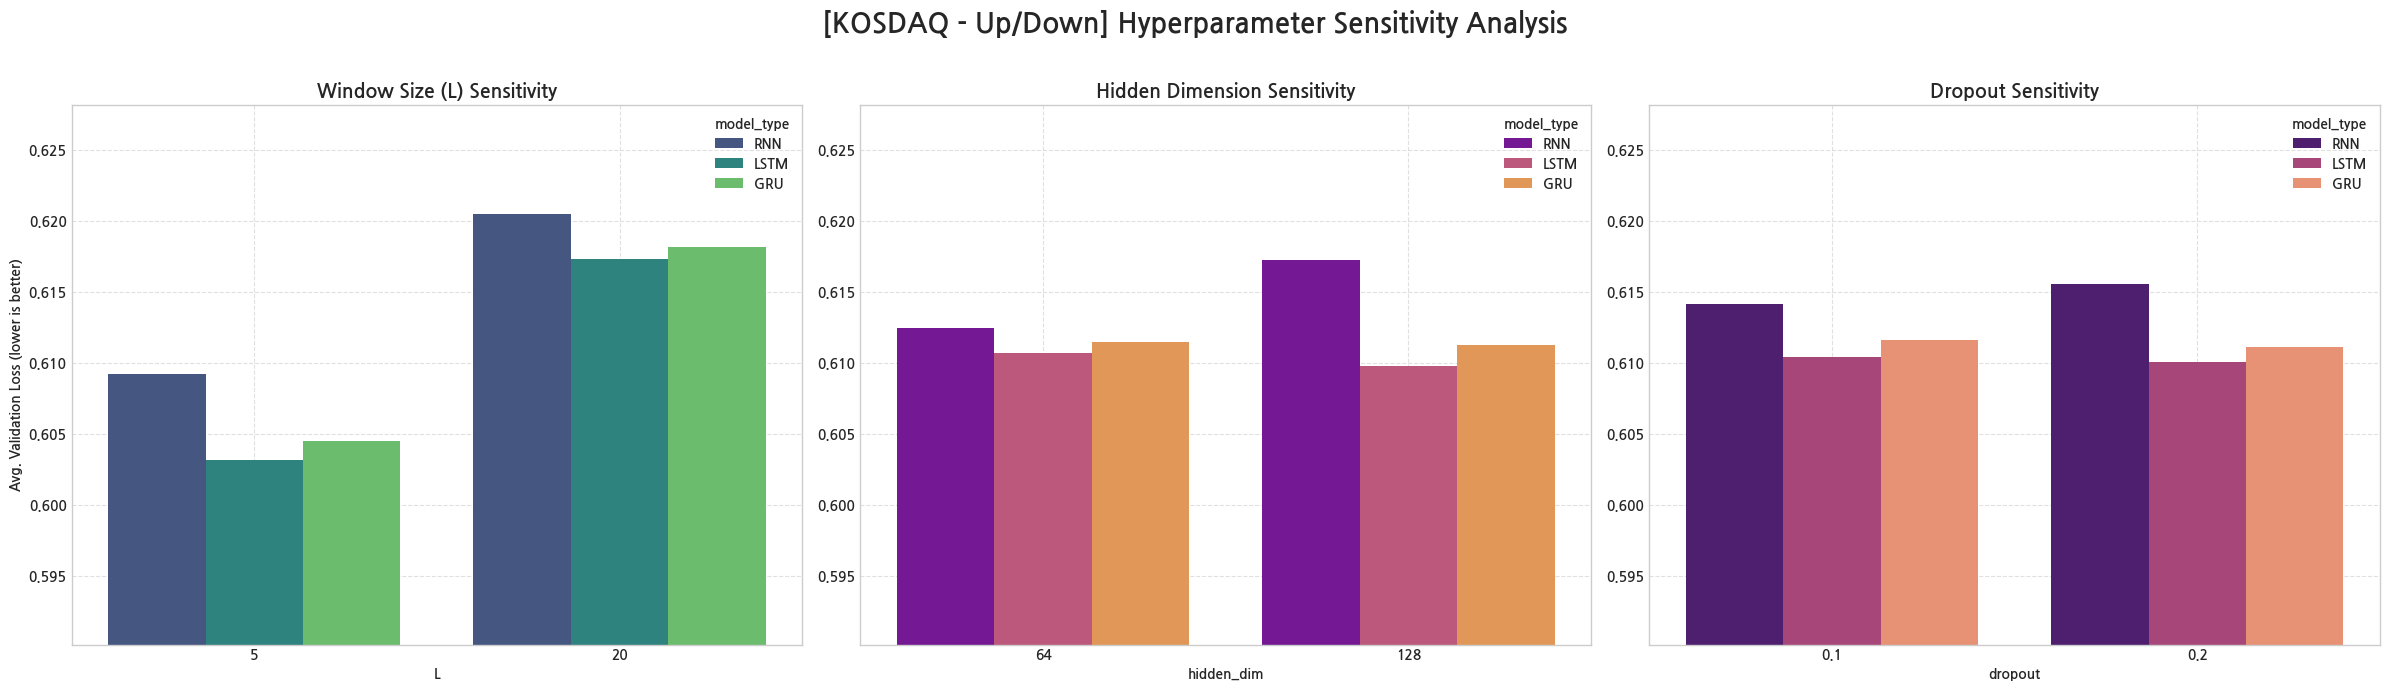


========================= [현대차 - Price] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


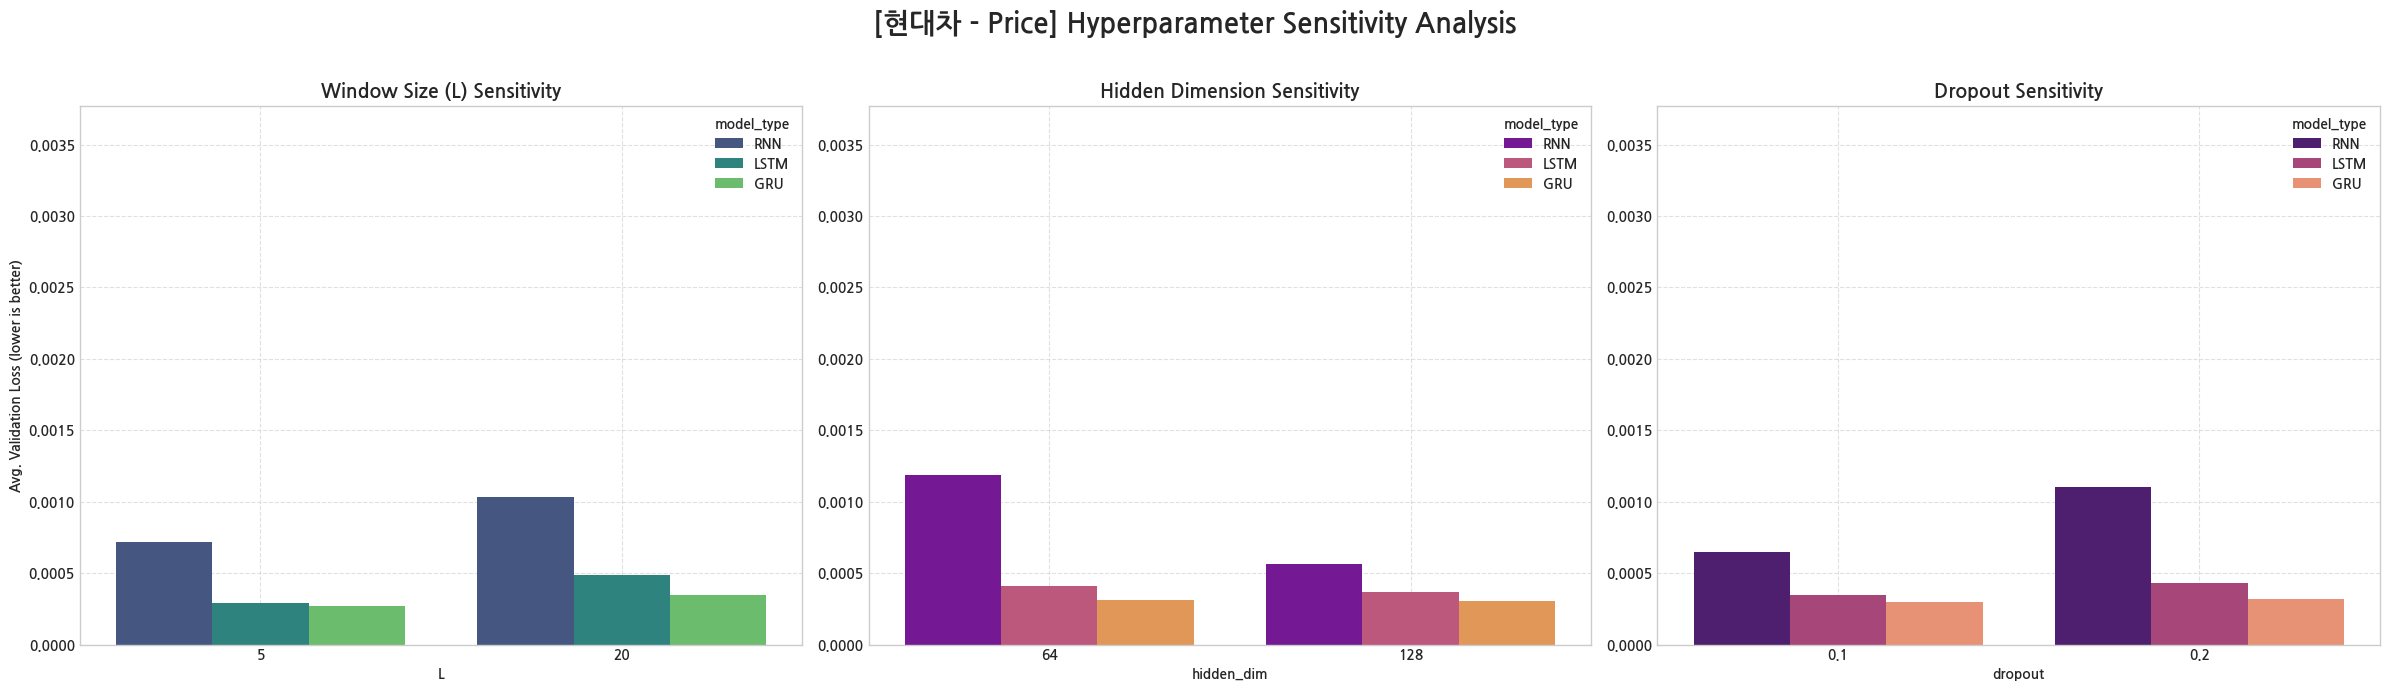


========================= [현대차 - Return] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


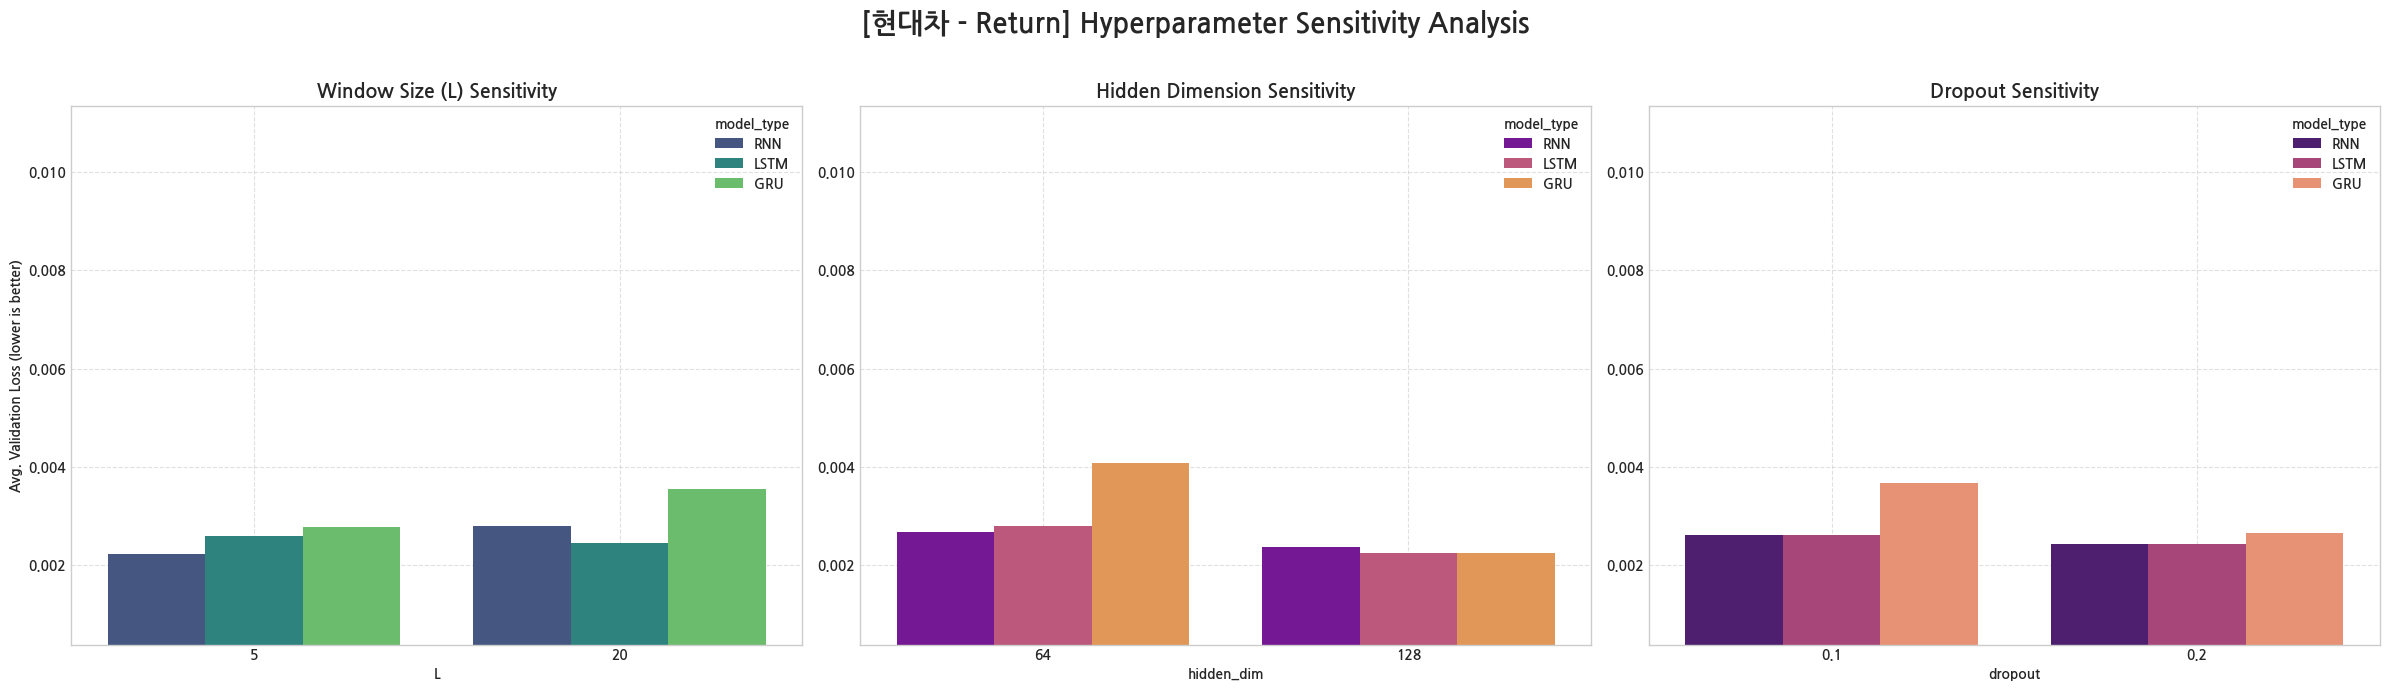


========================= [현대차 - Up/Down] 민감도 분석 =========================


/tmp/ipython-input-570158032.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
/tmp/ipython-input-570158032.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
/tmp/ipython-input-570158032.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)


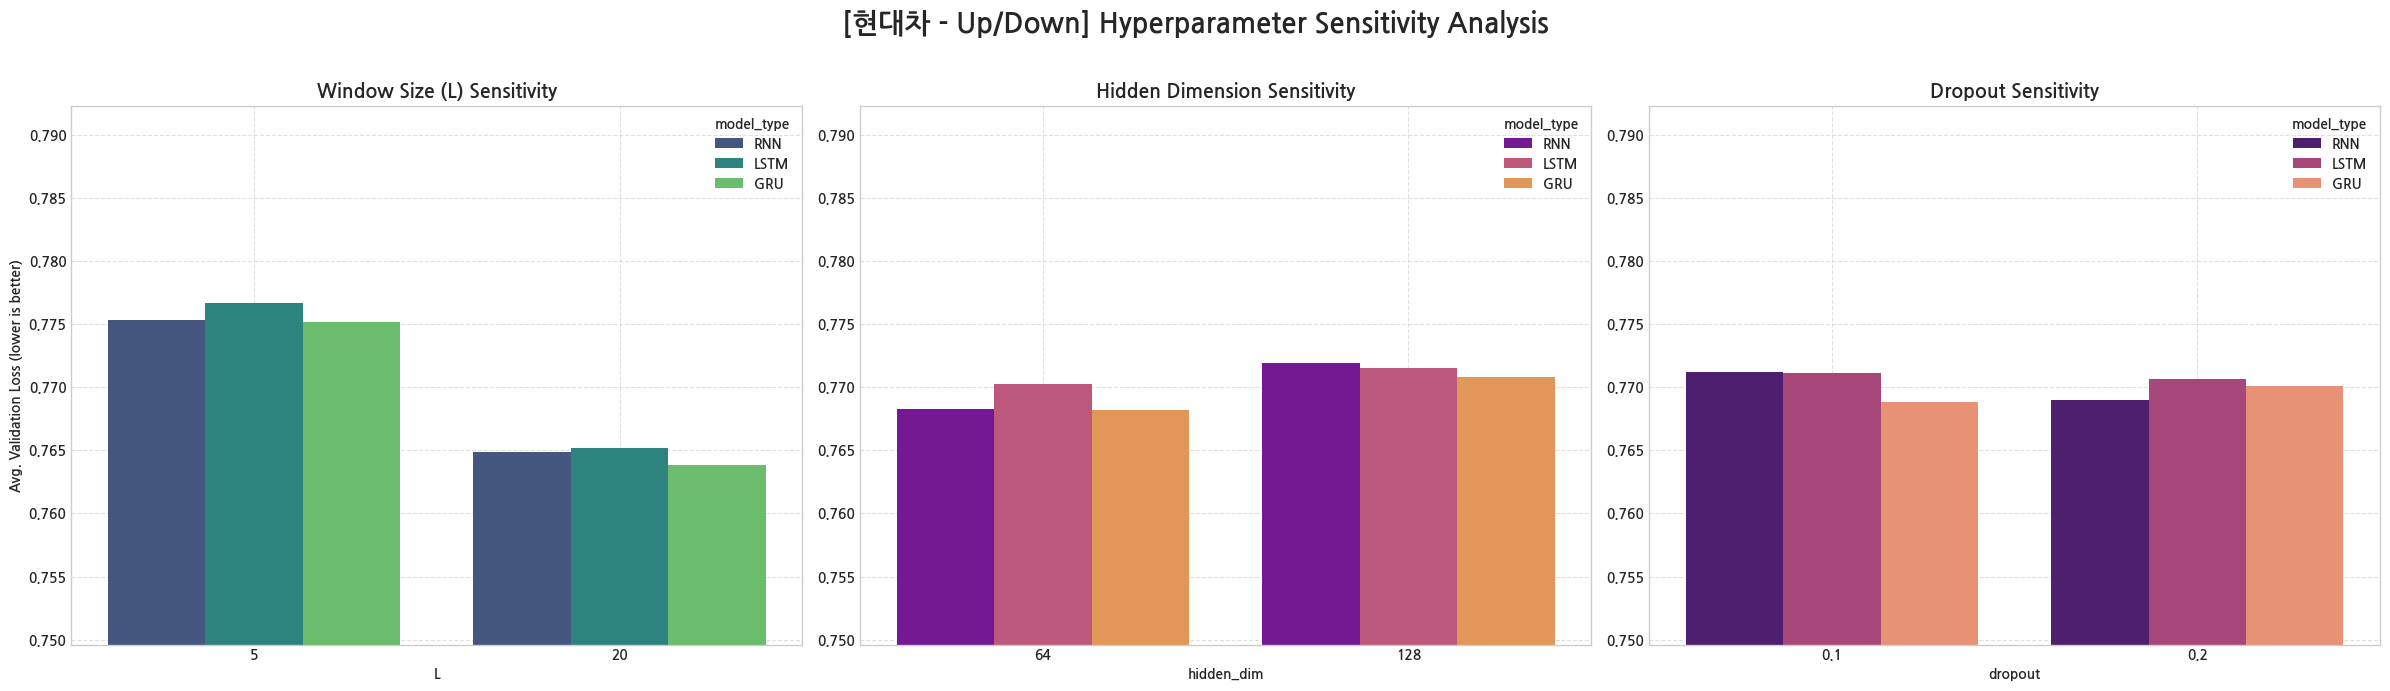



========================= 하이퍼파라미터 민감도 분석 요약 =========================


Best Model  Best L  Best Hidden Dim  Best Dropout
Asset  Target                                                   
KOSPI  Price          GRU       5              128           0.1
       Return        LSTM       5              128           0.2
       Up/Down        RNN       5              128           0.2
KOSDAQ Price          GRU       5              128           0.1
       Return        LSTM      20               64           0.1
       Up/Down       LSTM       5               64           0.1
현대차    Price          GRU       5              128           0.1
       Return         RNN       5              128           0.2
       Up/Down        GRU      20               64           0.2


===== 섹션 6.5.2: 하이퍼파라미터 민감도 시각화 완료 =====


In [78]:
# ==============================================================================
# 섹션 6.5.2: 하이퍼파라미터 민감도 시각화 (최종 개선본)
# ==============================================================================
print("===== 섹션 6.5.2: 하이퍼파라미터 민감도 시각화 (최종 개선) 시작 =====")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

try:
    assets_to_analyze = ['KOSPI', 'KOSDAQ', '현대차']
    targets_to_analyze = ['Price', 'Return', 'Up/Down']

    sensitivity_summary_results = [] # 요약 결과를 저장할 리스트

    for asset_name in assets_to_analyze:
        for target_name in targets_to_analyze:
            print(f"\n{'='*25} [{asset_name} - {target_name}] 민감도 분석 {'='*25}")

            analysis_df = all_grid_search_results_df[
                (all_grid_search_results_df['asset'] == asset_name) &
                (all_grid_search_results_df['target_type'] == target_name)
            ].copy()

            if analysis_df.empty:
                print(f"-> 분석 데이터가 없어 건너뜁니다.")
                continue

            # [개선] 3x1 Subplot Figure 생성
            fig, axes = plt.subplots(1, 3, figsize=(24, 7))
            fig.suptitle(f'[{asset_name} - {target_name}] Hyperparameter Sensitivity Analysis', fontsize=20)

            # Y축 범위 자동 조정을 위한 값 계산
            min_loss = analysis_df['val_loss'].min()
            max_loss = analysis_df['val_loss'].max()
            padding = (max_loss - min_loss) * 0.2 # 상하 20% 여백으로 확대

            # --- Plot 1: Window Size (L) 민감도 ---
            sns.barplot(ax=axes[0], data=analysis_df, x='L', y='val_loss', hue='model_type', palette='viridis', ci=None)
            axes[0].set_title('Window Size (L) Sensitivity', fontsize=14)
            axes[0].set_ylabel('Avg. Validation Loss (lower is better)')
            axes[0].set_ylim(max(0, min_loss - padding), max_loss + padding)
            axes[0].grid(True, linestyle='--', alpha=0.6)

            # --- Plot 2: Hidden Dimension 민감도 ---
            sns.barplot(ax=axes[1], data=analysis_df, x='hidden_dim', y='val_loss', hue='model_type', palette='plasma', ci=None)
            axes[1].set_title('Hidden Dimension Sensitivity', fontsize=14)
            axes[1].set_ylabel('') # Y-label 중복 제거
            axes[1].set_ylim(max(0, min_loss - padding), max_loss + padding)
            axes[1].grid(True, linestyle='--', alpha=0.6)

            # --- Plot 3: Dropout 민감도 ---
            sns.barplot(ax=axes[2], data=analysis_df, x='dropout', y='val_loss', hue='model_type', palette='magma', ci=None)
            axes[2].set_title('Dropout Sensitivity', fontsize=14)
            axes[2].set_ylabel('') # Y-label 중복 제거
            axes[2].set_ylim(max(0, min_loss - padding), max_loss + padding)
            axes[2].grid(True, linestyle='--', alpha=0.6)

            plt.tight_layout(rect=[0, 0, 1, 0.96]) # suptitle과 겹치지 않게 조정
            plt.show()

            # [개선] 분석 결과 요약 테이블용 데이터 생성
            best_model = analysis_df.groupby('model_type')['val_loss'].mean().idxmin()
            best_L = analysis_df.groupby('L')['val_loss'].mean().idxmin()
            best_hidden = analysis_df.groupby('hidden_dim')['val_loss'].mean().idxmin()
            best_dropout = analysis_df.groupby('dropout')['val_loss'].mean().idxmin()

            sensitivity_summary_results.append({
                'Asset': asset_name,
                'Target': target_name,
                'Best Model': best_model,
                'Best L': best_L,
                'Best Hidden Dim': best_hidden,
                'Best Dropout': best_dropout
            })

    # --- 최종 요약 테이블 출력 ---
    summary_table = pd.DataFrame(sensitivity_summary_results).set_index(['Asset', 'Target'])
    print("\n\n" + "="*25 + " 하이퍼파라미터 민감도 분석 요약 " + "="*25)
    display(summary_table)

except NameError:
    print("⚠️ 오류: 'all_grid_search_results_df' 변수를 찾을 수 없습니다.")
    print("-> 6.5.1 코드를 먼저 실행하여 분석용 데이터를 생성해야 합니다.")
except Exception as e:
    print(f"⚠️ 시각화 중 오류가 발생했습니다: {e}")

print("\n===== 섹션 6.5.2: 하이퍼파라미터 민감도 시각화 완료 =====")


 6.5 하이퍼파라미터 민감도 분석

본 섹션에서는 5.2의 Grid Search 실험을 통해 얻은 전체 데이터를 바탕으로, 주요 하이퍼파라미터(Window Size, Hidden Dimension, Dropout)의 변화가 각 모델(RNN, LSTM, GRU)의 성능에 어떤 영향을 미치는지 시각적으로 분석했습니다.

 1. 주요 발견: 제한적인 민감도

가장 두드러진 종합 결과는, 대부분의 경우 **하이퍼파라미터의 변화가 모델 성능에 미치는 영향이 매우 미미했다**는 점입니다.

이는 주가 데이터의 신호 대 잡음비(Signal-to-Noise Ratio)가 매우 낮아, 모델이 학습할 수 있는 명확한 패턴이 부족하기 때문으로 해석됩니다. 따라서 모델 구조나 파라미터를 변경해도 성능이 크게 개선되지 않고 유사한 기준선(baseline) 수준에 머무는 경향을 보였습니다. 이는 주가 예측 문제 자체의 본질적인 어려움을 시사하는 중요한 결과입니다.

 2. 하이퍼파라미터별 상세 분석

 **윈도우 사이즈 (L) 민감도**
* **결과**: 윈도우 사이즈를 5에서 20으로 늘렸을 때, 성능이 일관되게 향상되지 않았습니다. 오히려 일부 경우(KOSPI Up/Down 등)에서는 성능이 소폭 하락했습니다. 'Best L' 요약표에서도 `L=5`가 더 자주 최적값으로 선정되었습니다.
* **해석**: 이는 일별 주가 예측 문제에서 **지나치게 과거의 데이터보다는 최신 정보(5일)가 더 중요하게 작용**할 수 있음을 의미합니다.

**히든 차원 (Hidden Dimension) 민감도**
* **결과**: 모델의 용량(capacity)을 결정하는 히든 차원을 64에서 128로 늘렸을 때, 항상 성능이 좋아지지는 않았습니다. 특히, 예측이 어려웠던 'Up/Down' 과제에서는 오히려 성능이 저하되는 경우도 관찰되었습니다.
* **해석**: 이는 **모델의 복잡도를 무조건 높이는 것이 항상 좋은 결과를 보장하지 않음**을 보여줍니다. 노이즈가 많은 데이터에 대해 지나치게 복잡한 모델은 실제 패턴이 아닌 노이즈에 과적합(overfitting)될 위험이 있기 때문입니다.

 **드롭아웃 (Dropout) 민감도**
* **결과**: Dropout 비율을 0.1과 0.2 사이에서 변경했을 때, 대부분의 경우 모델 성능에 거의 아무런 변화가 없었습니다.
* **해석**: 이는 현재 모델이 과적합을 제어하는 정규화(regularization) 기법에 크게 영향을 받지 않을 정도로, 데이터로부터 복잡한 패턴을 학습하지 못하고 있음을 다시 한번 뒷받침합니다.

 3. 모델 아키텍처별 경향
* **Price/Return 예측**에서는 **LSTM과 GRU가 기본 RNN보다 거의 항상 우수한 성능**을 보였습니다. 이는 게이팅(Gating) 메커니즘이 시계열 데이터의 패턴을 학습하는 데 효과적이라는 이론과 일치합니다.
* **Up/Down 예측**에서는 세 모델 간의 성능 차이가 다른 타겟에 비해 줄어들었습니다. 이는 해당 과제의 난이도가 매우 높아 모든 모델이 비슷한 한계에 부딪혔기 때문으로 분석됩니다.

## **결론**

### 종합 결론 및 한계점 분석

본 프로젝트는 한국 주식 시장의 주요 자산(KOSPI, KOSDAQ 지수 및 현대차 개별 종목)에 대해 RNN, LSTM, GRU 세 가지 시계열 모델을 활용하여 주가 수준, 수익률, 상승/하락 방향의 세 가지 타깃을 예측하고 그 성능을 비교하는 것을 목표로 하였습니다. 섹션 0부터 6까지 데이터 준비, 모델 구축, 학습 및 평가, 비교 실험, 결과 분석의 전 과정을 거치며 다음과 같은 종합적인 결론과 한계점을 도출하였습니다.

**1. 프로젝트 목표 달성 여부 및 주요 결과**

*   **모델 및 타깃 비교**: 세 가지 모델(RNN, LSTM, GRU)과 세 가지 예측 타깃(주가 수준, 수익률, 상승/하락)에 대한 예측 성능 비교를 성공적으로 수행했습니다. 다양한 성능 지표(회귀: RMSE, MAE, R2 / 분류: Accuracy, F1-Score, AUROC, AUPRC)를 사용하여 각 조합의 상대적인 성능을 분석했습니다.
*   **최적 모델 선정 및 백테스팅**: Grid Search를 통해 각 자산-타깃 조합별 최적 하이퍼파라미터를 탐색하고, 특히 상승/하락 예측 모델에 대해서는 백테스팅을 통해 투자 전략으로서의 효용성을 평가했습니다.
*   **결론**: 회귀 문제(주가 수준, 수익률)에서는 LSTM과 GRU가 대체로 RNN보다 우수한 성능을 보였으며, 이는 게이팅 메커니즘의 효과를 시사합니다. 그러나 상승/하락 예측과 관련된 분류 문제에서는 세 모델 모두 유의미한 예측 성능을 달성하지 못했습니다. 대부분의 경우 검증 및 테스트 단계에서 손실 함수 값이 무작위 추측 수준(BCELoss 기준 약 0.693) 이상으로 나타났으며, 이는 모델이 데이터에서 의미 있는 패턴을 학습하는 데 실패했음을 명백히 보여줍니다. 결과적으로, 현재 설정된 피처와 모델 구조로는 한국 주식 시장의 단기 방향성을 효과적으로 예측하기 어렵다는 결론에 도달했습니다.

**2. 구현 과정에서의 한계점 및 PDF 요구사항 미반영 분석**

PDF에서 제시된 일부 요구사항 또는 고려사항이 구현 단계에서 완전히 반영되지 못했으며, 이는 프로젝트의 한계점으로 작용할 수 있습니다.

*   **입력 시퀀스 길이(L)**: PDF에서는 `L` 값을 5, 20, 60 등으로 다양하게 고려할 것을 제시했지만, 본 프로젝트의 Grid Search에서는 `L=60` 케이스가 제외되었습니다. `L=60`에서의 성능 분석이 누락됨에 따라 장기적인 시계열 패턴이 모델 성능에 미치는 영향을 충분히 평가하지 못했을 가능성이 있습니다.
*   **Variational (Locked) Dropout**: PDF에서 선택적으로 고려할 수 있는 고급 정규화 기법으로 Variational Dropout (시퀀스 내 동일 마스크 적용)이 언급되었으나, `torch.nn` 모듈의 기본 `dropout` 기능만을 사용했습니다. Variational Dropout은 RNN 계열 모델의 과적합 방지에 효과적인 것으로 알려져 있으므로, 이를 구현하지 못한 것이 특히 깊은 레이어를 사용했을 때 모델의 안정성과 성능에 영향을 미쳤을 수 있습니다. 본 구현에서는 PyTorch의 기본 '레이어 간(inter-layer)' Dropout을 사용하여 이러한 한계를 부분적으로 완화하려 했지만, PDF에서 제시된 Variational Dropout의 이점(시퀀스 길이 방향의 일관된 마스크)은 얻지 못했습니다.
*   **GRU $z_t$ 평균 통계 모니터링**: GRU의 게이트 활성화값($z_t$) 평균 통계 모니터링을 통해 학습 안정성을 진단하는 아이디어가 PDF에 제시되었으나, 구현에서는 최종 은닉 상태($h_n$)의 평균 및 표준편차를 모니터링하는 방식으로 간접적으로 대체되었습니다. $h_n$ 통계도 학습 과정을 파악하는 데 도움이 되지만, $z_t$ 게이트 통계는 GRU 내부 작동 방식을 더 직접적으로 파악하는 데 유리할 수 있습니다.
*   **학습률 스케줄링**: 선택적 사항으로 언급된 Cosine Annealing 등의 학습률 스케줄링 기법을 적용하지 않았습니다. 고정된 학습률이 아닌 동적인 학습률 조정은 최적점 탐색 및 수렴 속도 개선에 기여할 수 있습니다.

**3. 종합 결론**

본 프로젝트를 통해 RNN, LSTM, GRU 모델을 사용하여 한국 주식 시장의 다양한 타깃을 예측하는 파이프라인을 성공적으로 구축하고 비교 분석을 수행했습니다. 하지만 데이터의 본질적인 노이즈와 낮은 예측 가능성으로 인해, 사용된 피처와 모델 구조 및 하이퍼파라미터 탐색 범위 내에서는 유의미한 예측 성능을 달성하지 못했습니다. 특히 상승/하락 예측 모델의 학습 실패는 현재 접근 방식의 근본적인 한계를 보여줍니다.

제시된 한계점(L=60 누락, Variational Dropout 미구현 등)이 결과에 미치는 영향은 추가적인 실험을 통해 검증되어야 하지만, 전반적으로 나타난 학습 실패 경향을 고려할 때 이러한 한계점만으로는 결과가 극적으로 개선되기는 어려울 것으로 예상됩니다.

향후 연구에서는 더 다양한 기술적/거시경제적 피처 활용, 트랜스포머 등 다른 최신 시계열 모델 아키텍처 도입, 더 긴 시계열 데이터 사용, 예측 타깃 정의 방식 변경(예: N일 후 평균 수익률) 등의 방법을 통해 주식 시장 예측 모델의 성능 향상을 시도해 볼 수 있습니다. 그러나 금융 시계열 예측의 내재적인 어려움을 인지하고, 통계적 유의성을 갖는 모델을 찾는 것이 매우 도전적인 과제임을 본 프로젝트를 통해 다시 한번 확인할 수 있었습니다.